In [1]:
# Set Keras 3 backend to PyTorch and enable CUDA
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
keras.config.set_backend("torch")

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Keras backend:", keras.backend.backend())
print("PyTorch CUDA available:", torch.cuda.is_available())
print("Selected device:", device)

Keras backend: torch
PyTorch CUDA available: True
Selected device: cuda


In [2]:

import sys
sys.path.append(os.path.abspath("../src"))

from data.loader import load_and_clean_raw_dataset



# --- Global config
LOOKBACK = 20
BATCH_SIZE = 32
LATENT_DIM = 12
SURFACE_SHAPE = (11, 10)
FEATURE_DIM = LOOKBACK * (11 * 10 + 1 + 32)

TARGET_DATE = "2025-05-21"
TARGET_STRIKE = 1.0
TARGET_TAU = 1.0

USE_PREPROCESSED_INPUTS = False


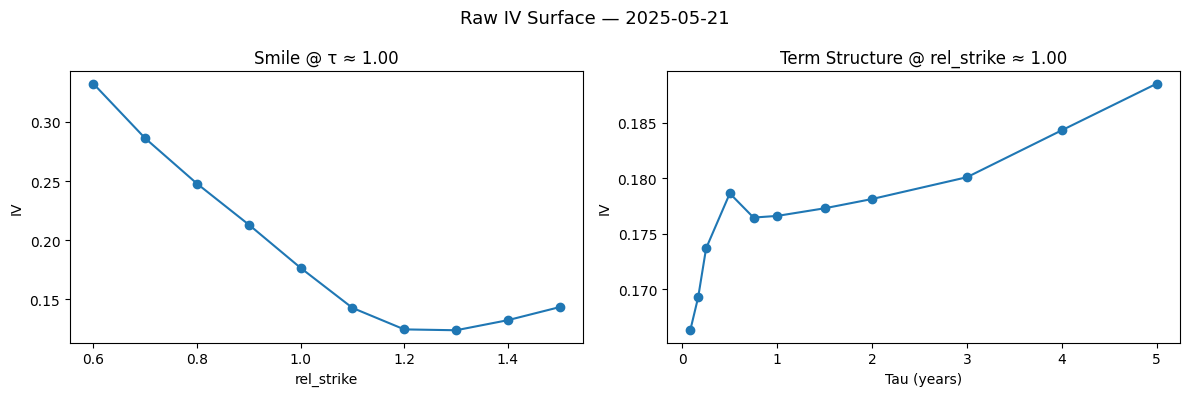

In [3]:

from data.loader import load_and_clean_raw_dataset

df = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")


from utils.plotting import plot_raw_iv_slice

plot_raw_iv_slice(df, target_date=TARGET_DATE, target_strike=TARGET_STRIKE, target_tau=TARGET_TAU,)



In [4]:
from data.dataset_builder import build_full_surface_feature_df

# Load enriched surface + features
df_all = build_full_surface_feature_df("../data/vol_tensor_dataset.csv")

# Identify IV and feature columns
iv_cols = [c for c in df_all.columns if c.startswith("IV_")]
feat_cols = [c for c in df_all.columns if not c.startswith("IV_")]
df_all = df_all.dropna(subset=feat_cols)

print("Final DataFrame shape:", df_all.shape)
print("Surface columns:", len(iv_cols), "| Feature columns:", len(feat_cols))
print("IV column sample:", iv_cols[:5])
print("Feature column sample:", feat_cols[:5])
print(df_all.columns)


Final DataFrame shape: (1265, 136)
Surface columns: 110 | Feature columns: 26
IV column sample: ['IV_1m_0.60', 'IV_1m_0.70', 'IV_1m_0.80', 'IV_1m_0.90', 'IV_1m_1.00']
Feature column sample: ['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d', 'realized_vol_5d_ma20']
Index(['IV_1m_0.60', 'IV_1m_0.70', 'IV_1m_0.80', 'IV_1m_0.90', 'IV_1m_1.00',
       'IV_1m_1.10', 'IV_1m_1.20', 'IV_1m_1.30', 'IV_1m_1.40', 'IV_1m_1.50',
       ...
       'slope_10_30', 'smile_skew', 'smile_convexity', 'ts_level', 'ts_slope',
       'ts_curvature', 'ts_weighted', 'ts_short_avg', 'ts_long_avg',
       'ts_split_slope'],
      dtype='object', length=136)


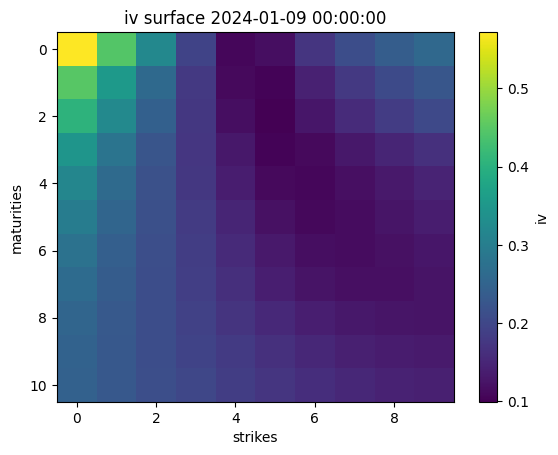


surface 2024-01-09 00:00:00


strike       0.6     0.7     0.8     0.9     1.0     1.1     1.2     1.3  \
maturity                                                                   
18m       0.5720  0.4449  0.3192  0.1949  0.1084  0.1177  0.1720  0.2114   
1m        0.4500  0.3535  0.2614  0.1785  0.1121  0.1037  0.1434  0.1788   
1y        0.4058  0.3218  0.2441  0.1766  0.1176  0.0995  0.1287  0.1586   
2m        0.3451  0.2805  0.2240  0.1744  0.1292  0.1040  0.1111  0.1304   
2y        0.3157  0.2623  0.2169  0.1770  0.1383  0.1111  0.1071  0.1186   
3m        0.2974  0.2528  0.2152  0.1814  0.1475  0.1206  0.1104  0.1151   
3y        0.2771  0.2424  0.2126  0.1848  0.1565  0.1317  0.1180  0.1149   
4y        0.2652  0.2362  0.2111  0.1870  0.1624  0.1399  0.1253  0.1184   
5y        0.2541  0.2311  0.2106  0.1910  0.1715  0.1534  0.1397  0.1306   
6m        0.2484  0.2293  0.2119  0.1954  0.1792  0.1641  0.1513  0.1414   
9m        0.2462  0.2293  0.2138  0.1993  0.1853  0.1723  0.1611  0.1520   

strike       1.4     1.5  
maturity                  
18m       0.2387  0.2590  
1m        0.2060  0.2268  
1y        0.1841  0.2045  
2m        0.1488  0.1654  
2y        0.1327  0.1463  
3m        0.1256  0.1370  
3y        0.1202  0.1285  
4y        0.1190  0.1241  
5y        0.1258  0.1249  
6m        0.1355  0.1332  
9m        0.1456  0.1419

In [5]:
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd

# select random date
ix = np.random.randint(len(df_all))
date = df_all.index[ix]

# parse shape from columns
maturities = sorted(set(re.search(r"IV_(.*?)_", c).group(1) for c in iv_cols))
strikes = sorted(set(float(re.search(r"_(\d\.\d+)", c).group(1)) for c in iv_cols))

# extract surface
surface_values = df_all.iloc[ix][iv_cols].values.reshape(len(maturities), len(strikes))

# plot
plt.imshow(surface_values, cmap="viridis", aspect="auto")
plt.title(f"iv surface {date}")
plt.xlabel("strikes")
plt.ylabel("maturities")
plt.colorbar(label="iv")
plt.show()

# surface table
surface_df = pd.DataFrame(surface_values, index=maturities, columns=strikes)
surface_df.index.name = "maturity"
surface_df.columns.name = "strike"

print(f"\nsurface {date}")
display(surface_df.round(4))

In [6]:
from data.tensor_builder import prepare_surface_and_feature_tensors
from keras import ops

# Build tensors from cleaned DataFrames
tensors, X_feat_tensor, df_feat = prepare_surface_and_feature_tensors(
    df_all=df_all,
    df_raw=df,  # original raw dataframe is named df
    feat_cols=feat_cols,
    monthly_interpolation=False
)

# Print tensor shapes
print("Tensors built:")
for k, v in tensors.items():
    try:
        print(f"  • {k:20s}: {ops.shape(v)}")
    except Exception:
        print(f"  • {k:20s}: {type(v)}")

print("\nFeature tensor:", ops.convert_to_numpy(X_feat_tensor).shape)

print("Feature DataFrame:", df_feat.shape)

print("Feature columns:", df_feat.columns)

Tensors built:
  • date_tensor         : (1258,)
  • spot_tensor         : (1258,)
  • curve_tensor        : (1258, 32)
  • surface_tensor      : (1258, 11, 10, 6)
  • ssvi_tensor         : (1258, 11, 10, 3)
  • heston_tensor       : (1258, 11, 5)
  • strike_tensor       : (10,)
  • abs_strike_tensor   : (1258, 10)
  • dates               : <class 'list'>
  • maturities          : <class 'list'>
  • taus                : <class 'list'>
  • rel_strikes         : <class 'list'>
  • date_index          : <class 'dict'>
  • maturity_to_tau     : <class 'dict'>
  • iv_diff_tensor      : (1258, 11, 10, 7)

Feature tensor: (1258, 136)
Feature DataFrame: (1258, 26)
Feature columns: Index(['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d',
       'realized_vol_5d_ma20', 'realized_vol_5d_z20', 'rate_0.25y',
       'rate_0.5y', 'rate_1y', 'rate_2y', 'rate_3y', 'rate_4y', 'rate_5y',
       'rate_10y', 'rate_30y', 'slope_5_10', 'slope_10_30', 'smile_skew',
       'smile_convexity

---
---

#PCA-VAR PIPELINE

pca-var rmse: 0.0166


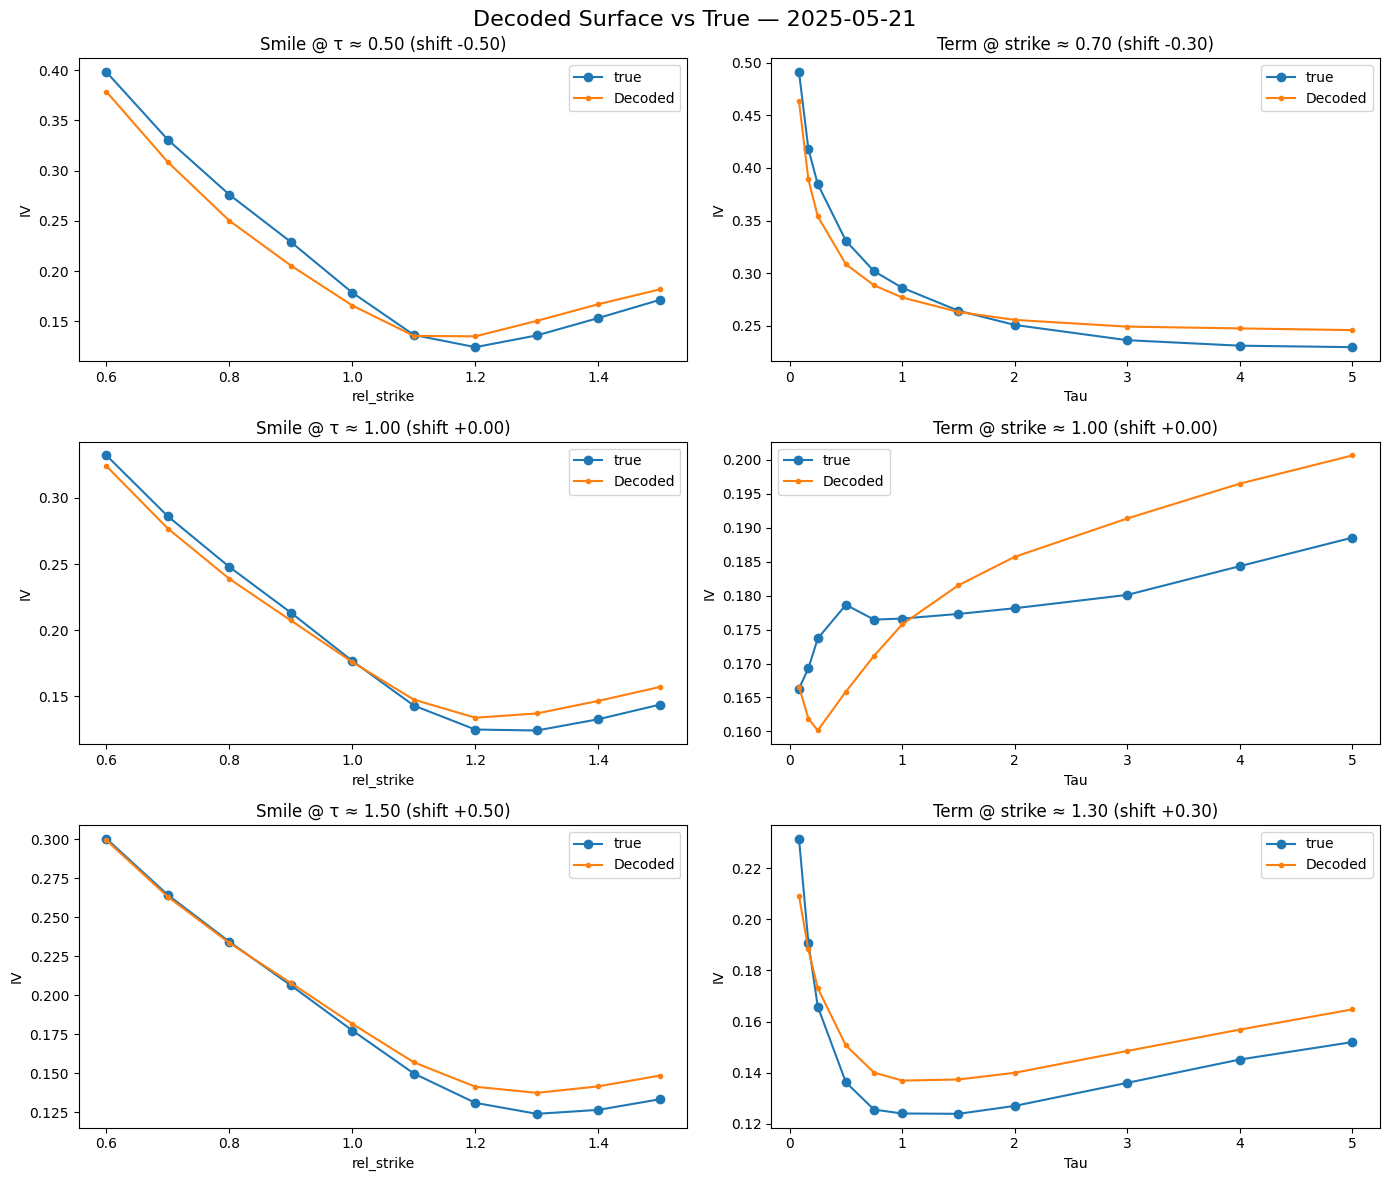

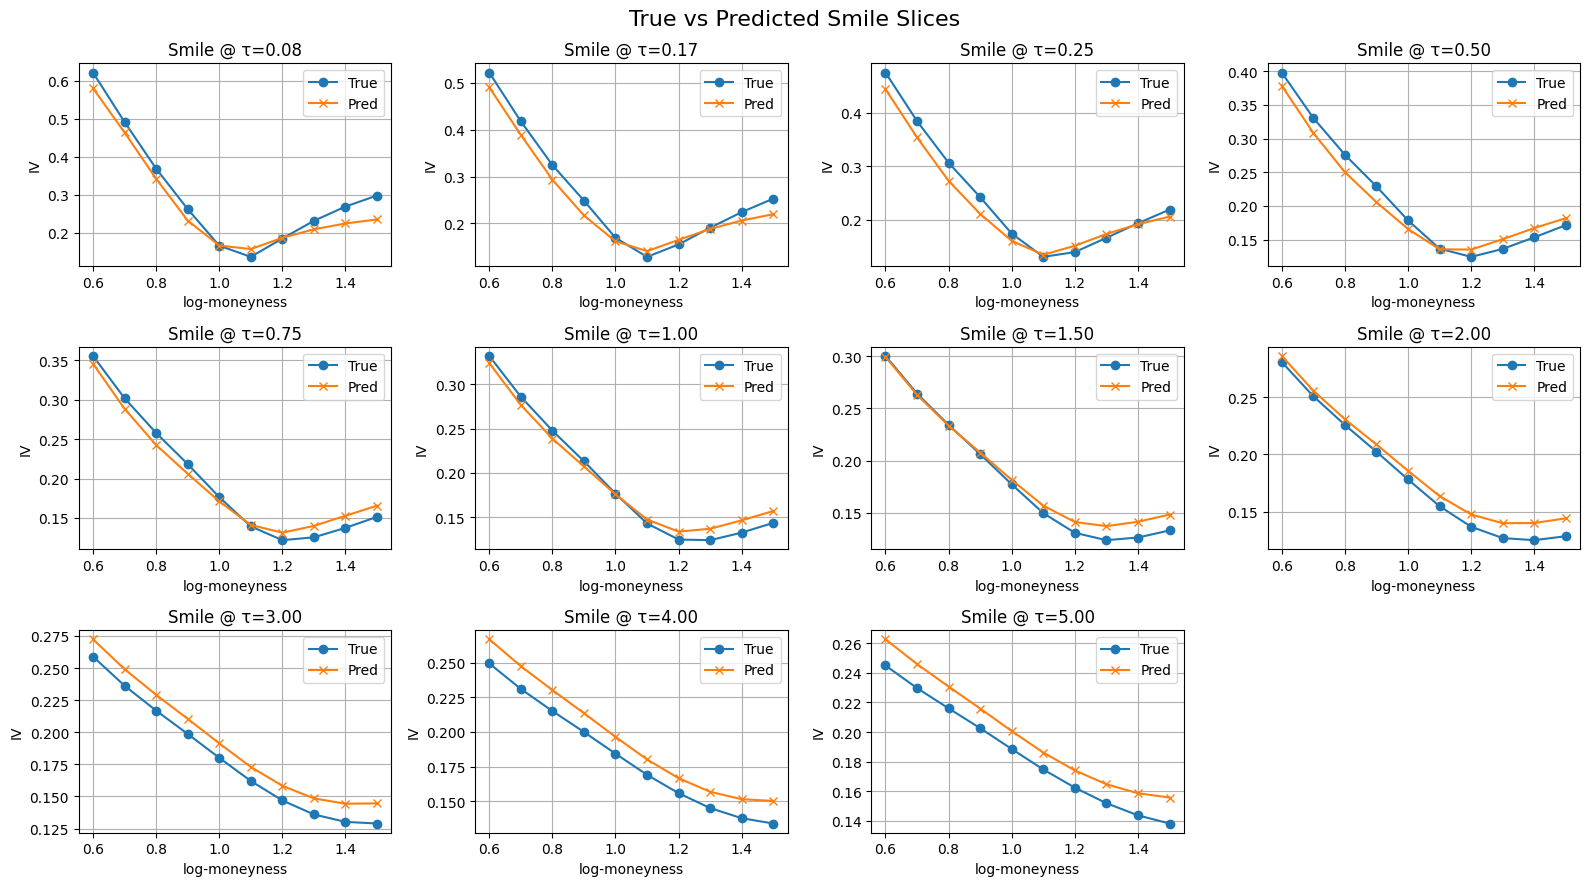

In [7]:
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from sklearn.metrics import root_mean_squared_error

# extract surface tensor and flatten
iv_surface = ops.convert_to_numpy(tensors["surface_tensor"])[..., -1]  # shape (T, M, K)
T, M, K = iv_surface.shape
X_surface_flat = iv_surface.reshape(T, M * K).astype(np.float64)

# align with features
feature_index = df_feat.index.intersection(df_all.index)
X_df = df_all.loc[feature_index, iv_cols]
F = df_feat.loc[feature_index]
X_grid = X_df.values.astype(np.float64)
F_aligned = F.values.astype(np.float64)

# demean surfaces
X_mean = X_grid.mean(axis=1, keepdims=True)
X_demeaned = X_grid - X_mean

# fit pca
pca_model = PCA(n_components=LATENT_DIM)
Z_all_pca = pca_model.fit_transform(X_demeaned)
Z_aug_pca = np.concatenate([Z_all_pca, F_aligned], axis=1)

# train test split
T_total = len(Z_aug_pca)
T_train = int(0.7 * T_total)
Z_train = Z_aug_pca[:T_train]
Z_test = Z_aug_pca[T_train:]
Z_train_pure = Z_all_pca[:T_train]

# var on augmented z
var_model = VAR(Z_train)
var_result = var_model.fit(maxlags=5)
Z_forecast_pca = var_result.forecast(Z_train[-var_result.k_ar:], steps=len(Z_test))
Z_forecast_pure = Z_forecast_pca[:, :LATENT_DIM]

# reconstruct surfaces
X_recon_demeaned = pca_model.inverse_transform(Z_forecast_pure)
X_mean_forecast = X_mean[T_train:T_train + len(X_recon_demeaned)]
X_pred_pca = X_recon_demeaned + X_mean_forecast
X_true_pca = X_grid[T_train:T_train + len(X_pred_pca)]

# calc rmse
rmse_pca = root_mean_squared_error(X_true_pca, X_pred_pca)
print(f"pca-var rmse: {rmse_pca:.4f}")

# reshape for plotting
X_true_pca = X_true_pca.reshape(-1, M, K)
X_pred_pca = X_pred_pca.reshape(-1, M, K)

from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison

# last surface for plots
true_surface_t = X_true_pca[-1]
recon_surface_t = X_pred_pca[-1]

plot_iv_slices_shifts(
    true_surface=true_surface_t,
    decoded_surface=recon_surface_t,
    taus=tensors["taus"],
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    decoded_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
)

plot_smile_slices_comparison(
    true_surface=true_surface_t,
    pred_surface=recon_surface_t,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=tensors["taus"],
)

---
---

# DATASET CREATION


---
---

In [8]:
from keras.models import load_model
from models.vae_mle import sample_z
from models.lstm import EncodedLatentSequence
from models.gru import GRUForecasterAugmented
from keras import ops
import numpy as np
from data.dataset import FeatureToLatentSequenceDataset

# load vae encoder and setup predict to return z samples
encoder = load_model(
    "saved_models/vae_mle/vae_mle_encoder.keras",
    custom_objects={"sample_z": sample_z}
)
encoder.predict = lambda x, **kwargs: encoder(x, training=False)[1]

decoder = load_model(
    "saved_models/vae_mle/vae_mle_decoder.keras",
    custom_objects={"sample_z": sample_z}
)

# setup full dataset for gru
full_dataset = FeatureToLatentSequenceDataset(
    surface_tensor=tensors["surface_tensor"],
    feature_tensor=X_feat_tensor,
    lookback=LOOKBACK,
    batch_size=BATCH_SIZE,
    global_indices=np.arange(T)
)
gru_input_gen = EncodedLatentSequence(full_dataset, encoder)

# load gru forecaster
gru_model = load_model(
    "saved_models/gru/gru_model_vae.keras",
    custom_objects={"GRUForecasterAugmented": GRUForecasterAugmented}
)

# get z(t+1) forecasts
Z_forecast_vae = gru_model.predict(gru_input_gen, verbose=0)

# optional demeaning
apply_demeaning = False
z_mean = ops.convert_to_numpy(ops.mean(Z_forecast_vae, axis=0, keepdims=True)) if apply_demeaning else 0.0
Z_forecast_demeaned = Z_forecast_vae - z_mean if apply_demeaning else Z_forecast_vae

# align surface data
X_surface_all = ops.convert_to_numpy(tensors["surface_tensor"][..., -1].reshape(T, -1))
idx_eval = ops.convert_to_numpy(full_dataset.global_indices)[-len(Z_forecast_demeaned):]

# align all dimensions
n_forecasts = Z_forecast_demeaned.shape[0]

Z_decoder = Z_forecast_demeaned
Y_decoder = X_surface_all[-n_forecasts:]  # last n surfaces
F_aligned = ops.convert_to_numpy(X_feat_tensor[-n_forecasts:])  # last n features

# check alignment
print(f"n_forecasts: {n_forecasts}")
print(f"Z_decoder shape: {Z_decoder.shape}")
print(f"Y_decoder shape: {Y_decoder.shape}")  
print(f"F_aligned shape: {F_aligned.shape}")

print(f"Z sample: {Z_decoder[0][:5]}")
print(f"F sample: {F_aligned[0][:5]}")
print(f"Y sample: {Y_decoder[0][:5]}")

# decode surfaces from latents
Y_hat = decoder.predict(Z_decoder, verbose=0)[0][:, :Y_decoder.shape[1]]  # mu only

print(f"first pred: {Y_hat[0].flatten()[:5]}")

# verify everything aligned
assert Z_decoder.shape[0] == Y_decoder.shape[0], "forecast-surface mismatch"
assert Z_decoder.shape[0] == F_aligned.shape[0], "forecast-feature mismatch"

n_forecasts: 1216
Z_decoder shape: (1216, 12)
Y_decoder shape: (1216, 110)
F_aligned shape: (1216, 136)
Z sample: [ 1.1544111   1.4090508  -0.41881314  1.4307902  -0.35425606]
F sample: [ 0.00059401  0.00421119 -0.18319322  0.00906852  0.01874819]
Y sample: [0.70493627 0.5732201  0.46057191 0.36976174 0.26840553]
first pred: [0.6796362  0.5498307  0.41438168 0.32064542 0.24350815]


In [9]:
import importlib
import data.dataset
importlib.reload(data.dataset)

from data.tensor_builder import split_time_series_indices
from keras import ops
import pandas as pd

T = tensors["surface_tensor"].shape[0]
train_idx, val_idx, test_idx = split_time_series_indices(T)

target_date = pd.Timestamp("2025-05-21")
idx = np.where(tensors["date_tensor"] == target_date)[0][0]

print("[DATE CHECK]")
print("Target global index:", idx)
print("Train:", train_idx[[0, -1]])
print("Val:", val_idx[[0, -1]])
print("Test:", test_idx[[0, -1]])
print("In test?", idx in test_idx)


[DATE CHECK]
Target global index: 1257
Train: [  0 879]
Val: [ 880 1068]
Test: [1069 1257]
In test? True


X_pred_raw shape: (1216, 110)

checking atm strike indexing
target_strike: 1.0
strike_val: 1.0
k_idx: 4
actual strike: 1.0
atm term from plot: [0.16631064 0.16929014 0.17368743 0.17863896 0.17646223 0.176611
 0.17729895 0.17813316 0.18009801 0.18432647 0.18852447]
expected atm (idx 4): [0.16631064 0.16929014 0.17368743 0.17863896 0.17646223 0.176611
 0.17729895 0.17813316 0.18009801 0.18432647 0.18852447]
match? True
VAE-GRU Decoded Surface RMSE_σ: 0.0218
RMSE by maturity (mean ± std): 0.0226 ± 0.0068
RMSE by strike    (mean ± std): 0.0231 ± 0.0046


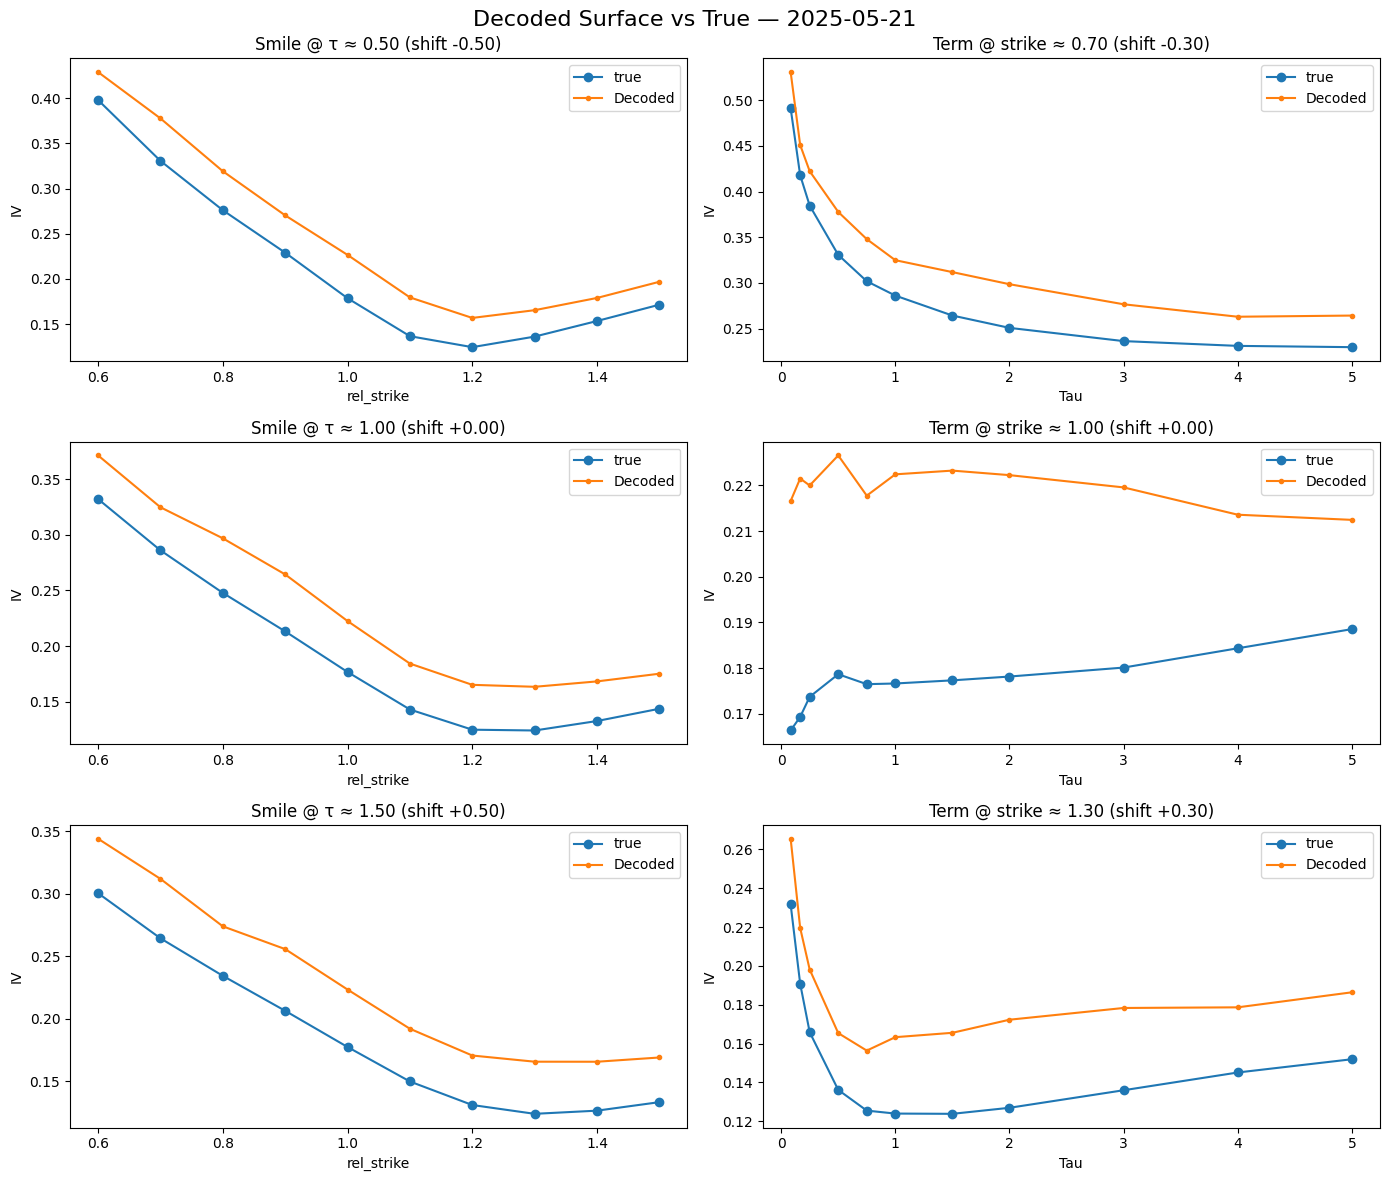

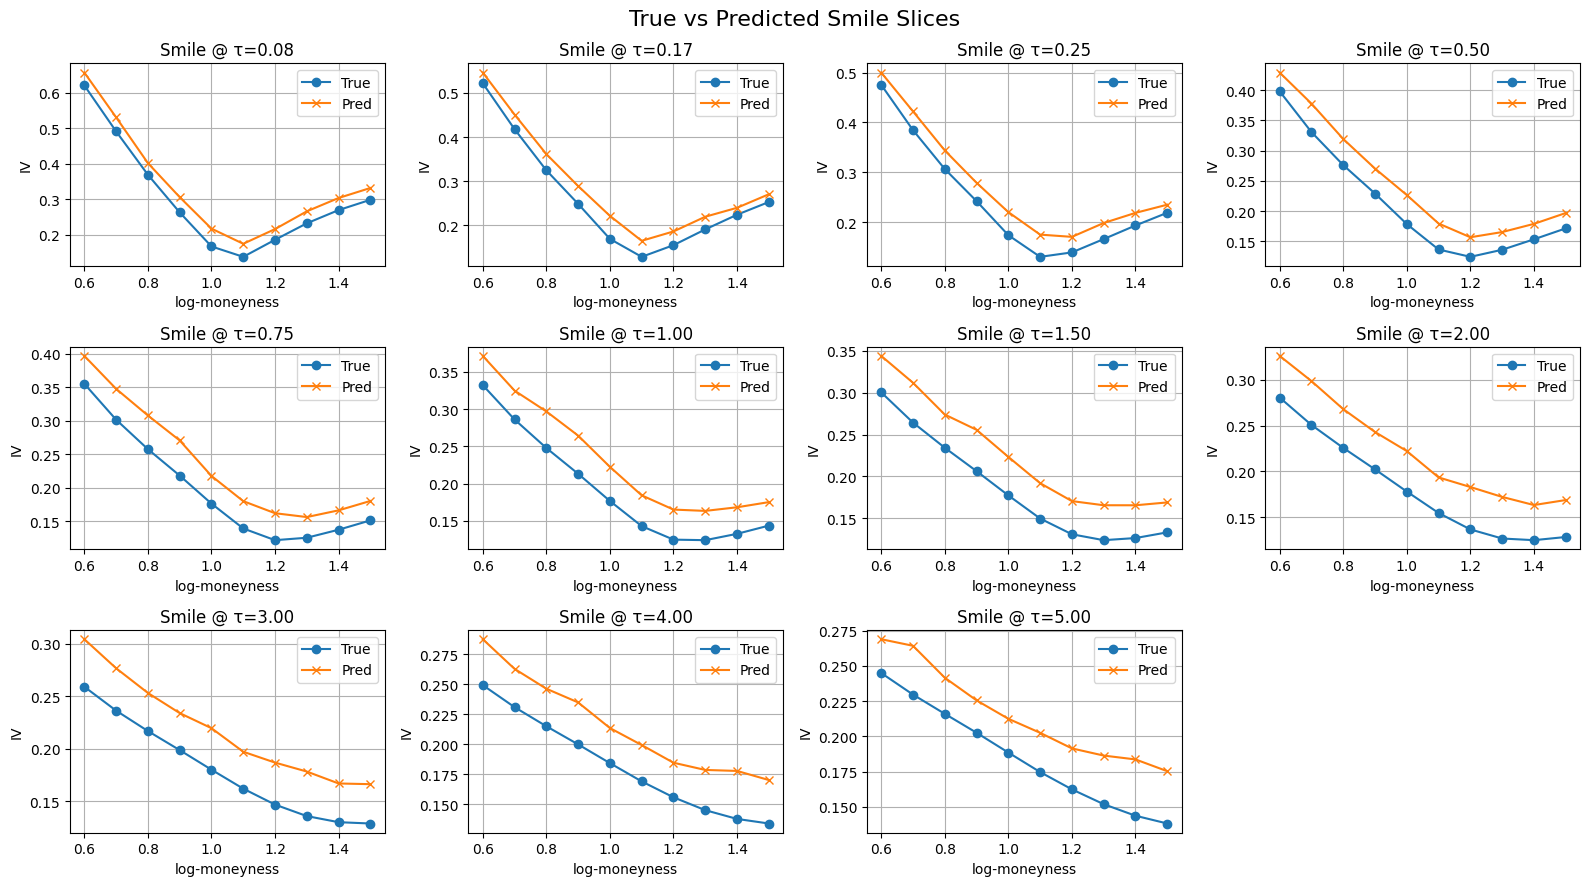

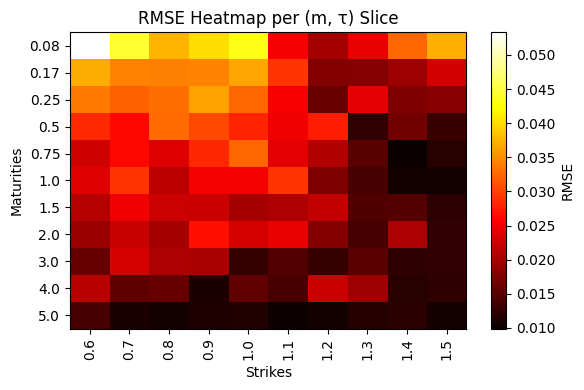

In [10]:
import importlib
import utils.eval
importlib.reload(utils.eval)
import utils.plotting
importlib.reload(utils.plotting)

from utils.eval import evaluate_decoder_output

# predict surfaces from gru forecasted latents
X_pred_raw = decoder.predict(Z_decoder, verbose=0)[0][:, :M * K]  # mu only
print("X_pred_raw shape:", X_pred_raw.shape)

# check atm indexing for plots
print("\nchecking atm strike indexing")
target_strike = TARGET_STRIKE  # should be 1.0
k_shift = 0.0  # middle term structure
strike_val = target_strike + k_shift
rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
k_idx = np.argmin(np.abs(rel_strikes - strike_val))

print(f"target_strike: {target_strike}")
print(f"strike_val: {strike_val}")
print(f"k_idx: {k_idx}")
print(f"actual strike: {rel_strikes[k_idx]}")

# compare with ground truth
Y_decoder_reshaped = Y_decoder.reshape(-1, M, K)
print(f"atm term from plot: {Y_decoder_reshaped[-1, :, k_idx]}")
print(f"expected atm (idx 4): {Y_decoder_reshaped[-1, :, 4]}")
print(f"match? {np.array_equal(Y_decoder_reshaped[-1, :, k_idx], Y_decoder_reshaped[-1, :, 4])}")

# evaluate against aligned targets
evaluate_decoder_output(
   decoder=decoder,
   Z_forecast=Z_decoder,
   X_grid=Y_decoder,
   X_true_idx=None,
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoded_surfaces_override=X_pred_raw,
   title="VAE-GRU Decoded Surface"
)

---
---

# POINTWISE DECODER 

---
---

In [11]:
import models.decoder
import importlib
importlib.reload(models.decoder)

from models.decoder import PiecewiseSurfaceDecoder
from keras.optimizers import Adam

# check data shapes
print(f"Z_decoder shape: {Z_decoder.shape}")
print(f"F_aligned shape: {F_aligned.shape}")
print(f"Y_decoder shape: {Y_decoder.shape}")
print(f"LATENT_DIM: {LATENT_DIM}")
print(f"M: {M}, K: {K}")

# setup feature-aware decoder
decoder_pw = PiecewiseSurfaceDecoder(
   latent_dim=LATENT_DIM,
   M=M,
   K=K,
   feature_dim=F_aligned.shape[1]  # includes f_t
)
print(f"decoder feature_dim: {decoder_pw.feature_dim}")
print(f"expected input dim: {LATENT_DIM + F_aligned.shape[1] + 2}")  # +2 for m,tau

decoder_pw.compile(optimizer=Adam(learning_rate=5e-5), loss="mse")

# prepare grids
rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
taus = ops.convert_to_numpy(tensors["taus"])
print(f"rel_strikes shape: {rel_strikes.shape}")
print(f"taus shape: {taus.shape}")

# reshape targets
Y_surface_full = Y_decoder.reshape(-1, M * K)
print(f"Y_surface_full shape: {Y_surface_full.shape}")

# split data
N_total = len(Z_decoder)
train_split = int(0.7 * N_total)
val_split = int(0.85 * N_total)

Z_train, Z_val, Z_test = np.split(Z_decoder, [train_split, val_split])
F_train, F_val, F_test = np.split(F_aligned, [train_split, val_split])
Y_train, Y_val, Y_test = np.split(Y_surface_full, [train_split, val_split])

print(f"\nsplit shapes:")
print(f"train: Z {Z_train.shape}, F {F_train.shape}, Y {Y_train.shape}")
print(f"val: Z {Z_val.shape}, F {F_val.shape}, Y {Y_val.shape}")
print(f"test: Z {Z_test.shape}, F {F_test.shape}, Y {Y_test.shape}")

# build training data from surfaces
[X_zf_train, X_m_train, X_tau_train], y_train = decoder_pw.build_training_data_from_surfaces(
   Z_train, Y_train, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_train
)
[X_zf_val, X_m_val, X_tau_val], y_val = decoder_pw.build_training_data_from_surfaces(
   Z_val, Y_val, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_val
)
[X_zf_test, X_m_test, X_tau_test], y_test = decoder_pw.build_training_data_from_surfaces(
   Z_test, Y_test, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_test
)

print(f"\ntraining data shapes:")
print(f"X_zf_train: {X_zf_train.shape}")
print(f"X_m_train: {X_m_train.shape}")
print(f"X_tau_train: {X_tau_train.shape}")
print(f"y_train: {y_train.shape}")

# keras input setup
X_train = [X_zf_train, X_m_train, X_tau_train]
X_val   = [X_zf_val,   X_m_val,   X_tau_val]
X_test  = [X_zf_test,  X_m_test,  X_tau_test]

print(f"\nfinal inputs:")
print(f"X_train[0] (zf): {X_train[0].shape}")
print(f"X_train[1] (m): {X_train[1].shape}")
print(f"X_train[2] (tau): {X_train[2].shape}")

Z_decoder shape: (1216, 12)
F_aligned shape: (1216, 136)
Y_decoder shape: (1216, 110)
LATENT_DIM: 12
M: 11, K: 10
decoder feature_dim: 136
expected input dim: 150
rel_strikes shape: (10,)
taus shape: (11,)
Y_surface_full shape: (1216, 110)

split shapes:
train: Z (851, 12), F (851, 136), Y (851, 110)
val: Z (182, 12), F (182, 136), Y (182, 110)
test: Z (183, 12), F (183, 136), Y (183, 110)

training data shapes:
X_zf_train: (93610, 148)
X_m_train: (93610, 1)
X_tau_train: (93610, 1)
y_train: (93610, 1)

final inputs:
X_train[0] (zf): (93610, 148)
X_train[1] (m): (93610, 1)
X_train[2] (tau): (93610, 1)


In [12]:
# check temporal ordering
print("first few Z_decoder indices (should be early dates):")
print(f"Z_decoder[0:5] shape: {Z_decoder[0:5].shape}")

print("\nlast few Z_decoder indices (should be late dates):")
print(f"Z_decoder[-5:] shape: {Z_decoder[-5:].shape}")

# check split boundaries
print(f"\nsplit boundaries:")
print(f"train: 0 to {train_split}")
print(f"val: {train_split} to {val_split}")  
print(f"test: {val_split} to {N_total}")

# check original data source
print(f"\noriginal idx_eval from gru:")
print(f"idx_eval[:10]: {idx_eval[:10]}")
print(f"idx_eval[-10:]: {idx_eval[-10:]}")
print(f"total time steps T: {T}")

# verify sequential
is_sequential = np.all(np.diff(idx_eval) == 1)
print(f"idx_eval is sequential: {is_sequential}")

first few Z_decoder indices (should be early dates):
Z_decoder[0:5] shape: (5, 12)

last few Z_decoder indices (should be late dates):
Z_decoder[-5:] shape: (5, 12)

split boundaries:
train: 0 to 851
val: 851 to 1033
test: 1033 to 1216

original idx_eval from gru:
idx_eval[:10]: [42 43 44 45 46 47 48 49 50 51]
idx_eval[-10:]: [1248 1249 1250 1251 1252 1253 1254 1255 1256 1257]
total time steps T: 1258
idx_eval is sequential: True


In [13]:
import importlib
import models.decoder_losses
importlib.reload(models.decoder_losses)
from models.decoder_losses import create_black_scholes_hybrid_loss, create_mse_vega_hybrid_loss    


hybrid_loss_fn, vega_weights, gamma_weights = create_black_scholes_hybrid_loss(
    taus, rel_strikes, M, K, 
    mse_weight=0.5, vega_weight=0.2, gamma_weight=0.3
)

decoder_pw.compile(
    optimizer=Adam(learning_rate=1e-5, clipnorm=1),
    loss=hybrid_loss_fn
)


Epoch 1/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 4.8842 - val_loss: 0.3462 - learning_rate: 1.0000e-05
Epoch 2/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.2615 - val_loss: 0.2675 - learning_rate: 1.0000e-05
Epoch 3/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.2251 - val_loss: 0.2644 - learning_rate: 1.0000e-05
Epoch 4/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.2015 - val_loss: 0.2515 - learning_rate: 1.0000e-05
Epoch 5/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.1920 - val_loss: 0.2392 - learning_rate: 1.0000e-05
Epoch 6/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.1800 - val_loss: 0.2305 - learning_rate: 1.0000e-05
Epoch 7/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.1683 - val_loss: 0.2102 - learning_rate: 1.0000e-05
Epoch 8/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.1543 - val_loss: 0.1903 - learning_rate: 1.0000e-05
Epoch 9/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step

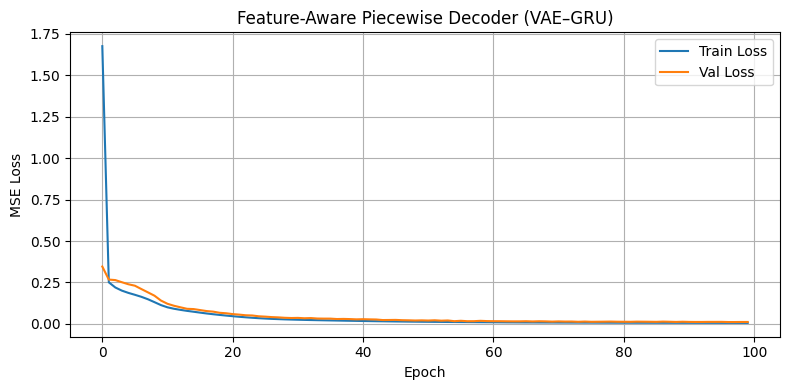

In [14]:
import os
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# callbacks
os.makedirs("saved_models/vae/piecewise_surface", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=5e-5, verbose=0),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=5, min_lr=1e-7),
    ModelCheckpoint("saved_models/vae/piecewise_surface/decoder_bs_loss.keras", save_best_only=True)
]


history = decoder_pw.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)
#plot
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Feature-Aware Piecewise Decoder (VAE–GRU)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Y_hat shape: (1216, 11, 10)
Y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
Piecewise Decoder with BS Loss with VAE RMSE_σ: 0.0081
RMSE by maturity (mean ± std): 0.0083 ± 0.0045
RMSE by strike    (mean ± std): 0.0093 ± 0.0018
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


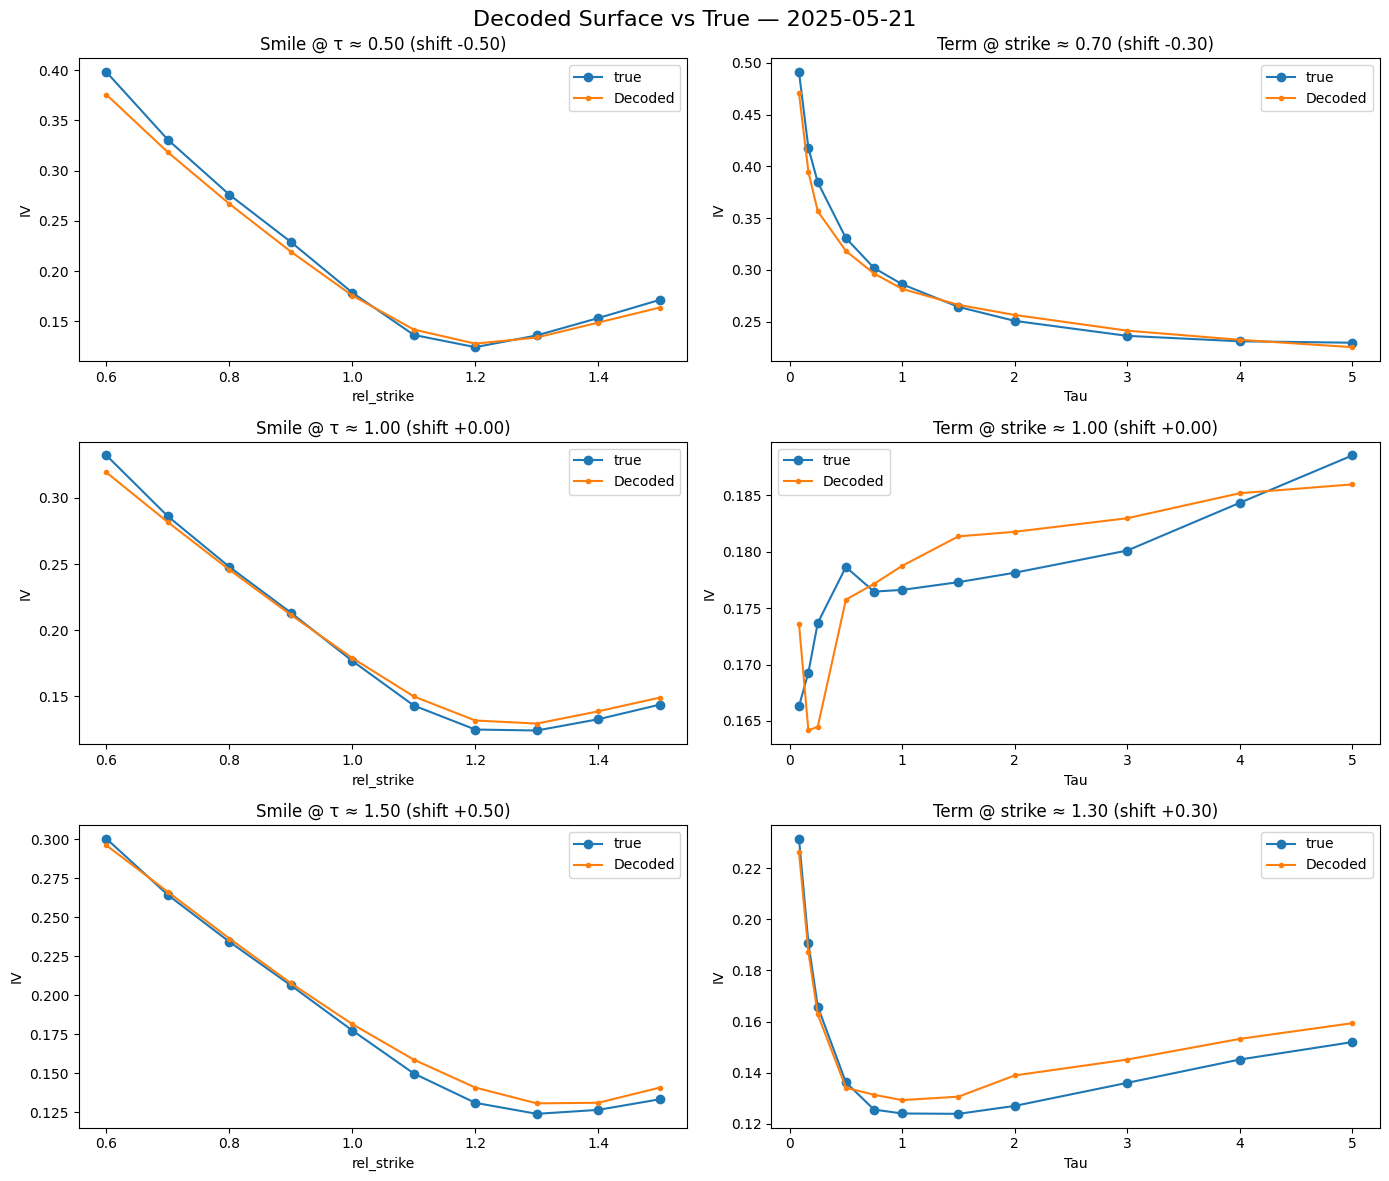

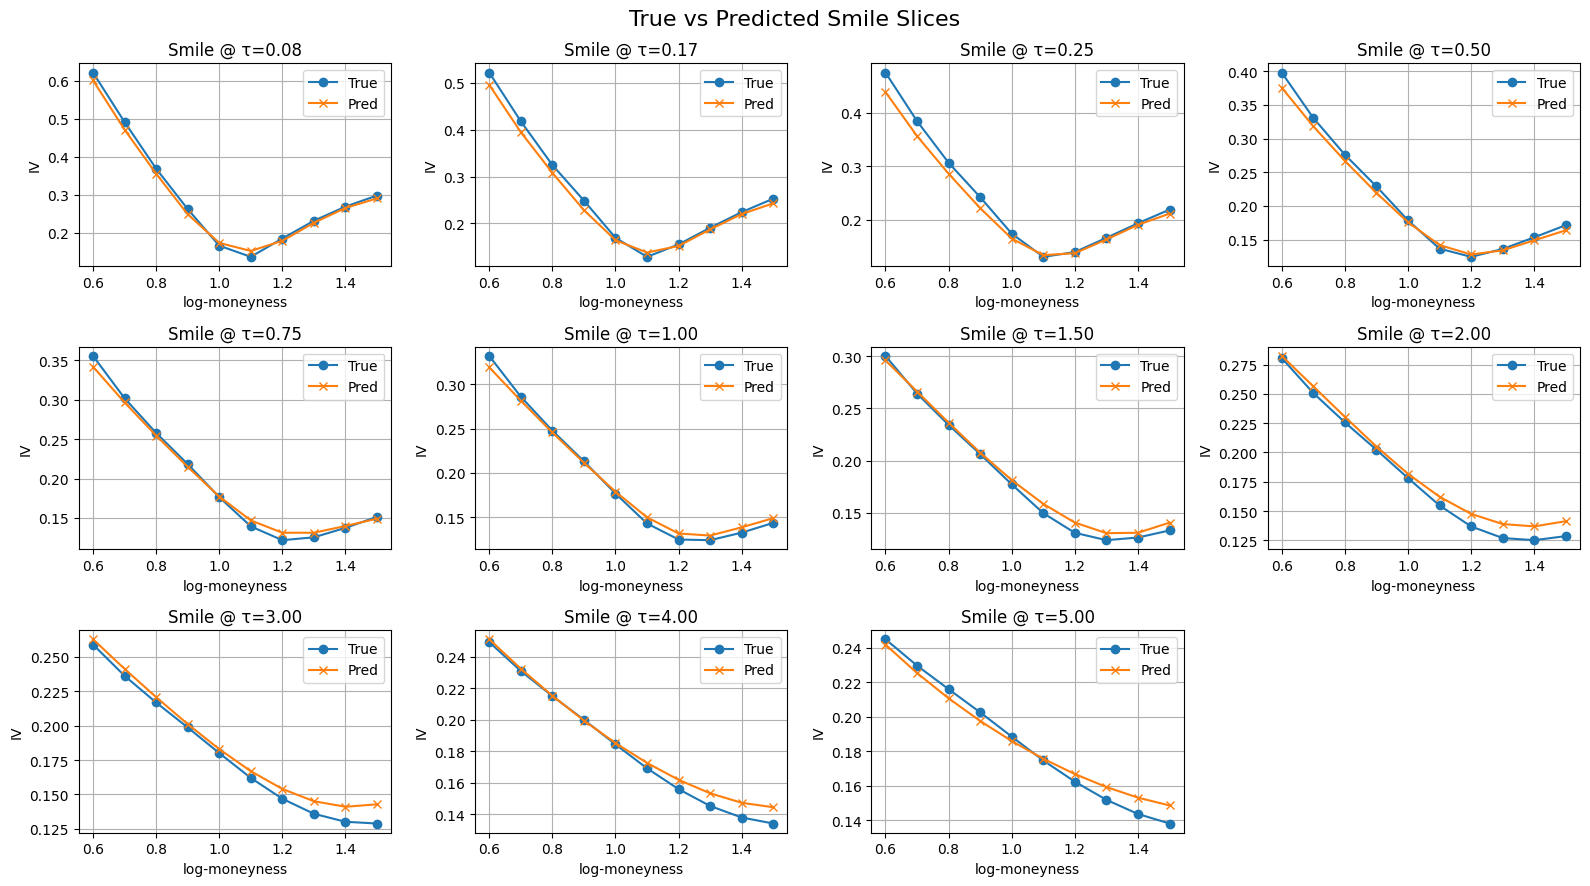

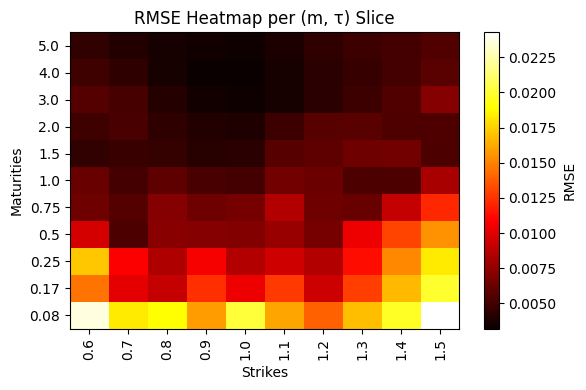

{'rmse_overall': 0.008091042,
 'rmse_by_maturity': array([0.01903955, 0.01321237, 0.01235161, 0.00944047, 0.00766674,
        0.00597445, 0.00523892, 0.00495652, 0.00483405, 0.00434412,
        0.0043009 ], dtype=float32),
 'rmse_by_strike': array([0.0110822 , 0.00824815, 0.00816731, 0.00800072, 0.00836826,
        0.00842355, 0.00738556, 0.00902673, 0.010996  , 0.01329875],
       dtype=float32)}

In [15]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike-tau grid
m_grid, tau_grid = np.meshgrid(
   ops.convert_to_numpy(tensors["strike_tensor"]),
   ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
   decoder_pw.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

print(f"Y_hat shape: {Y_hat.shape}")
print(f"Y_full shape: {Y_full.shape}")

# evaluate with new function
evaluate_decoder_output_v2(
    Y_pred=Y_hat,                          # pre-computed predictions (N, M, K)
    Y_true=Y_full,                         # ground truth (N, M*K) auto-reshaped
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw,                    # for penalty calc
    title="Piecewise Decoder with BS Loss with VAE"
)

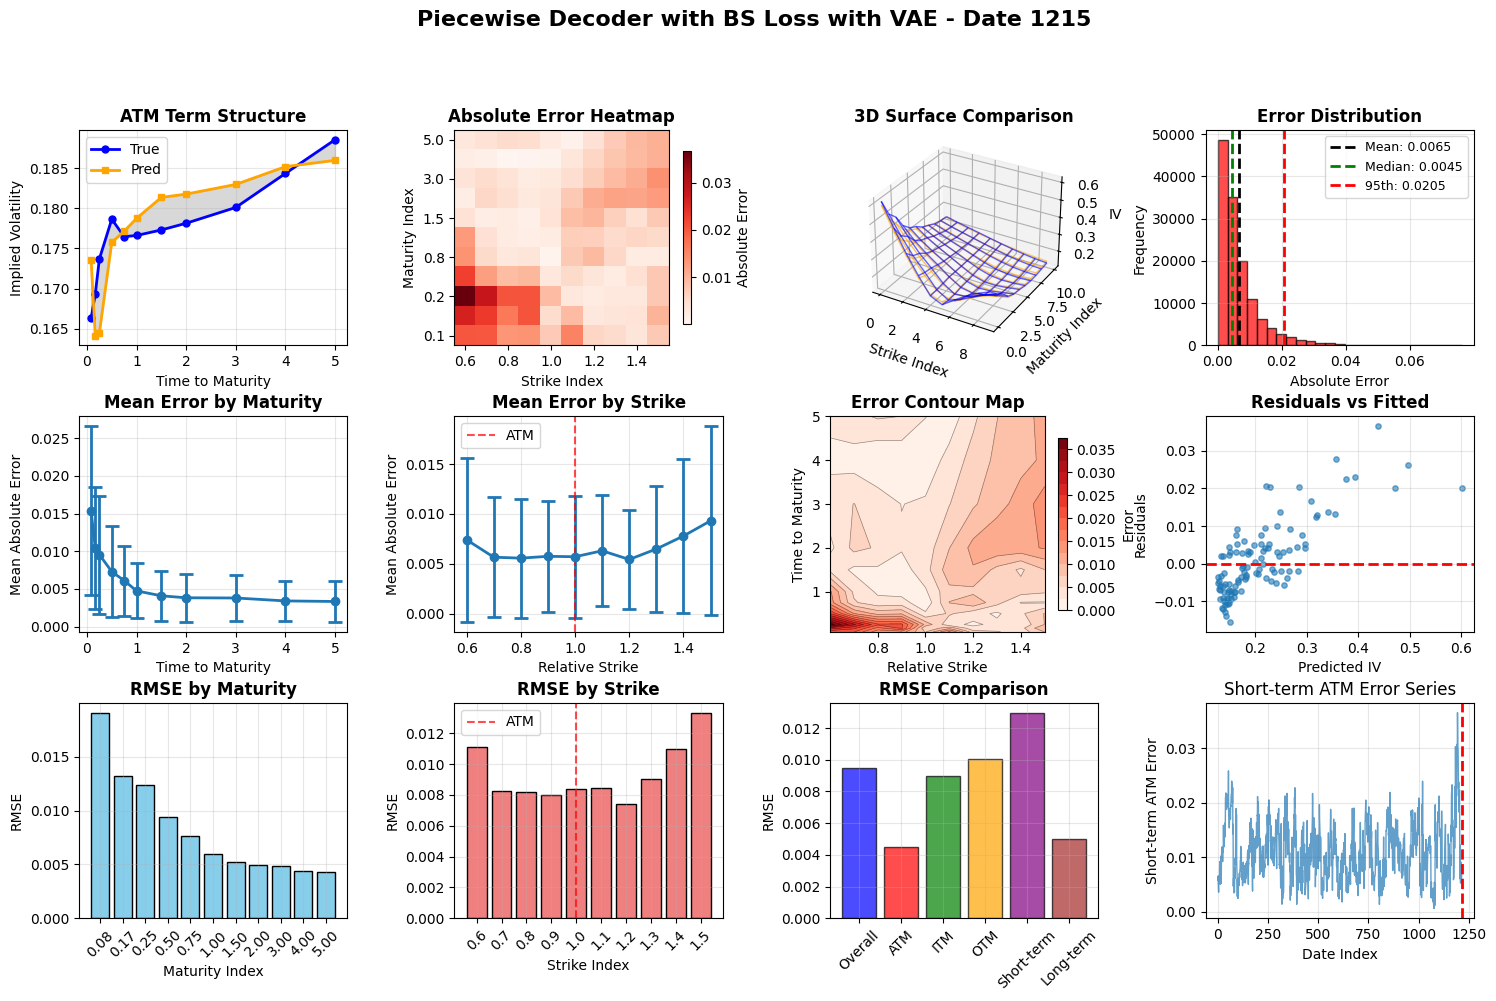

Overall Performance Category Performance  \
RMSE                           0.009468                  NaN   
MAE                            0.006539                  NaN   
Max Error                      0.076149                  NaN   
Mean Error                     0.006539                  NaN   
Median Error                   0.004453                  NaN   
95th Percentile                0.020508                  NaN   
ATM RMSE                            NaN             0.004499   
ITM RMSE                            NaN             0.008966   
OTM RMSE                            NaN             0.010047   
Short-term RMSE                     NaN             0.012942   
Long-term RMSE                      NaN             0.004974   
Short/Long Ratio                    NaN                2.602   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.004301)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.019040)                       NaN  
Best Strike           K=1.2 (RMSE: 0.007386)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.013299)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.008368)                       NaN  
Overall Rank              ATM ranks #5 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.602)  
ATM Issues                               NaN   NO (ATM/Overall: 0.48x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.001081)  
High Error Variance                      NaN       YES (std: 0.006847)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [16]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened

# setup grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run comprehensive analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,              
  Y_pred=Y_hat,               
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,                # last date
  dates=None,                 
  title="Piecewise Decoder with BS Loss with VAE"
)

In [17]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries



summary_pw_decoder = summarize_decoder_errors(
    Y_true=Y_full, 
    Y_pred=Y_hat,
    taus=taus, 
    rel_strikes=rel_strikes,
    name="Piecewise Decoder with BS Loss",
    model=decoder_pw
)


summary_all_decoders = collect_decoder_summaries(
    summary_pw_decoder,
   
)

display(summary_all_decoders)

Name  Rank Overall_RMSE Overall_MAE  ATM_RMSE  \
0  Piecewise Decoder with BS Loss     1     0.009468    0.006539  0.008368   

    ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio Max_Error  Short_Term_Bias  \
0  0.005707  0.008966  0.010047         2.602015  0.076149             True   

   ATM_Issues Model_Quality  Production_Ready  
0       False     EXCELLENT             False

smoothing impact: 0.004239
Evaluation dimensions: N=10, M=11, K=10
Smoothed Piecewise Decoder (Feature-Aware) RMSE_σ: 0.0140
RMSE by maturity (mean ± std): 0.0169 ± 0.0130
RMSE by strike    (mean ± std): 0.0182 ± 0.0111
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


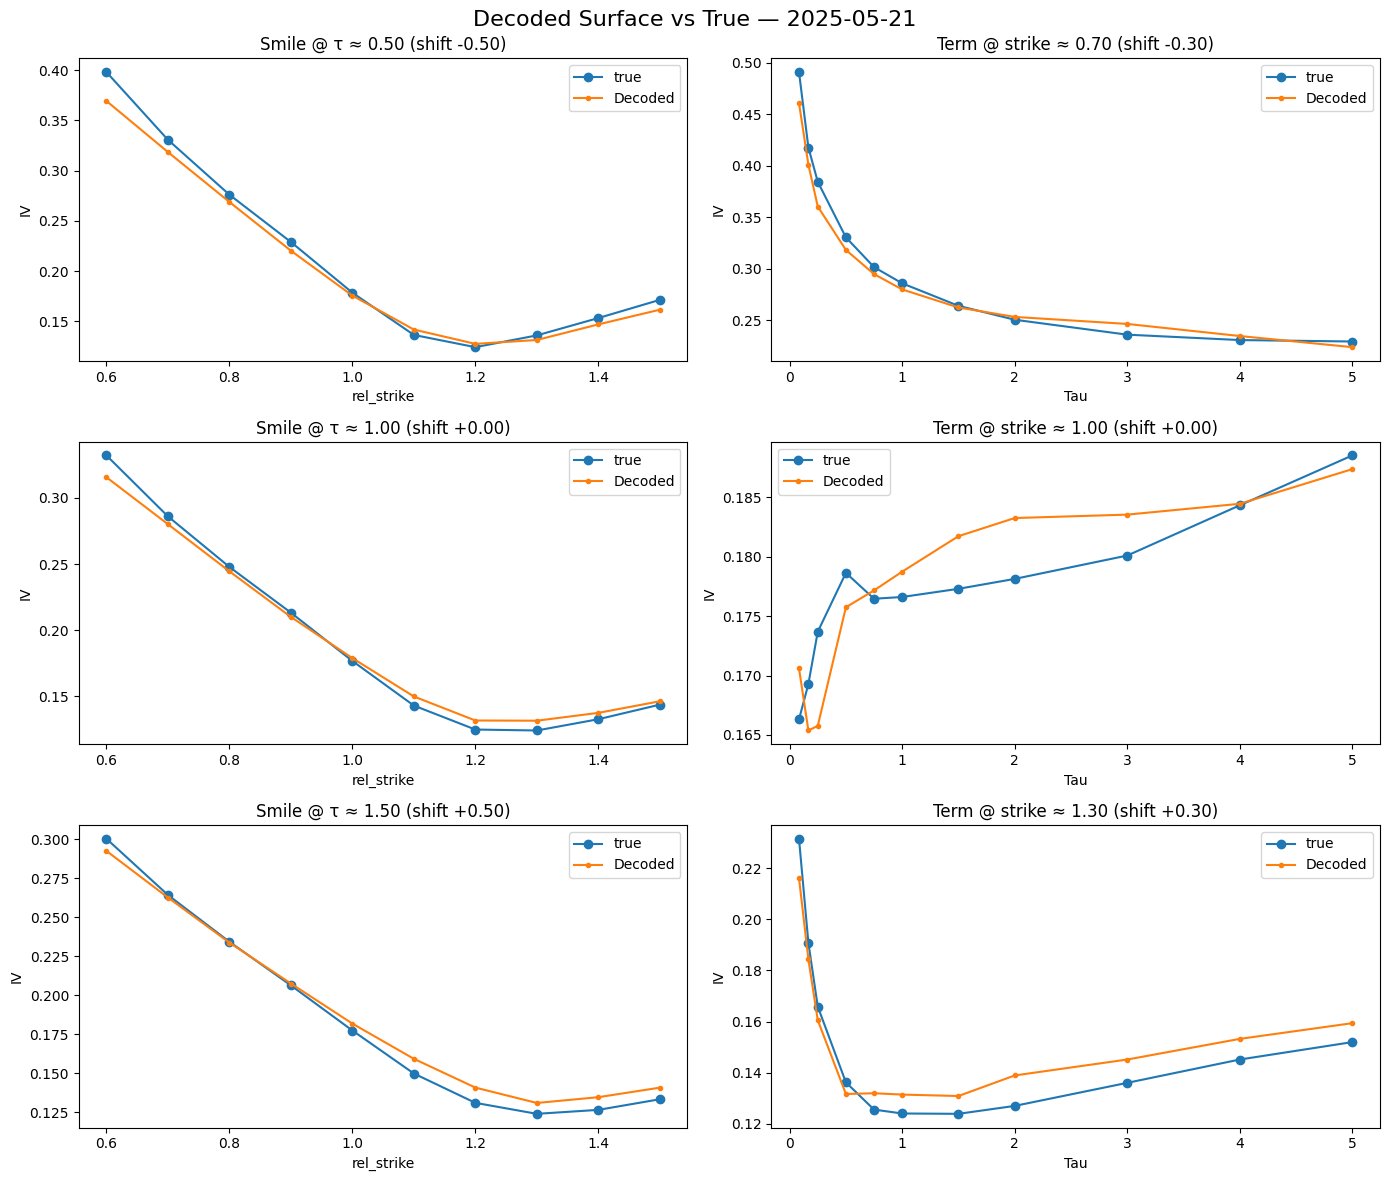

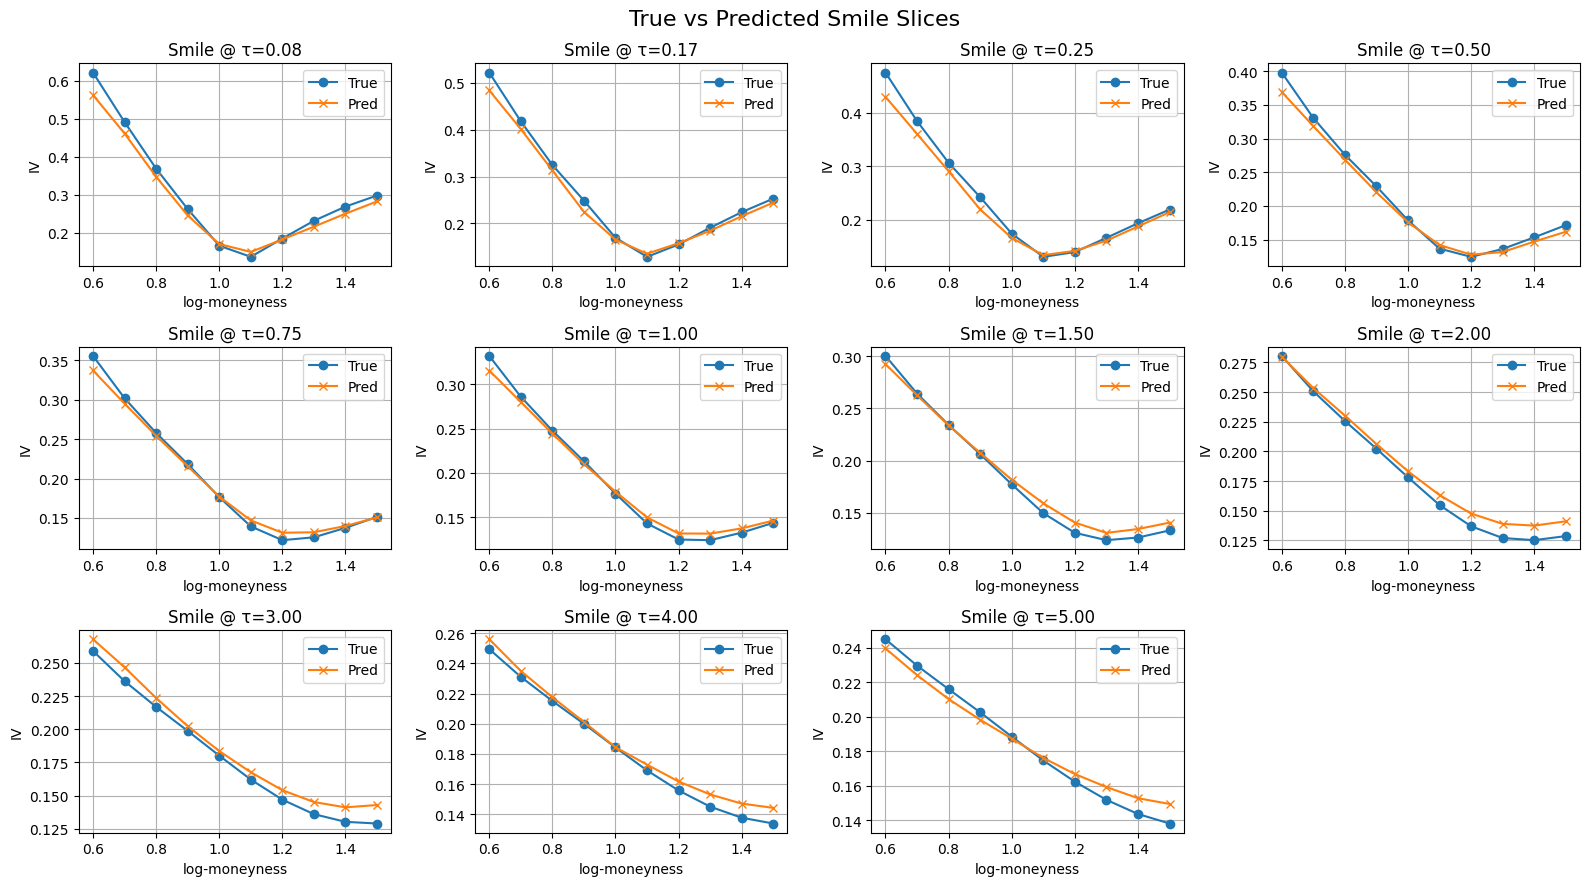

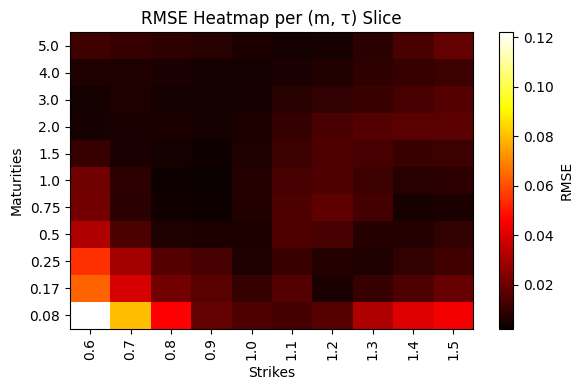

{'rmse_overall': 0.014035095924051295,
 'rmse_by_maturity': array([0.0537991 , 0.02703607, 0.02180637, 0.01375722, 0.01133836,
        0.0109731 , 0.00982887, 0.01101821, 0.0089257 , 0.00725774,
        0.01017936]),
 'rmse_by_strike': array([0.04681231, 0.02920237, 0.01661487, 0.00923397, 0.00753866,
        0.01145106, 0.01196613, 0.01413272, 0.01615841, 0.01848332])}

In [18]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# config
SMOOTH_ALL = False
N_surfaces = 10

# select data subset
Z_eval = Z_decoder if SMOOTH_ALL else Z_decoder[-N_surfaces:]
F_eval = F_aligned if SMOOTH_ALL else F_aligned[-N_surfaces:]
Y_true = Y_decoder if SMOOTH_ALL else Y_decoder[-N_surfaces:]

# use raw predictions from Y_hat
Y_pred_raw = Y_hat if SMOOTH_ALL else Y_hat[-N_surfaces:]

# apply smoothing
Y_pred_smooth = np.stack([
   decoder_pw.refine_surface(surf, lambda_cal=0.2, lambda_smile=0.1)
   for surf in Y_pred_raw
])

# check smoothing impact
smoothing_impact = np.mean(np.abs(Y_pred_smooth - Y_pred_raw))
print(f"smoothing impact: {smoothing_impact:.6f}")

# evaluate smoothed predictions
evaluate_decoder_output_v2(
   Y_pred=Y_pred_smooth,                   # (N, M, K)
   Y_true=Y_true,                          # (N, M*K)
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=decoder_pw,                     
   title="Smoothed Piecewise Decoder (Feature-Aware)"
)

---
---

### FINAL POINTWISE DECDOER WITH MOE OPTION 

---
---

#### Experiment 1 

In [ ]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import torch

# choose moe or standard mode
USE_MOE = True  # false for standard decoder comparison

print(f"training {'moe' if USE_MOE else 'standard'} modular decoder")

# setup modular pointwise decoder
decoder_pw_mod = PiecewiseSurfaceDecoderModular(
    latent_dim=LATENT_DIM,
    M=M, K=K, taus=taus,
    feature_dim=F_aligned.shape[1],
    activation="gelu",
    use_moe=True,
    num_experts=7,                    # increase experts
    
    # ultra short-term focus
    maturity_experts=4,               # 4 maturity specialists
    free_experts=3,                   # 3 free experts
    maturity_specialization=True,
    
    # disable atm bias (not the problem)
    atm_specialization=False,         # atm issues disabled
    atm_loss_weight=1.0,
    
    # higher diversity to force expert usage
    lambda_diversity=0.75,
)

decoder_pw_mod.compile(optimizer=Adam(learning_rate=5e-5, clipnorm=1.0), loss=hybrid_loss_fn)

# training callbacks
model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/vae/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, min_delta=1e-5),
    ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=4, min_lr=1e-7),
    ModelCheckpoint(f"saved_models/vae/piecewise_surface_mod_{model_suffix}/decoder_final.keras", save_best_only=True, verbose=0)
]

# fit model
history = decoder_pw_mod.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=150,
    callbacks=callbacks,
    verbose=1
)

print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

# plot training history
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title(f"{'moe' if USE_MOE else 'standard'} modular decoder training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
    plt.subplot(1, 2, 2)
    # analyze expert gating patterns
    analysis = decoder_pw_mod.analyze_gating(X_val)
    if analysis is not None:
        plt.bar(range(decoder_pw_mod.num_experts), analysis['expert_activations'])
        plt.title("expert activation patterns")
        plt.xlabel("expert id")
        plt.ylabel("average activation")
        plt.xticks(range(decoder_pw_mod.num_experts))
        
        print(f"\nexpert analysis:")
        print(f"  expert activations: {analysis['expert_activations']}")
        print(f"  average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

training moe modular decoder
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 98s 33ms/step - loss: 3.7639 - val_loss: 1.1110 - learning_rate: 5.0000e-05
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 110s 38ms/step - loss: 0.8217 - val_loss: 0.4063 - learning_rate: 5.0000e-05
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 108s 37ms/step - loss: 0.2869 - val_loss: 0.1845 - learning_rate: 5.0000e-05
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 102s 35ms/step - loss: 0.1530 - val_loss: 0.1300 - learning_rate: 5.0000e-05
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 102s 35ms/step - loss: 0.1076 - val_loss: 0.0937 - learning_rate: 5.0000e-05
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 107s 37ms/step - loss: 0.0829 - val_loss: 0.0763 - learning_rate: 5.0000e-05
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 102s 35ms/step - loss: 0.0672 - val_loss: 0.0664 - learning_rate: 5.0000e-05
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 104s 35ms/step - loss: 0.0570 - val

In [1]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike-tau grid
m_grid, tau_grid = np.meshgrid(
   ops.convert_to_numpy(tensors["strike_tensor"]),
   ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
   decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

print(f"Y_hat shape: {Y_hat.shape}")
print(f"Y_full shape: {Y_full.shape}")

# evaluate using new function
evaluate_decoder_output_v2(
    Y_pred=Y_hat,                          # pre-computed predictions (N, M, K)
    Y_true=Y_full,                         # ground truth (N, M*K) auto-reshaped
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw_mod,                # for penalty calc
    title="MoE Piecewise Decoder with BS Loss with VAE"
)

ModuleNotFoundError: No module named 'models'

🔍 MoE Training Analysis
📊 Experts: 6
🎯 ATM Specialization: False
⚖️ Diversity λ: 0.25
💪 ATM Expert Bias: 2.0
--------------------------------------------------


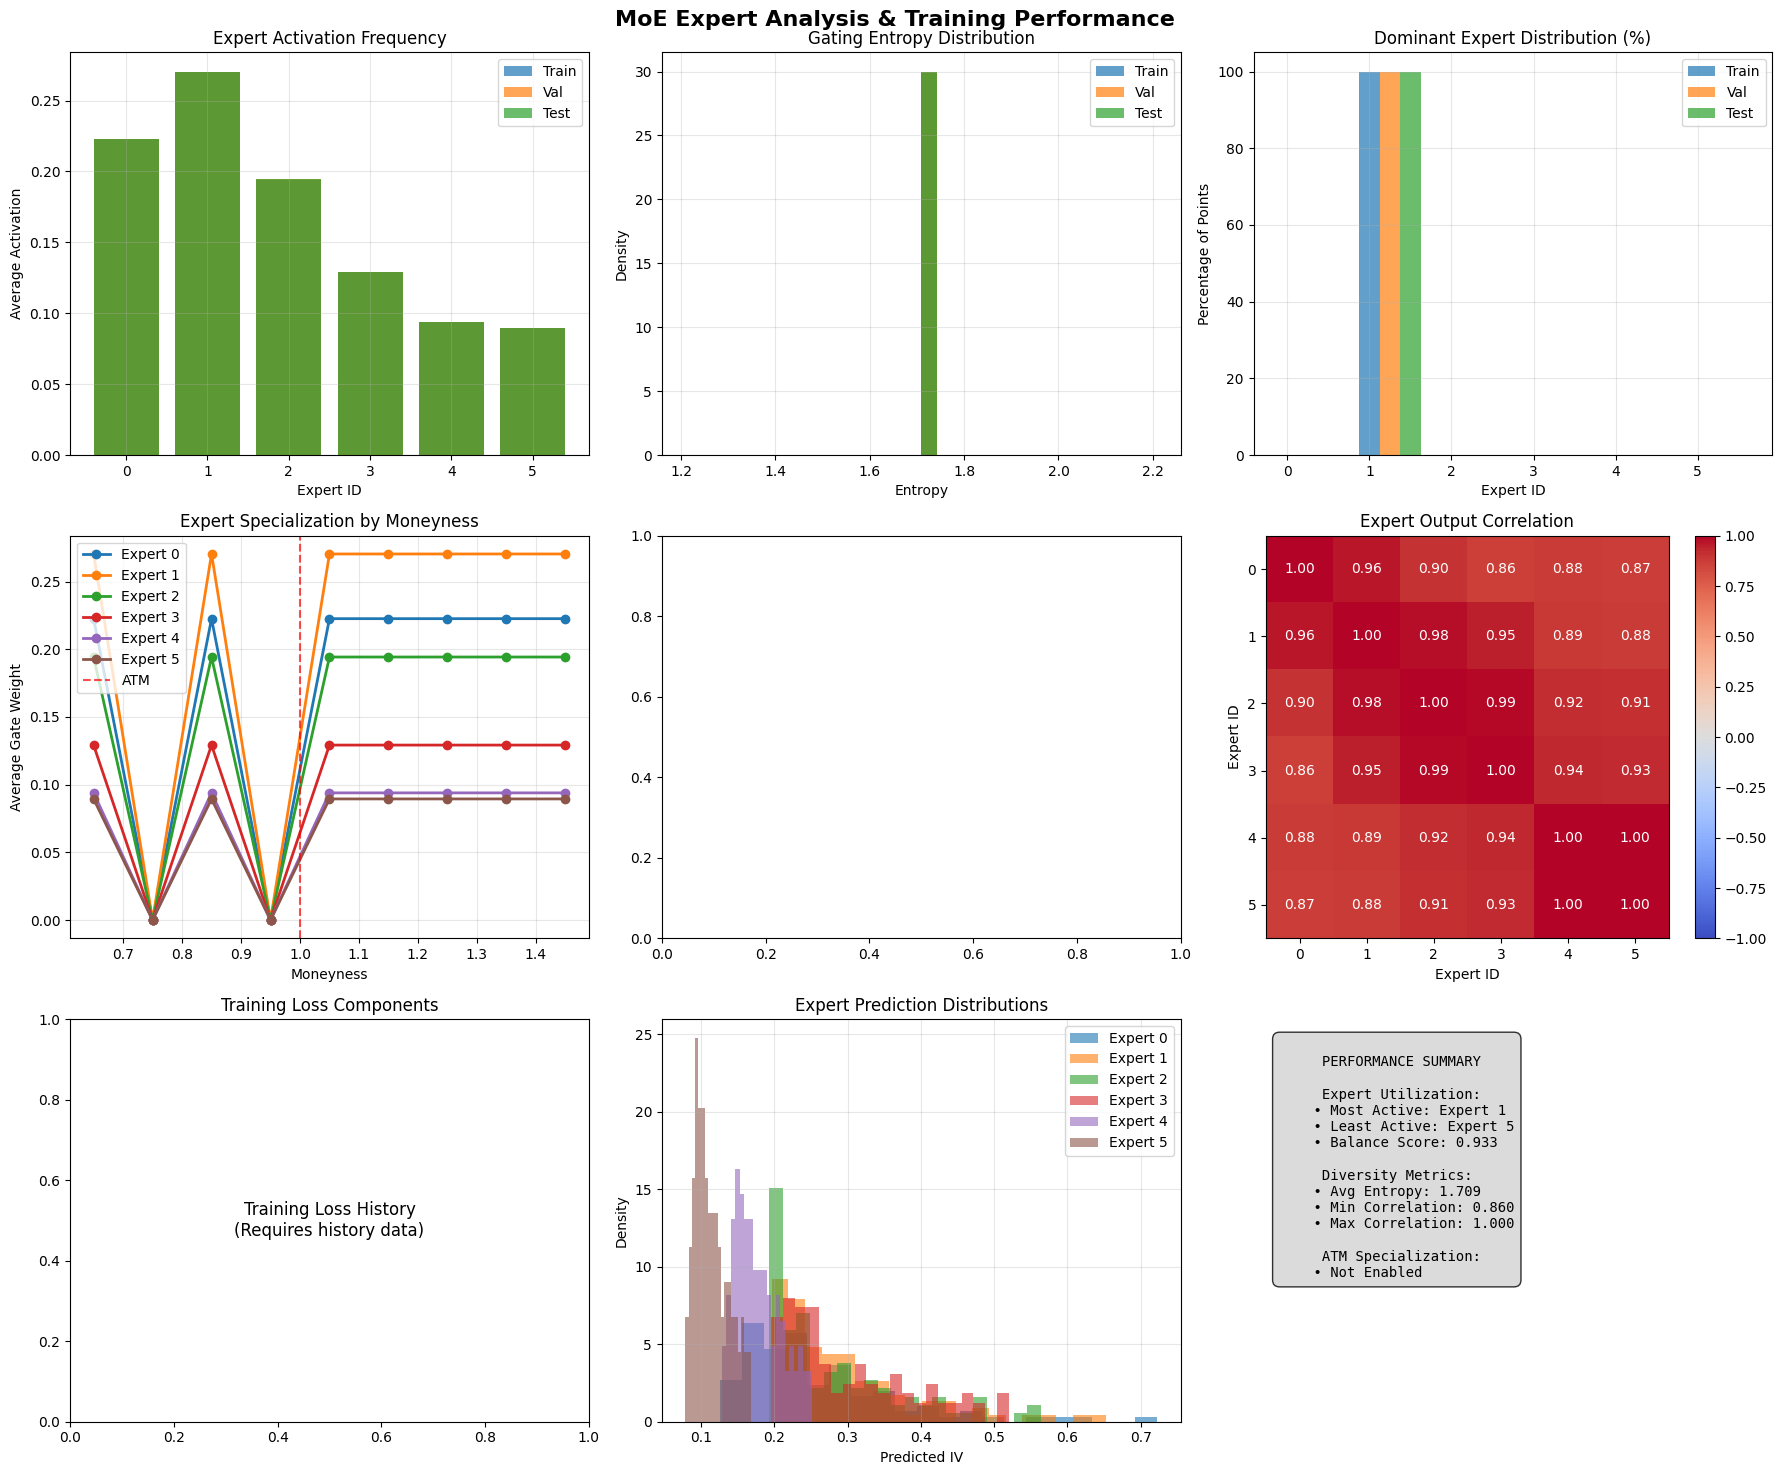


📊 DETAILED ANALYSIS:
Expert Activations: [0.22265385 0.2701534  0.19423626 0.12917367 0.09385797 0.08945552]
Average Entropy: 1.7090
Expert Balance (1-std): 0.9326


In [ ]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance

# analyze moe performance
results = analyze_moe_training_performance(
   decoder_pw_mod,    # moe decoder
   X_train,           # training inputs [z+f, strikes, taus]
   X_val,             # validation inputs
   X_test,            # test inputs  
   y_train,           # training targets
   y_val,             # validation targets
   y_test             # test targets
)

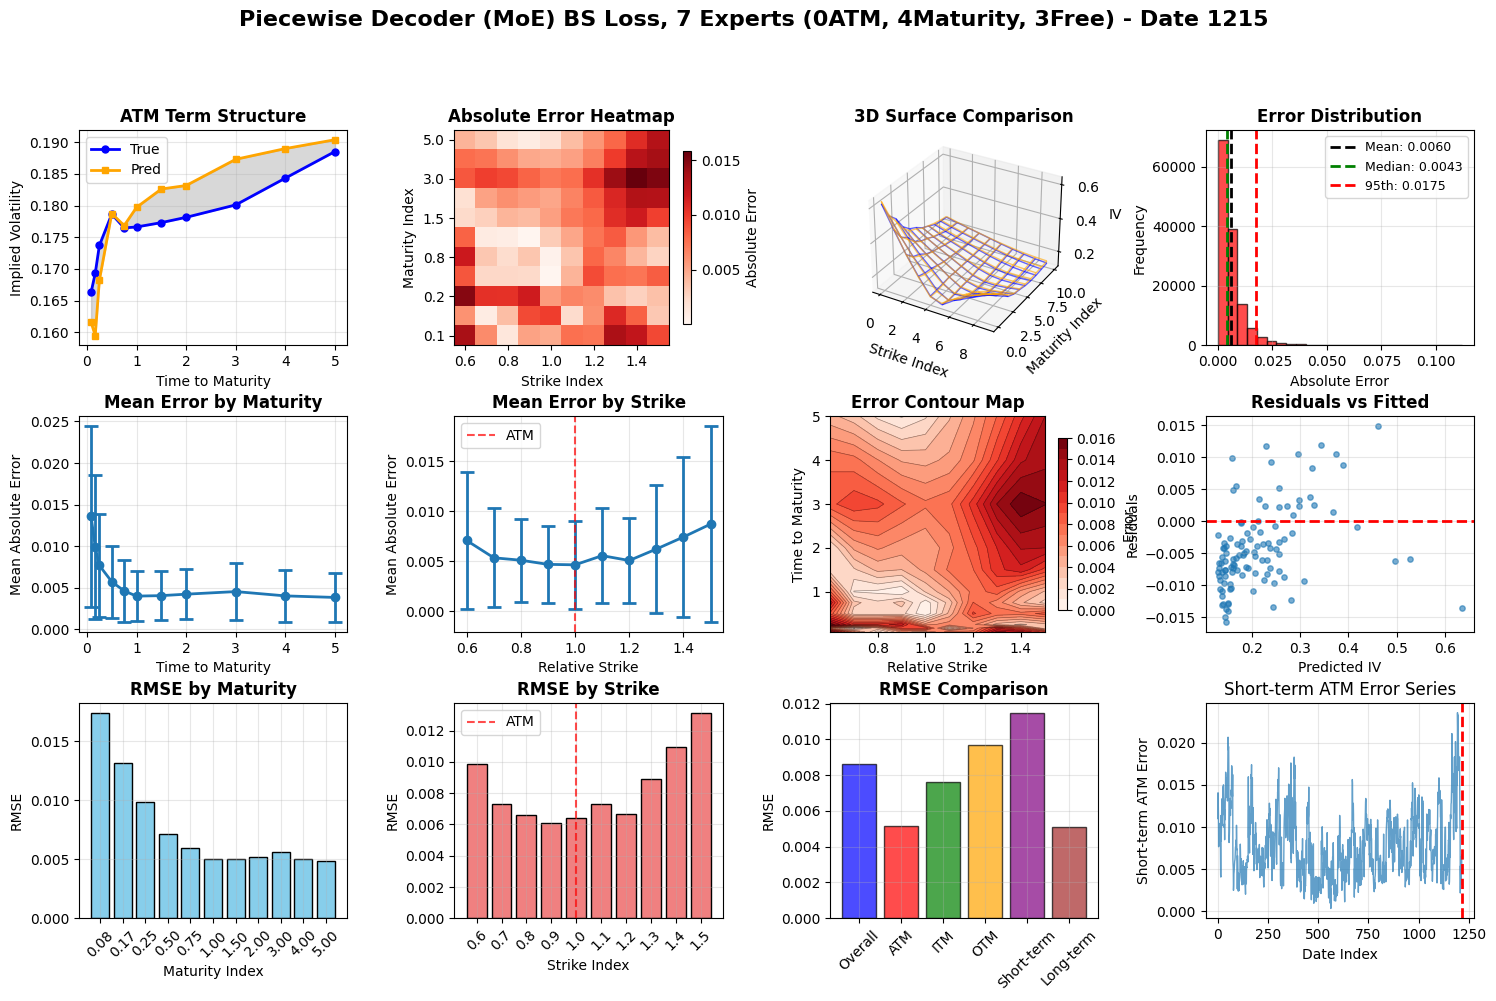

Overall Performance Category Performance  \
RMSE                           0.008608                  NaN   
MAE                            0.005989                  NaN   
Max Error                      0.111818                  NaN   
Mean Error                     0.005989                  NaN   
Median Error                   0.004317                  NaN   
95th Percentile                0.017492                  NaN   
ATM RMSE                            NaN             0.005132   
ITM RMSE                            NaN             0.007601   
OTM RMSE                            NaN             0.009681   
Short-term RMSE                     NaN             0.011469   
Long-term RMSE                      NaN             0.005121   
Short/Long Ratio                    NaN                2.240   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.004821)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.017380)                       NaN  
Best Strike           K=0.9 (RMSE: 0.006064)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.013110)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.006421)                       NaN  
Overall Rank              ATM ranks #2 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.240)  
ATM Issues                               NaN   NO (ATM/Overall: 0.60x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.002080)  
High Error Variance                      NaN       YES (std: 0.006183)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [ ]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened

# setup grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run comprehensive analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,              
  Y_pred=Y_hat,               
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,                # last date
  dates=None,                 
  title="Piecewise Decoder (MoE) BS Loss, 7 Experts (0ATM, 4Maturity, 3Free)"
)

In [ ]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name="Piecewise Decoder with BS Loss (MoE) 7 Experts, atm 0, 3 Free, 4 Maturity",
   model=decoder_pw_mod
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
  
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0  Piecewise Decoder with BS Loss (MoE) 7 Experts...     1     0.008608   
1                     Piecewise Decoder with BS Loss     2     0.009986   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.005989  0.006421  0.004646  0.007601  0.009681         2.239612   
1    0.006955  0.009976  0.006823  0.009298  0.010506         2.365514   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.111818             True       False     EXCELLENT             False  
1  0.077199             True       False     EXCELLENT             False

Raw predictions shape: (20, 11, 10)
Using sliding window size: 5
Evaluation dimensions: N=20, M=11, K=10
Adaptive Refined MoE Decoder RMSE_σ: 0.0069
RMSE by maturity (mean ± std): 0.0075 ± 0.0041
RMSE by strike    (mean ± std): 0.0083 ± 0.0020
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


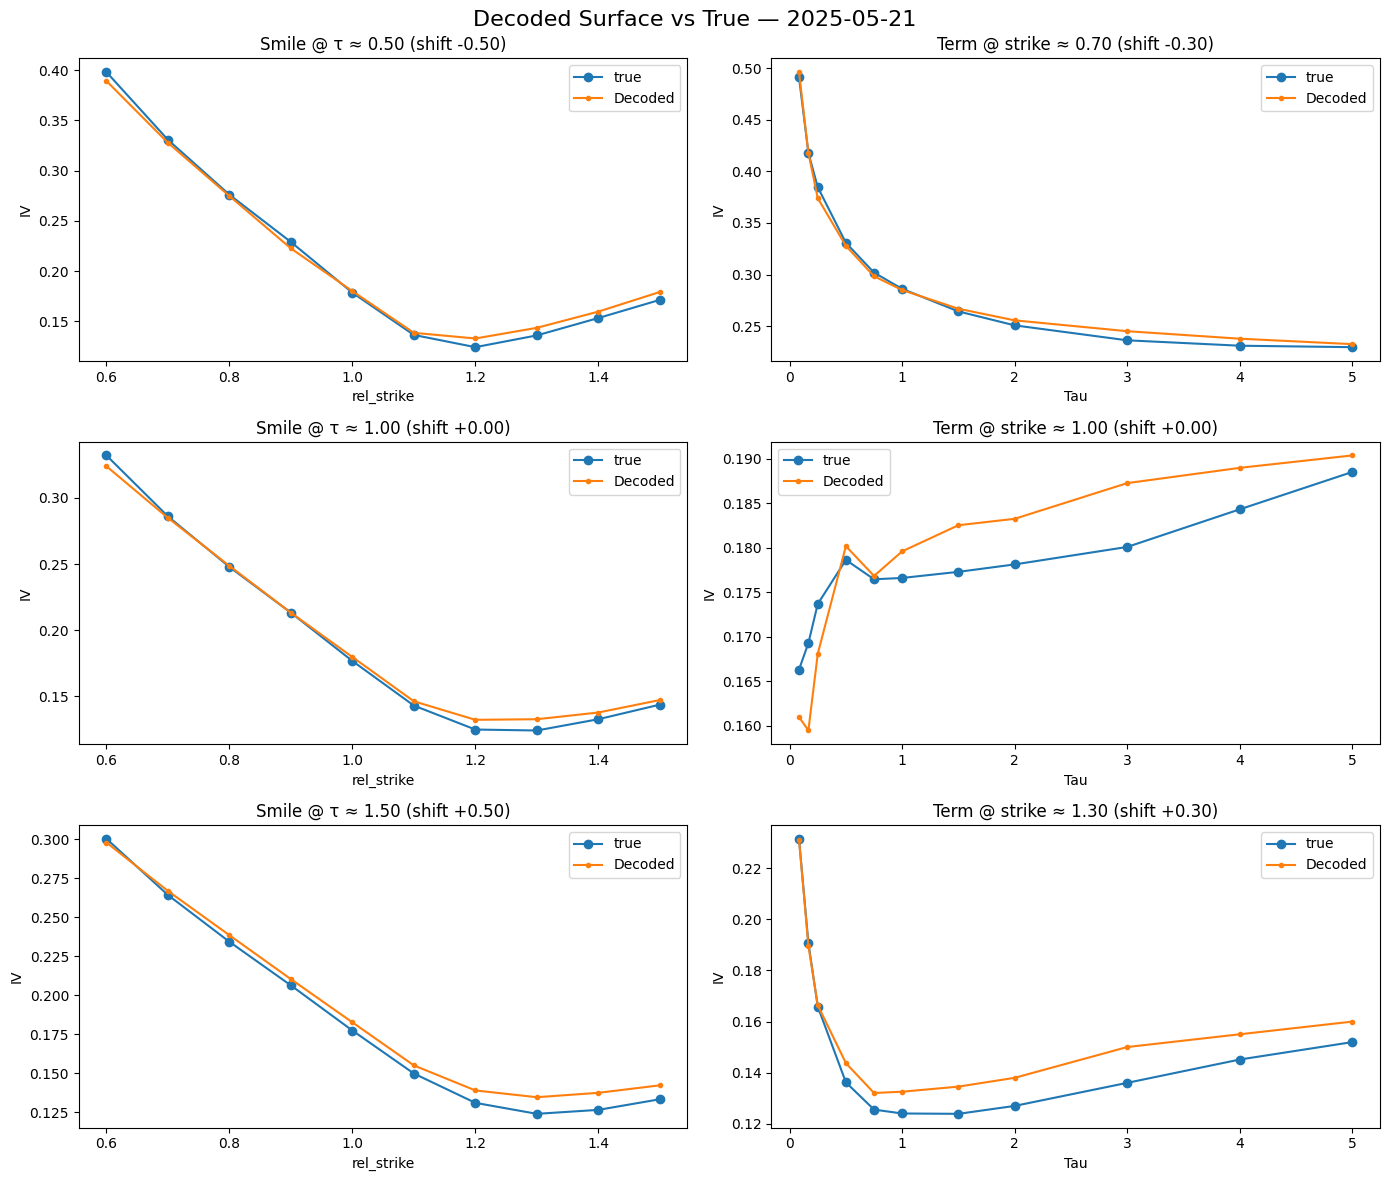

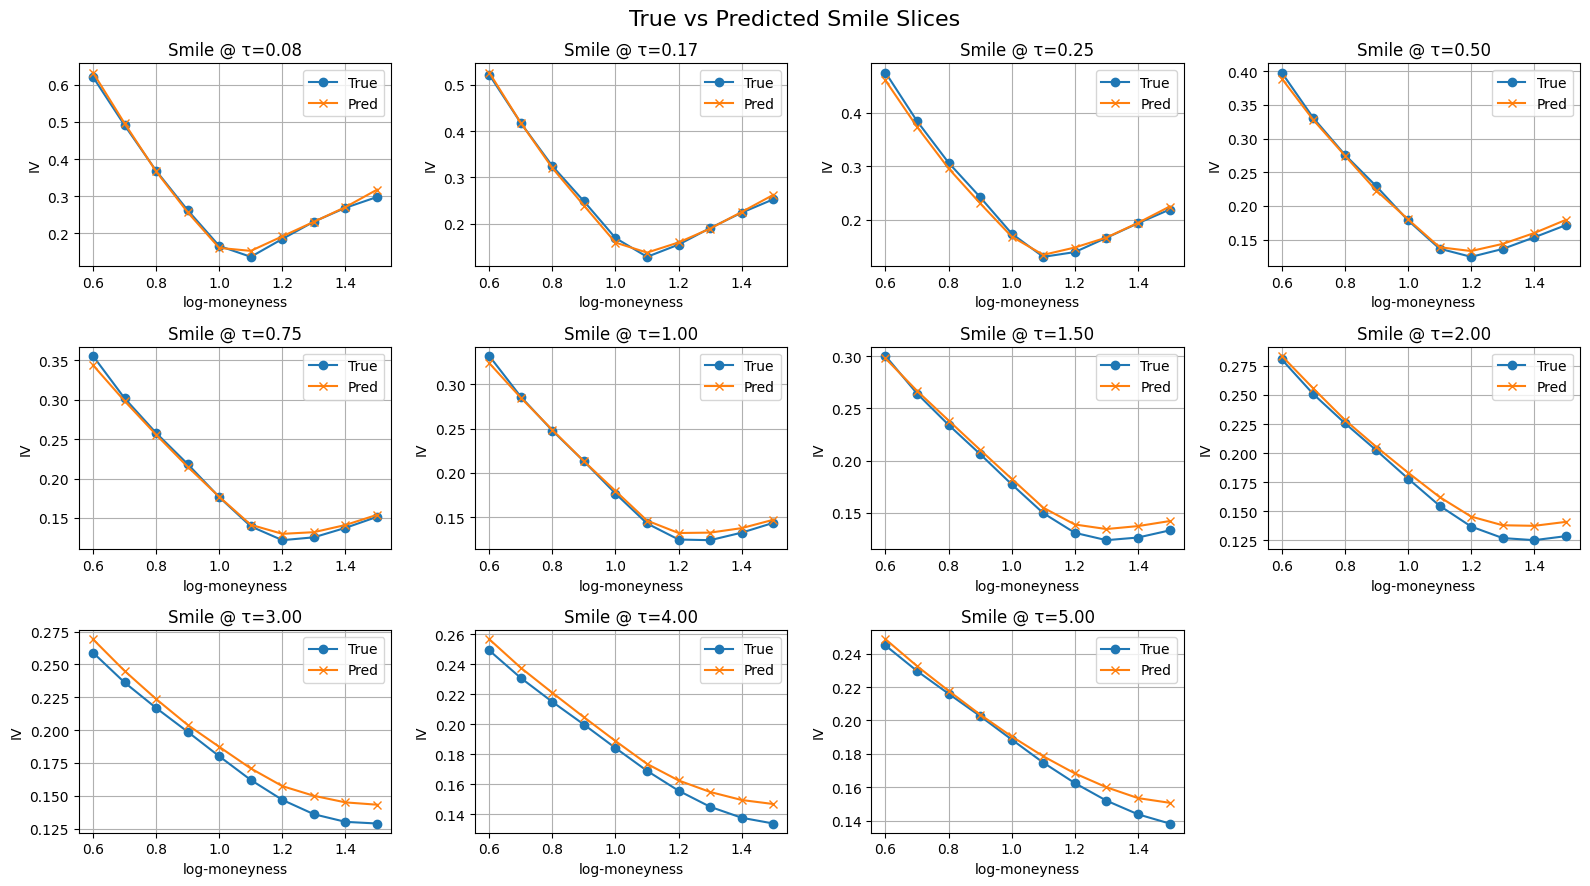

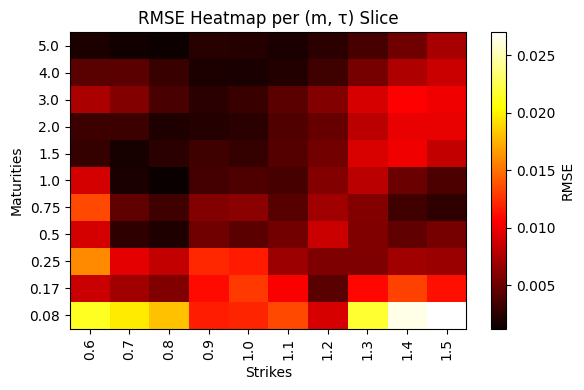

{'rmse_overall': 0.0069011164912149365,
 'rmse_by_maturity': array([0.01900561, 0.00999295, 0.00955517, 0.00572563, 0.00638521,
        0.0051615 , 0.00582962, 0.00579168, 0.00689292, 0.00482774,
        0.00350828]),
 'rmse_by_strike': array([0.01054802, 0.00757692, 0.00663492, 0.00685307, 0.00709952,
        0.00647276, 0.00601754, 0.00969487, 0.01118058, 0.01109232])}

In [ ]:
import importlib
import utils.eval
importlib.reload(utils.eval)

import models.pointwise_moe
importlib.reload(models.pointwise_moe)

from utils.eval import evaluate_decoder_output_v2

# config
SMOOTH_ALL = False
N_surfaces = 20

# select data subset
Z_eval = Z_decoder if SMOOTH_ALL else Z_decoder[-N_surfaces:]
F_eval = F_aligned if SMOOTH_ALL else F_aligned[-N_surfaces:]
Y_true = Y_decoder if SMOOTH_ALL else Y_decoder[-N_surfaces:]

# generate raw predictions from moe
Y_pred_raw = np.stack([
   decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

print(f"raw predictions shape: {Y_pred_raw.shape}")

# prepare ground truth for sliding window
Y_true_3d = Y_true.reshape(-1, M, K)

# apply adaptive refinement with sliding window
window_size = max(1, int(N_surfaces // 4))  # ensure at least 1
print(f"using sliding window size: {window_size}")

Y_pred_smooth = []
for i, surf in enumerate(Y_pred_raw):
   # sliding window of recent surfaces
   window_start = max(0, i - window_size)
   window_end = i + 1
   recent_surfaces = Y_true_3d[window_start:window_end]
   
   refined_surf = decoder_pw_mod.refine_surface(
       surf, 
       recent_surfaces=recent_surfaces,
       lambda_cal=0.1,        # calendar penalty
       lambda_smile=0.1,      # smile penalty  
       lambda_history=0.05    # history matching
   )
   Y_pred_smooth.append(refined_surf)

Y_pred_smooth = np.stack(Y_pred_smooth)

# evaluate refined surfaces
evaluate_decoder_output_v2(
   Y_pred=Y_pred_smooth,                   # (N, M, K)
   Y_true=Y_true,                          # (N, M*K)
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=decoder_pw_mod,                 
   title=" Refined MoE Decoder"
)

### Experiment 2

Training MoE Modular Decoder
Expert allocation: ATM=1, Maturity=0, Free=4, Total=5
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - loss: 2.5305 - val_loss: 0.3116 - learning_rate: 1.0000e-04
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - loss: 0.2169 - val_loss: 0.1175 - learning_rate: 1.0000e-04
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 79s 27ms/step - loss: 0.0903 - val_loss: 0.0718 - learning_rate: 1.0000e-04
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - loss: 0.0578 - val_loss: 0.0575 - learning_rate: 1.0000e-04
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - loss: 0.0422 - val_loss: 0.0529 - learning_rate: 1.0000e-04
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - loss: 0.0338 - val_loss: 0.0347 - learning_rate: 1.0000e-04
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - loss: 0.0274 - val_loss: 0.0289 - learning_rate: 1.0000e-04
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 79s 27ms/step - loss: 0.0234 - val_loss: 

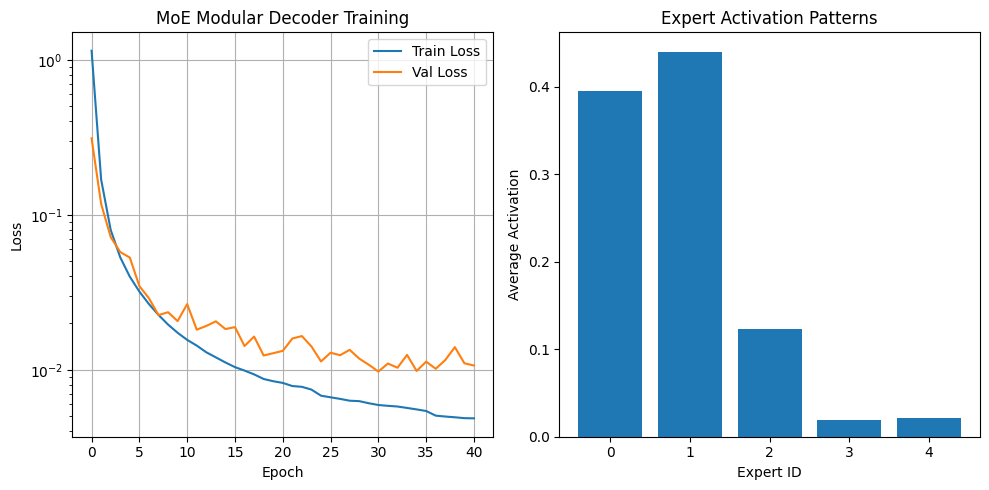

In [ ]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import torch

# choose moe or standard mode
USE_MOE = True  # false for standard decoder comparison

print(f"training {'moe' if USE_MOE else 'standard'} modular decoder")

# setup modular pointwise decoder
decoder_pw_mod_2 = PiecewiseSurfaceDecoderModular(
    latent_dim=LATENT_DIM,
    M=M, K=K, taus=taus,
    feature_dim=F_aligned.shape[1],
    activation="gelu",
    use_moe=True,
    num_experts=8,                    # increase experts
    
    # ultra short-term focus
    maturity_experts=4,               # 4 maturity specialists
    free_experts=4,                   # 4 free experts
    maturity_specialization=False,
    
    # disable atm bias (not the problem)
    atm_specialization=False,          # atm issues false - disable this
    atm_loss_weight=1.0,
    
    # higher diversity to force expert usage
    lambda_diversity=2,
)

decoder_pw_mod_2.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=hybrid_loss_fn)

# training callbacks
model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=5e-5),
    ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
    ModelCheckpoint(f"saved_models/piecewise_surface_mod_{model_suffix}_2/decoder.keras", save_best_only=True, verbose=0)
]

# fit model
history = decoder_pw_mod_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=150,
    callbacks=callbacks,
    verbose=1
)

print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

# plot training history
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title(f"{'moe' if USE_MOE else 'standard'} modular decoder training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
    plt.subplot(1, 2, 2)
    # analyze expert gating patterns
    analysis = decoder_pw_mod_2.analyze_gating(X_val)
    if analysis is not None:
        plt.bar(range(decoder_pw_mod_2.num_experts), analysis['expert_activations'])
        plt.title("expert activation patterns")
        plt.xlabel("expert id")
        plt.ylabel("average activation")
        plt.xticks(range(decoder_pw_mod_2.num_experts))
        
        print(f"\nexpert analysis:")
        print(f"  expert activations: {analysis['expert_activations']}")
        print(f"  average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

Y_hat shape: (1216, 11, 10)
Y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
ex 2: Piecewise Decoder with BS Loss (MoE) 7 Experts,atm 1 , 2 Free, 4 Maturity RMSE_σ: 0.0070
RMSE by maturity (mean ± std): 0.0072 ± 0.0037
RMSE by strike    (mean ± std): 0.0079 ± 0.0018
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


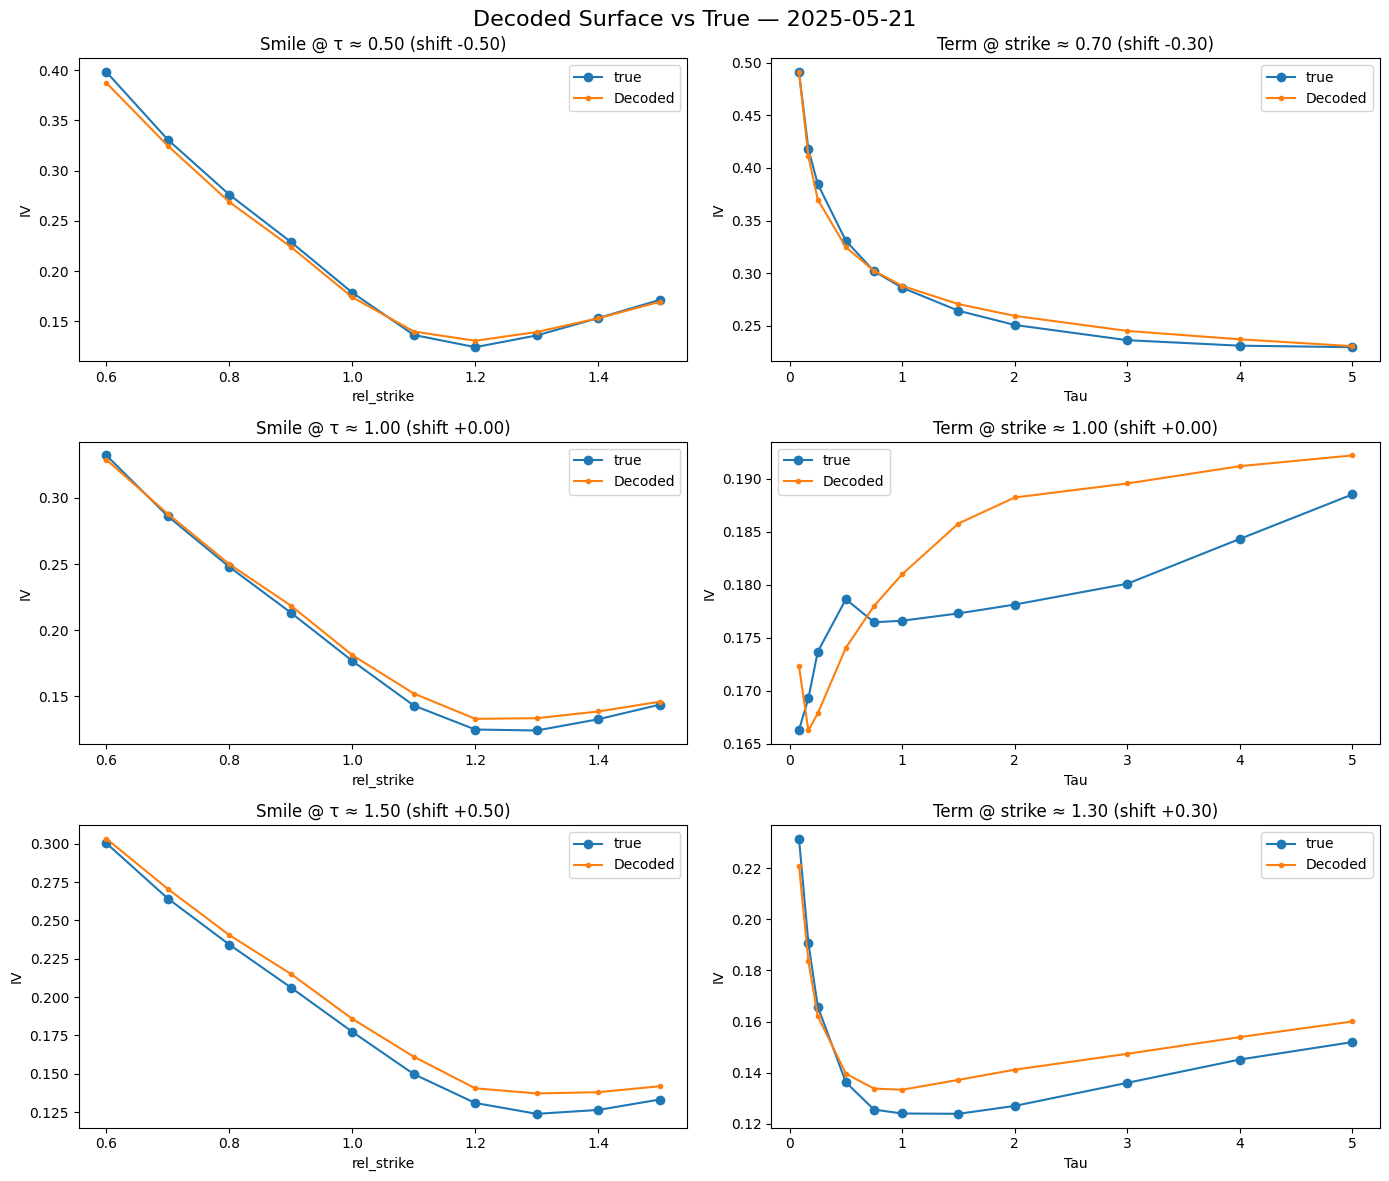

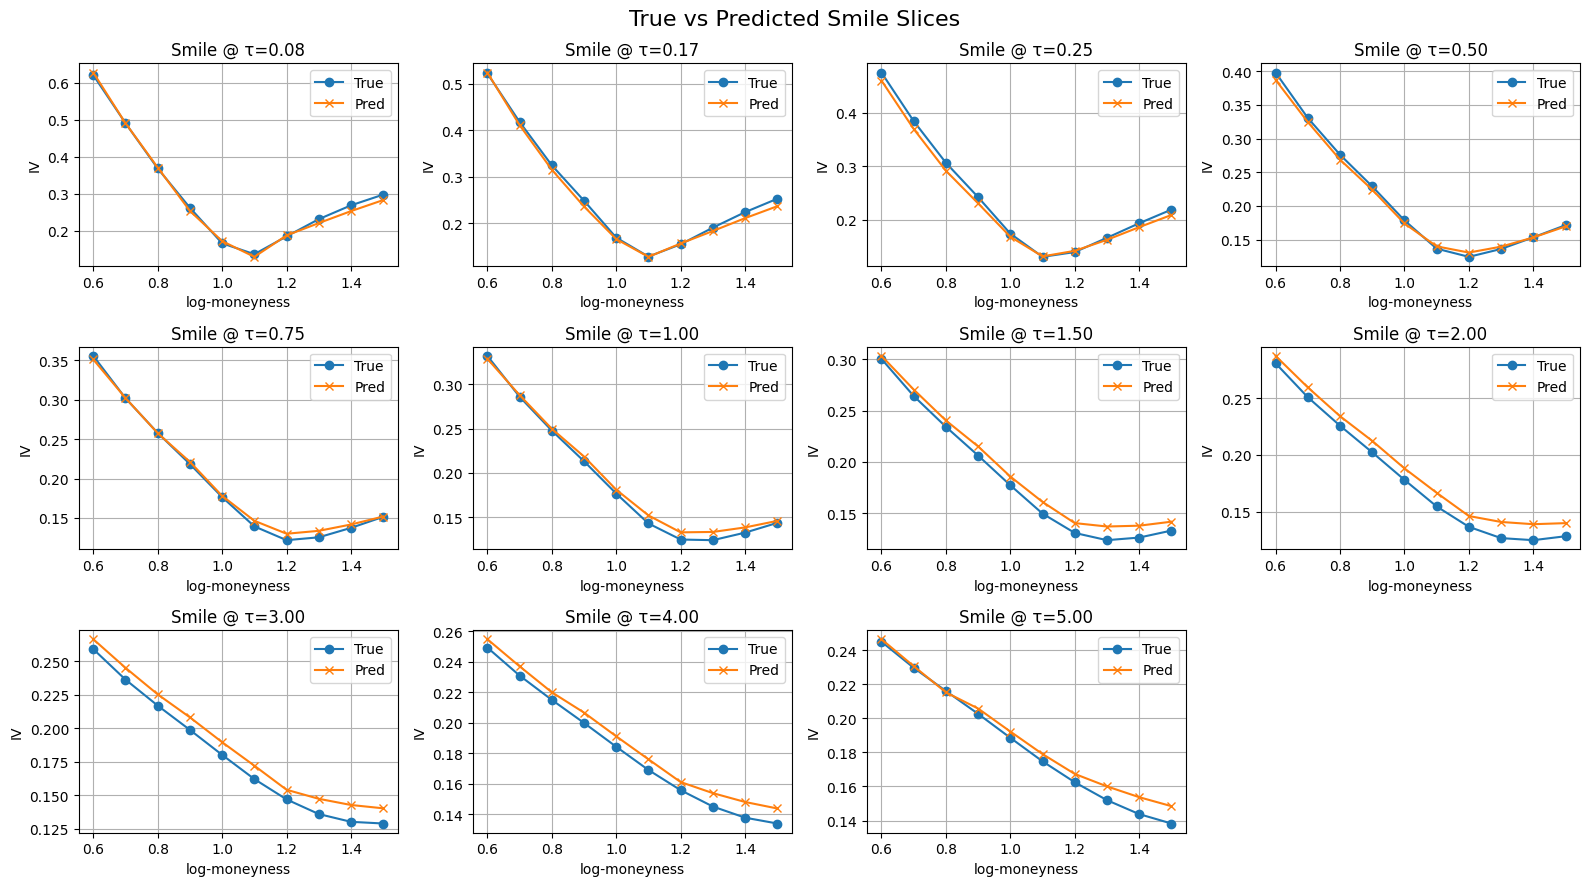

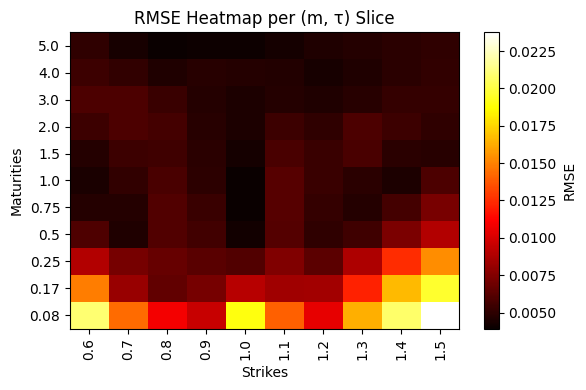

{'rmse_overall': 0.0069996556,
 'rmse_by_maturity': array([0.01667568, 0.01190373, 0.00903684, 0.00606368, 0.00545846,
        0.00516737, 0.00519119, 0.00532131, 0.00511559, 0.00484361,
        0.00451763], dtype=float32),
 'rmse_by_strike': array([0.00934052, 0.00698641, 0.00632369, 0.00583655, 0.00754259,
        0.00716407, 0.00616193, 0.00800039, 0.01000533, 0.01158221],
       dtype=float32)}

In [ ]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

name = "ex 2: piecewise decoder with bs loss (moe) 8 experts, 4 free, 4 maturity"

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike-tau grid
m_grid, tau_grid = np.meshgrid(
   ops.convert_to_numpy(tensors["strike_tensor"]),
   ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
   decoder_pw_mod_2.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

print(f"Y_hat shape: {Y_hat.shape}")
print(f"Y_full shape: {Y_full.shape}")

# evaluate using new function
evaluate_decoder_output_v2(
    Y_pred=Y_hat,                          # pre-computed predictions (N, M, K)
    Y_true=Y_full,                         # ground truth (N, M*K) auto-reshaped
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw_mod_2,              # for penalty calc
    title=name
)

🔍 MoE Training Analysis
📊 Experts: 5
🎯 ATM Specialization: True
⚖️ Diversity λ: 0.5
💪 ATM Expert Bias: 2.0
--------------------------------------------------


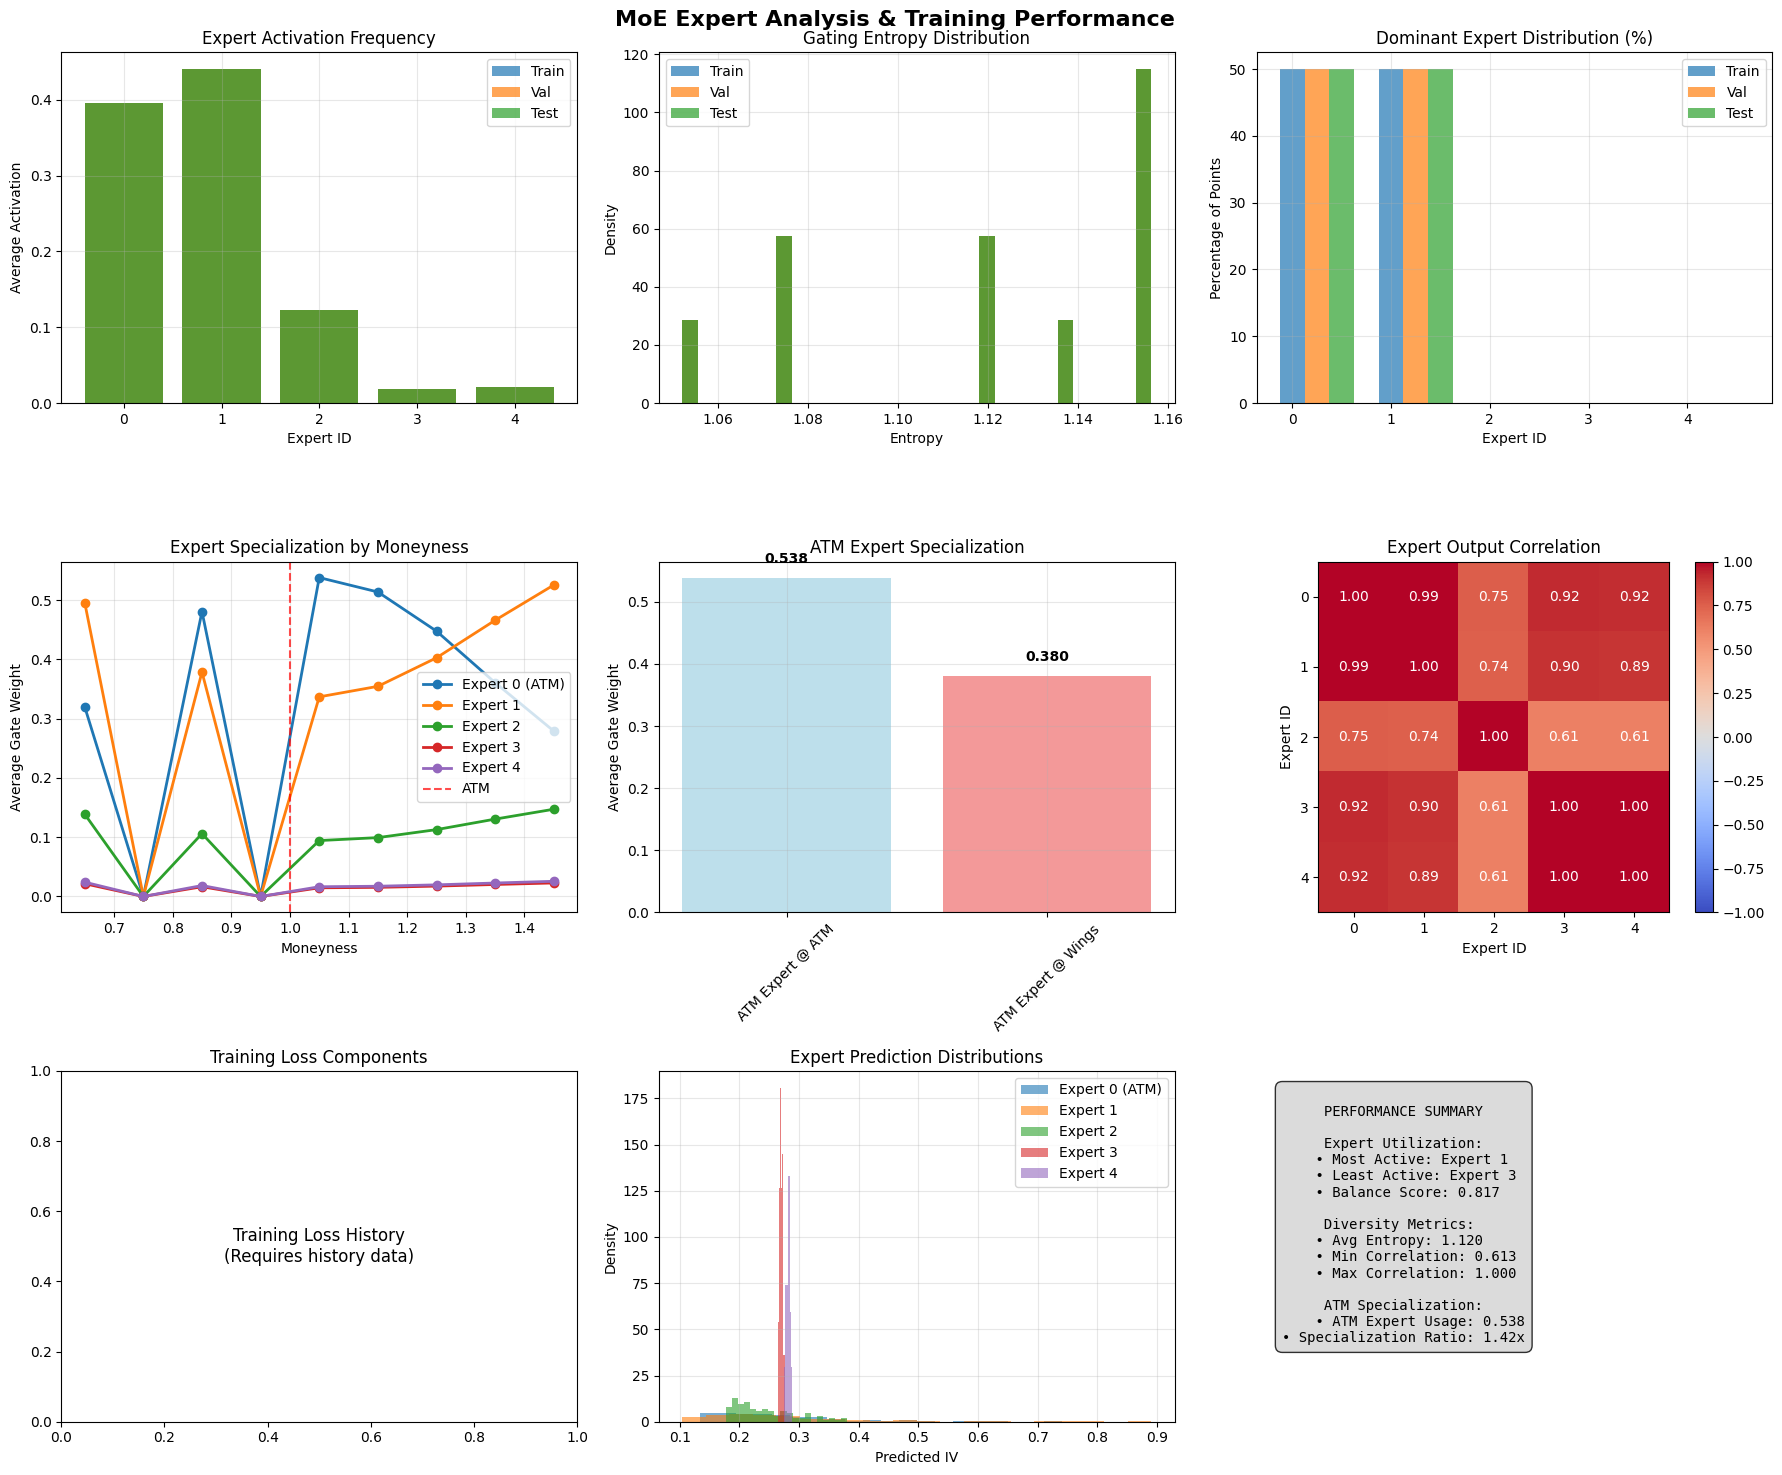


📊 DETAILED ANALYSIS:
Expert Activations: [0.39578083 0.44032314 0.12333724 0.01912482 0.0214656 ]
Average Entropy: 1.1197
Expert Balance (1-std): 0.8175
ATM Expert Usage: 0.5379


In [ ]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance

# analyze moe performance
results = analyze_moe_training_performance(
   decoder_pw_mod_2,    # moe decoder
   X_train,           # training inputs [z+f, strikes, taus]
   X_val,             # validation inputs
   X_test,            # test inputs  
   y_train,           # training targets
   y_val,             # validation targets
   y_test             # test targets
)

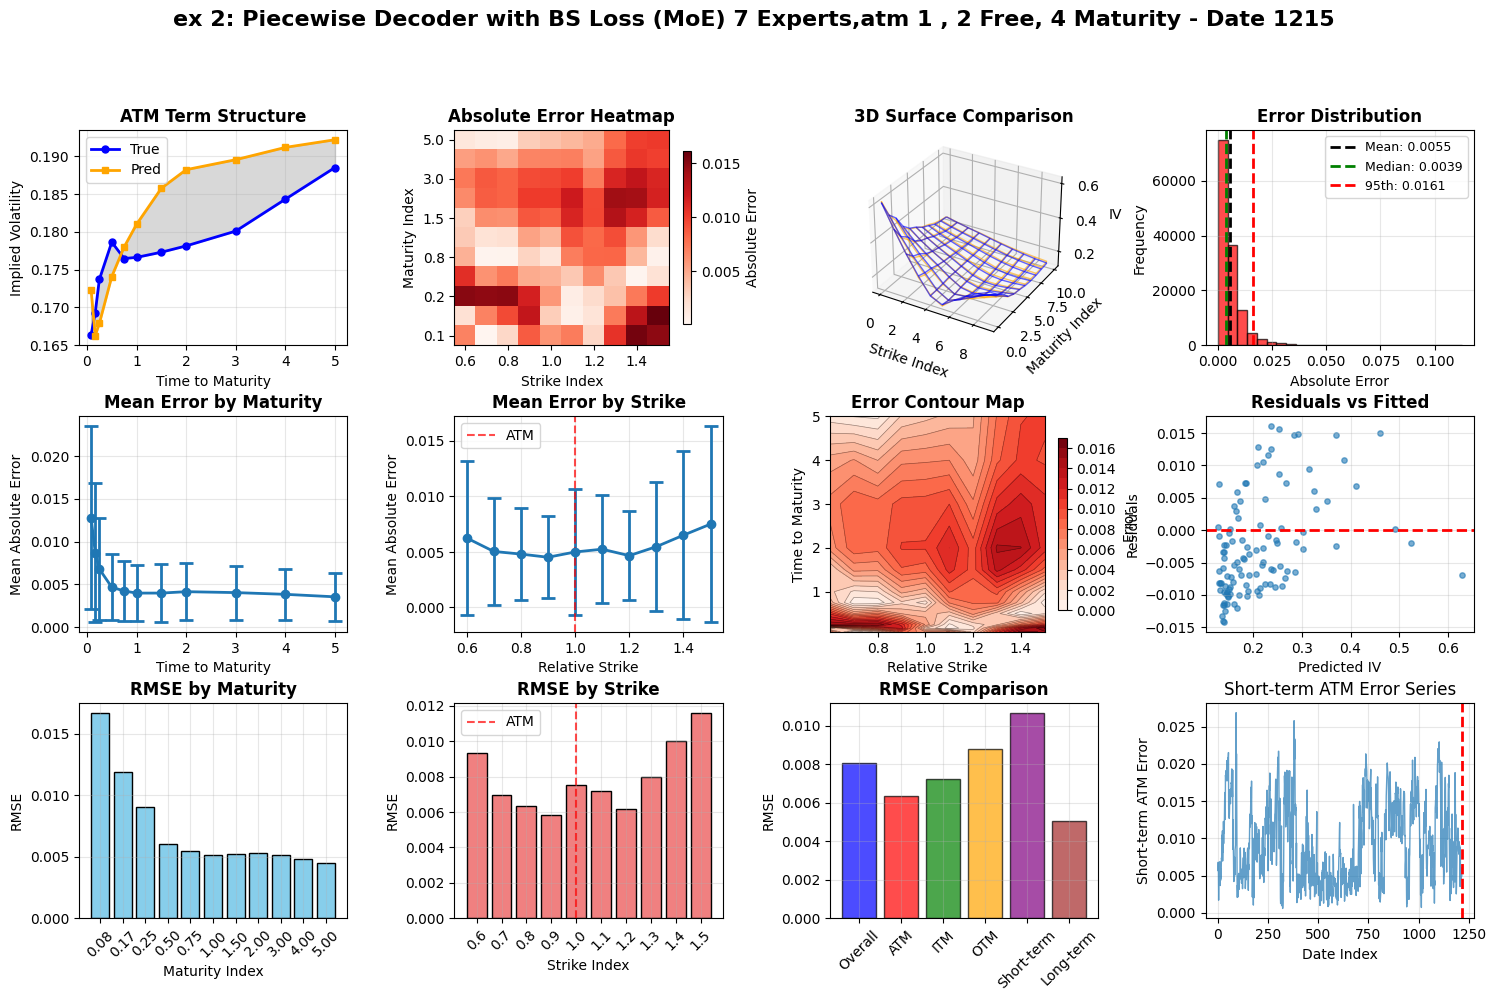

Overall Performance Category Performance  \
RMSE                           0.008090                  NaN   
MAE                            0.005506                  NaN   
Max Error                      0.112518                  NaN   
Mean Error                     0.005506                  NaN   
Median Error                   0.003887                  NaN   
95th Percentile                0.016118                  NaN   
ATM RMSE                            NaN             0.006366   
ITM RMSE                            NaN             0.007248   
OTM RMSE                            NaN             0.008804   
Short-term RMSE                     NaN             0.010658   
Long-term RMSE                      NaN             0.005033   
Short/Long Ratio                    NaN                2.118   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.004518)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.016676)                       NaN  
Best Strike           K=0.9 (RMSE: 0.005837)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.011582)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.007543)                       NaN  
Overall Rank              ATM ranks #6 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.118)  
ATM Issues                               NaN   NO (ATM/Overall: 0.79x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.001556)  
High Error Variance                      NaN       YES (std: 0.005928)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [ ]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prep strike-tau grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_2.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,
  Y_pred=Y_hat,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title="Piecewise Decoder (MoE) BS Loss, 7 Experts (1ATM, 5Maturity, 1Free)"
)

In [ ]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe_2 = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name=name,
   model=decoder_pw_mod_2
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
   summary_pw_moe_2
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0  ex 2: Piecewise Decoder with BS Loss (MoE) 7 E...     1     0.008090   
1  Piecewise Decoder with BS Loss (MoE) 7 Experts...     2     0.008608   
2                     Piecewise Decoder with BS Loss     3     0.009986   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.005506  0.007543  0.004998  0.007248  0.008804         2.117567   
1    0.005989  0.006421  0.004646  0.007601  0.009681         2.239612   
2    0.006955  0.009976  0.006823  0.009298  0.010506         2.365514   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.112518             True       False     EXCELLENT             False  
1  0.111818             True       False     EXCELLENT             False  
2  0.077199             True       False     EXCELLENT             False

####  Experiment 3

Training MoE Modular Decoder
Expert allocation: ATM=0, Maturity=4, Free=0, Total=4
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 124s 42ms/step - loss: 8.0226 - val_loss: 1.9976 - learning_rate: 1.0000e-05
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 120s 41ms/step - loss: 1.6600 - val_loss: 1.3696 - learning_rate: 1.0000e-05
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 129s 44ms/step - loss: 1.2398 - val_loss: 1.0927 - learning_rate: 1.0000e-05
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 117s 40ms/step - loss: 0.9785 - val_loss: 0.8802 - learning_rate: 1.0000e-05
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 125s 43ms/step - loss: 0.7791 - val_loss: 0.7136 - learning_rate: 1.0000e-05
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 131s 45ms/step - loss: 0.6228 - val_loss: 0.5900 - learning_rate: 1.0000e-05
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 126s 43ms/step - loss: 0.5072 - val_loss: 0.4912 - learning_rate: 1.0000e-05
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 125s 43ms/step - loss: 0.4133 - va

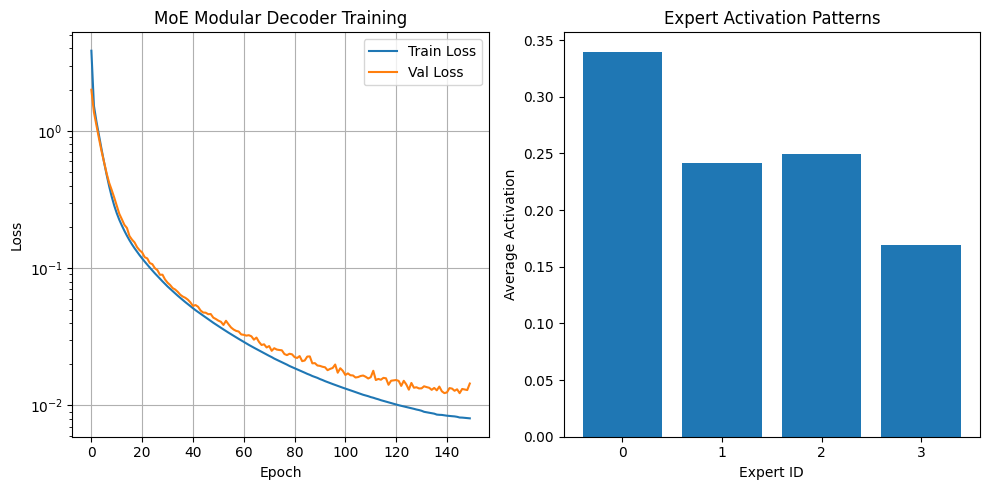

In [ ]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)



# choose moe or standard
USE_MOE = True

print(f"training {'moe' if USE_MOE else 'standard'} modular decoder")

# instantiate decoder
decoder_pw_mod_3 = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M, K=K, taus=taus,
   feature_dim=F_aligned.shape[1],
   activation="gelu",
   use_moe=True,
   num_experts=4,
   
   # ultra short-term focus
   maturity_experts=4, # only maturity experts
   free_experts=0,
   maturity_specialization=False,
   
   # disable atm bias
   atm_specialization=False,
   atm_loss_weight=1.0,
   
   # higher diversity
   lambda_diversity=0.25,
)

decoder_pw_mod_3.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=hybrid_loss_fn)

# training callbacks
model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/ae/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
   ModelCheckpoint(f"saved_models/ae/piecewise_surface_mod_{model_suffix}_3/decoder.keras", save_best_only=True, verbose=0)
]

# fit model
history = decoder_pw_mod_3.fit(
   X_train, y_train,
   validation_data=(X_val, y_val),
   batch_size=BATCH_SIZE,
   epochs=150,
   callbacks=callbacks,
   verbose=1
)

print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

# plot training
print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

# plot training history
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"{'moe' if USE_MOE else 'standard'} modular decoder training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
   plt.subplot(1, 2, 2)
   # check expert patterns
   analysis = decoder_pw_mod_2.analyze_gating(X_val)
   if analysis is not None:
       plt.bar(range(decoder_pw_mod.num_experts), analysis['expert_activations'])
       plt.title("Expert Activation Patterns")
       plt.xlabel("Expert ID")
       plt.ylabel("Average Activation")
       plt.xticks(range(decoder_pw_mod.num_experts))
       
       print(f"\nexpert analysis:")
       print(f"  expert activations: {analysis['expert_activations']}")
       print(f"  average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

Y_hat shape: (1216, 11, 10)
Y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
 exp 3 , only maturity, 4 Experts, atm 0, 0 Free RMSE_σ: 0.0071
RMSE by maturity (mean ± std): 0.0073 ± 0.0038
RMSE by strike    (mean ± std): 0.0080 ± 0.0020
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


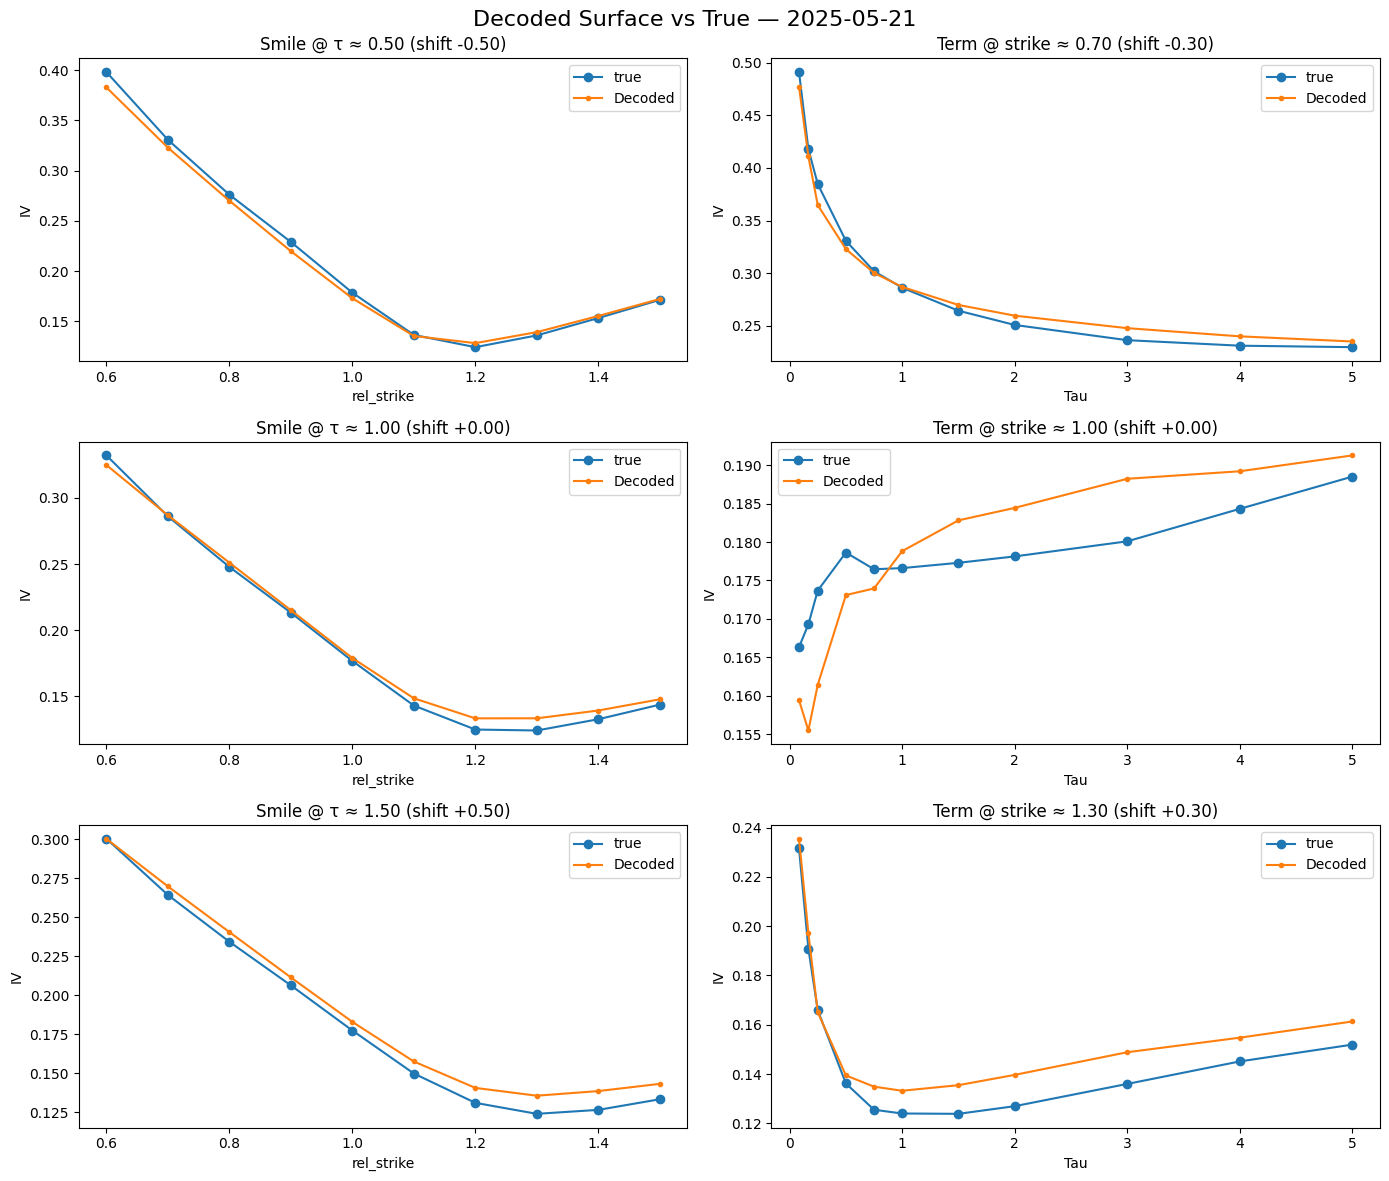

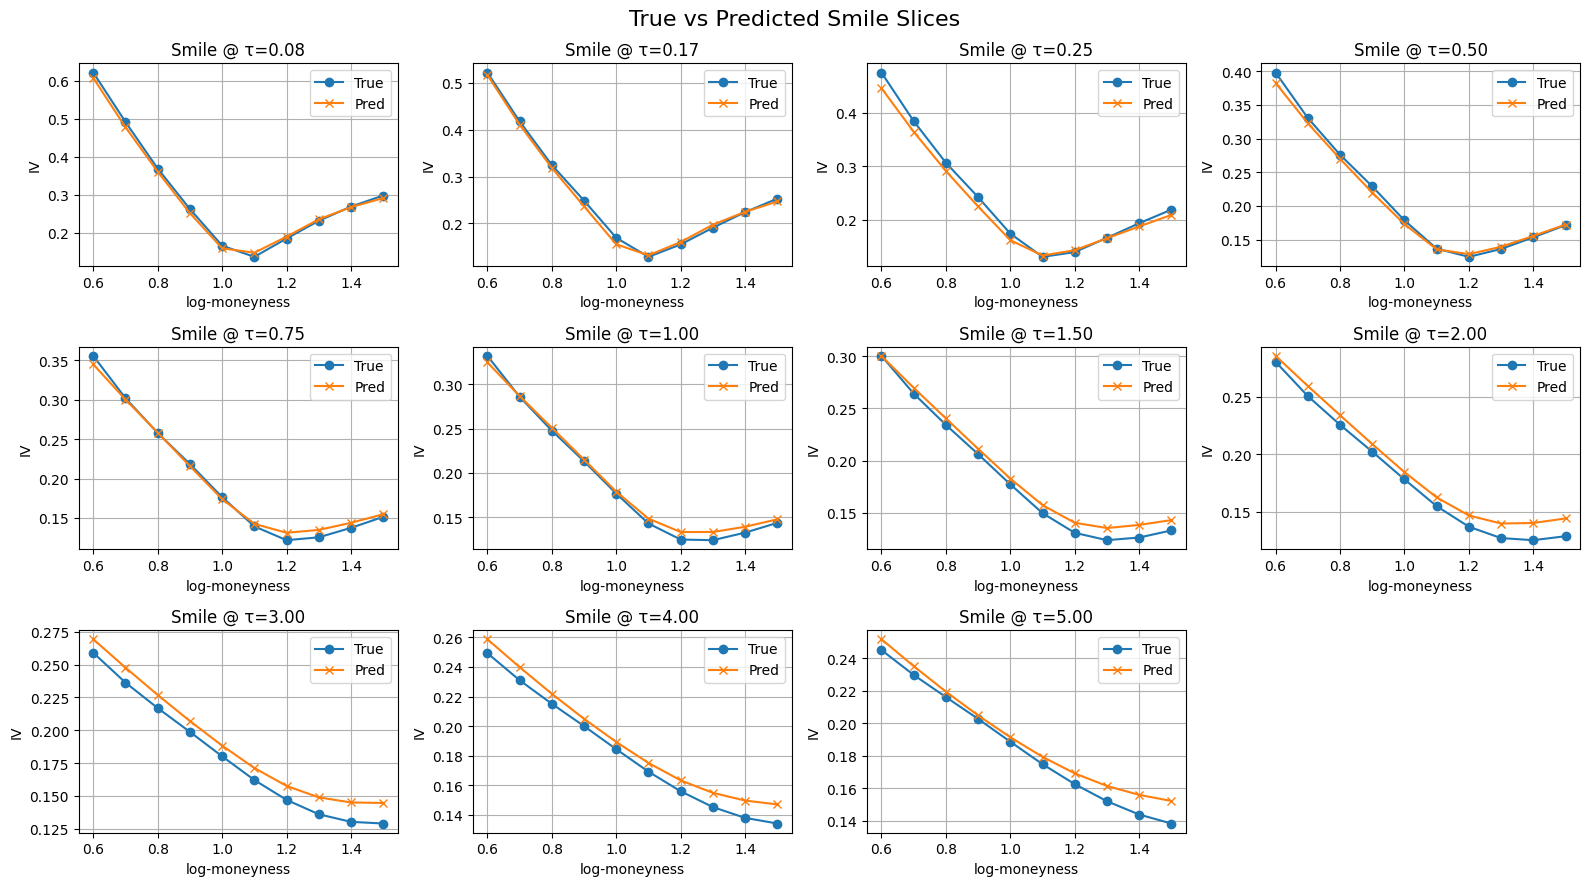

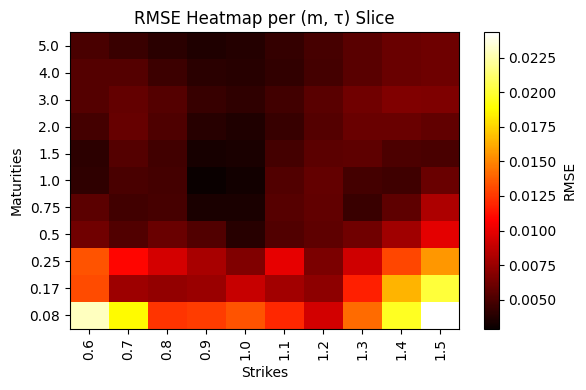

{'rmse_overall': 0.0070785857,
 'rmse_by_maturity': array([0.01667103, 0.01161801, 0.01064964, 0.00632121, 0.00530559,
        0.00474361, 0.00475574, 0.00512366, 0.00553521, 0.00502584,
        0.00482098], dtype=float32),
 'rmse_by_strike': array([0.00994507, 0.00824276, 0.00666517, 0.0060453 , 0.00613018,
        0.00666954, 0.00613348, 0.00781299, 0.01007594, 0.01213035],
       dtype=float32)}

In [ ]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

name = "exp 3, only maturity, 4 experts, atm 0, 0 free"

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike-tau grid
m_grid, tau_grid = np.meshgrid(
   ops.convert_to_numpy(tensors["strike_tensor"]),
   ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
   decoder_pw_mod_3.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

print(f"Y_hat shape: {Y_hat.shape}")
print(f"Y_full shape: {Y_full.shape}")

# evaluate using new function
evaluate_decoder_output_v2(
    Y_pred=Y_hat,                          # pre-computed predictions (N, M, K)
    Y_true=Y_full,                         # ground truth (N, M*K) auto-reshaped
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw_mod,               
    title=name
)

🔍 MoE Training Analysis
📊 Experts: 4
🎯 ATM Specialization: False
⚖️ Diversity λ: 0.5
💪 ATM Expert Bias: 2.0
--------------------------------------------------


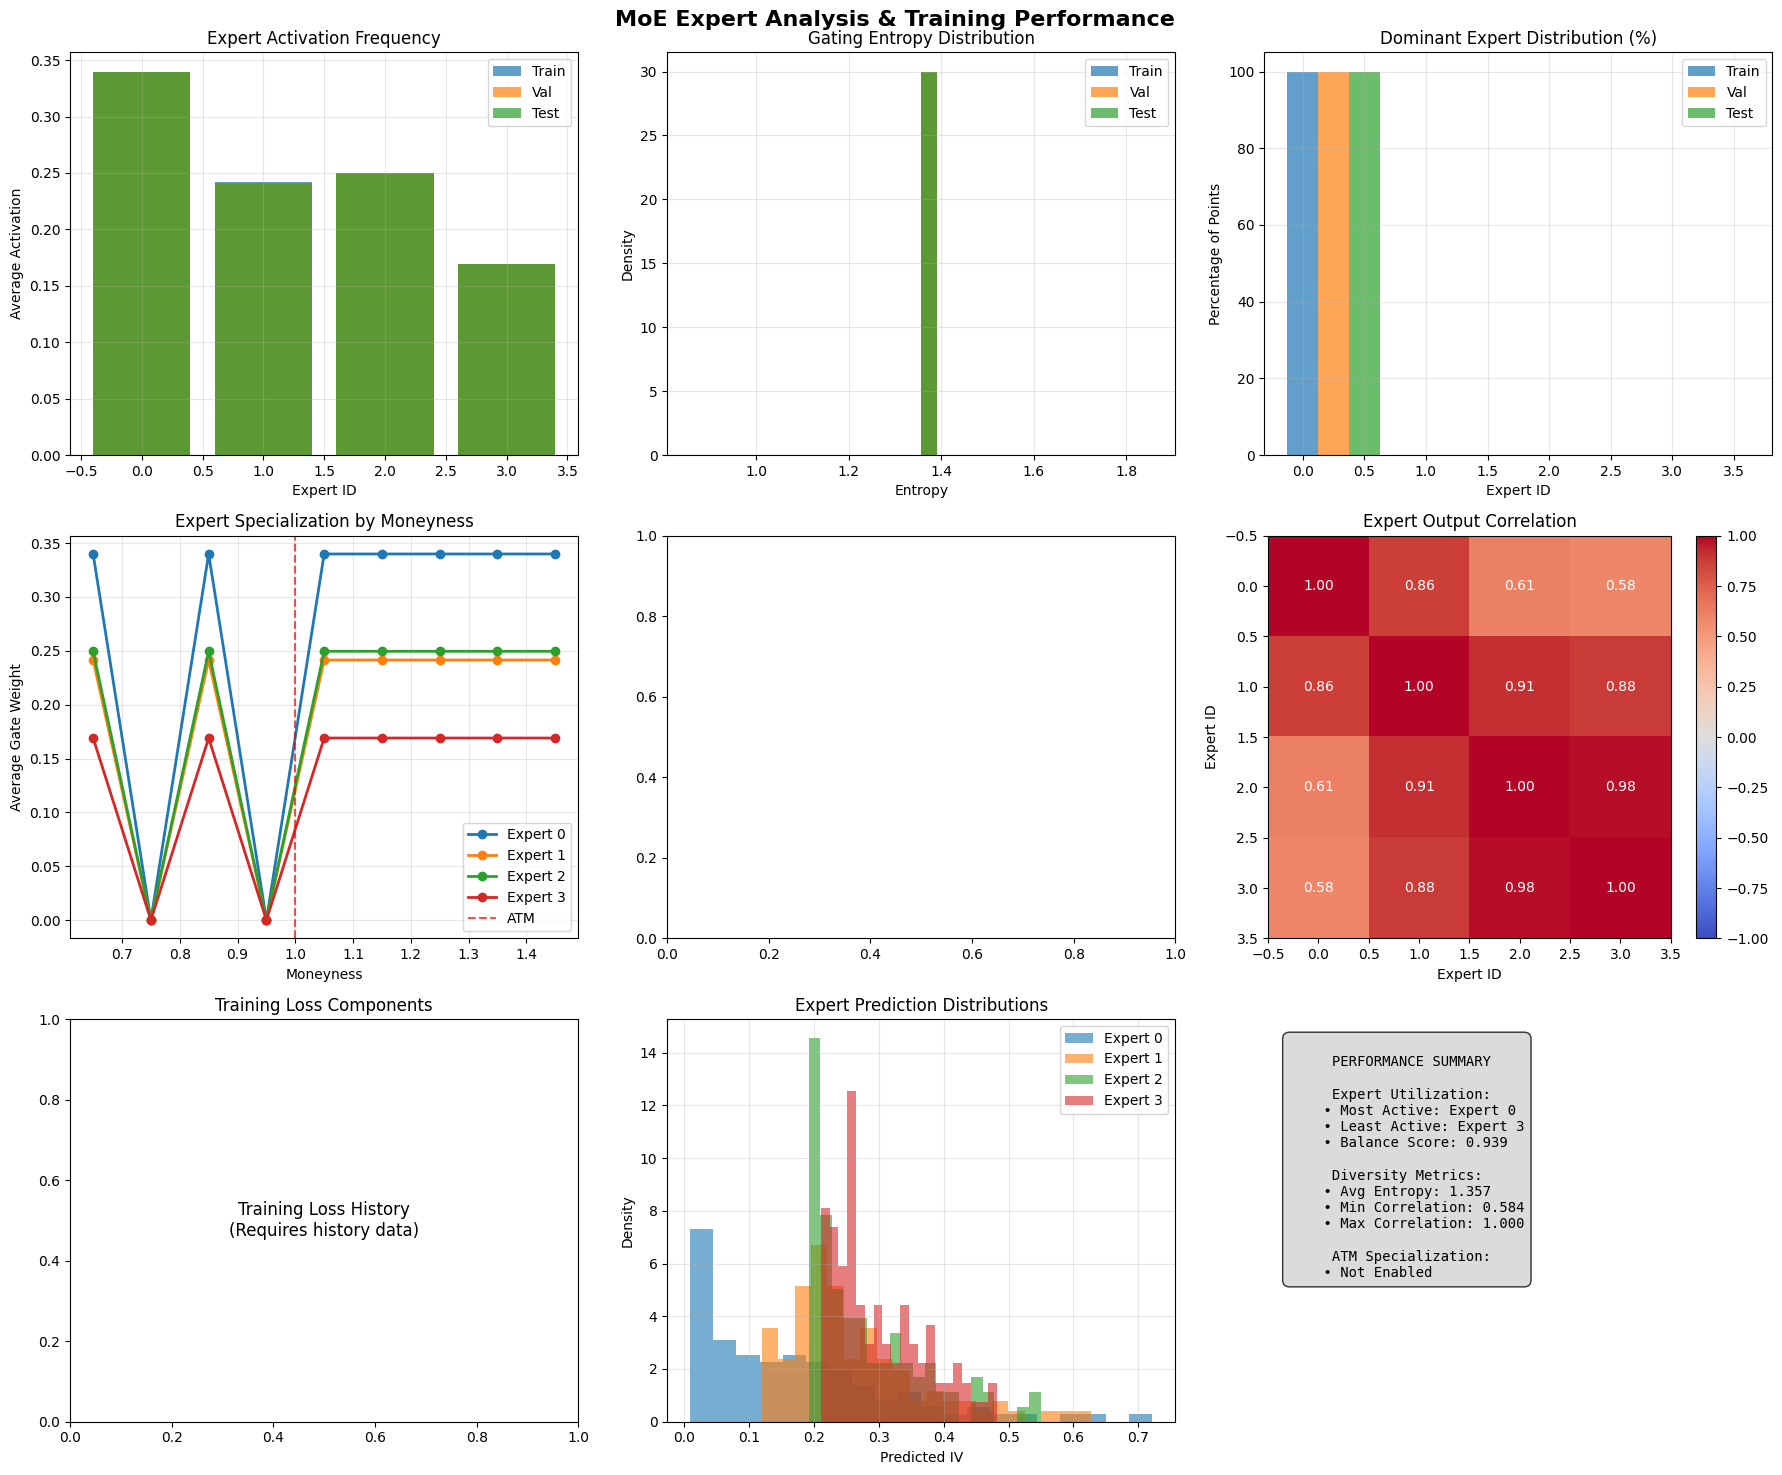


📊 DETAILED ANALYSIS:
Expert Activations: [0.33985013 0.24161224 0.24983141 0.1689581 ]
Average Entropy: 1.3568
Expert Balance (1-std): 0.9394


In [ ]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance


results = analyze_moe_training_performance(
    decoder_pw_mod_3,  
    X_train,           
    X_val,             
    X_test,              
    y_train,           
    y_val,             
    y_test             
)

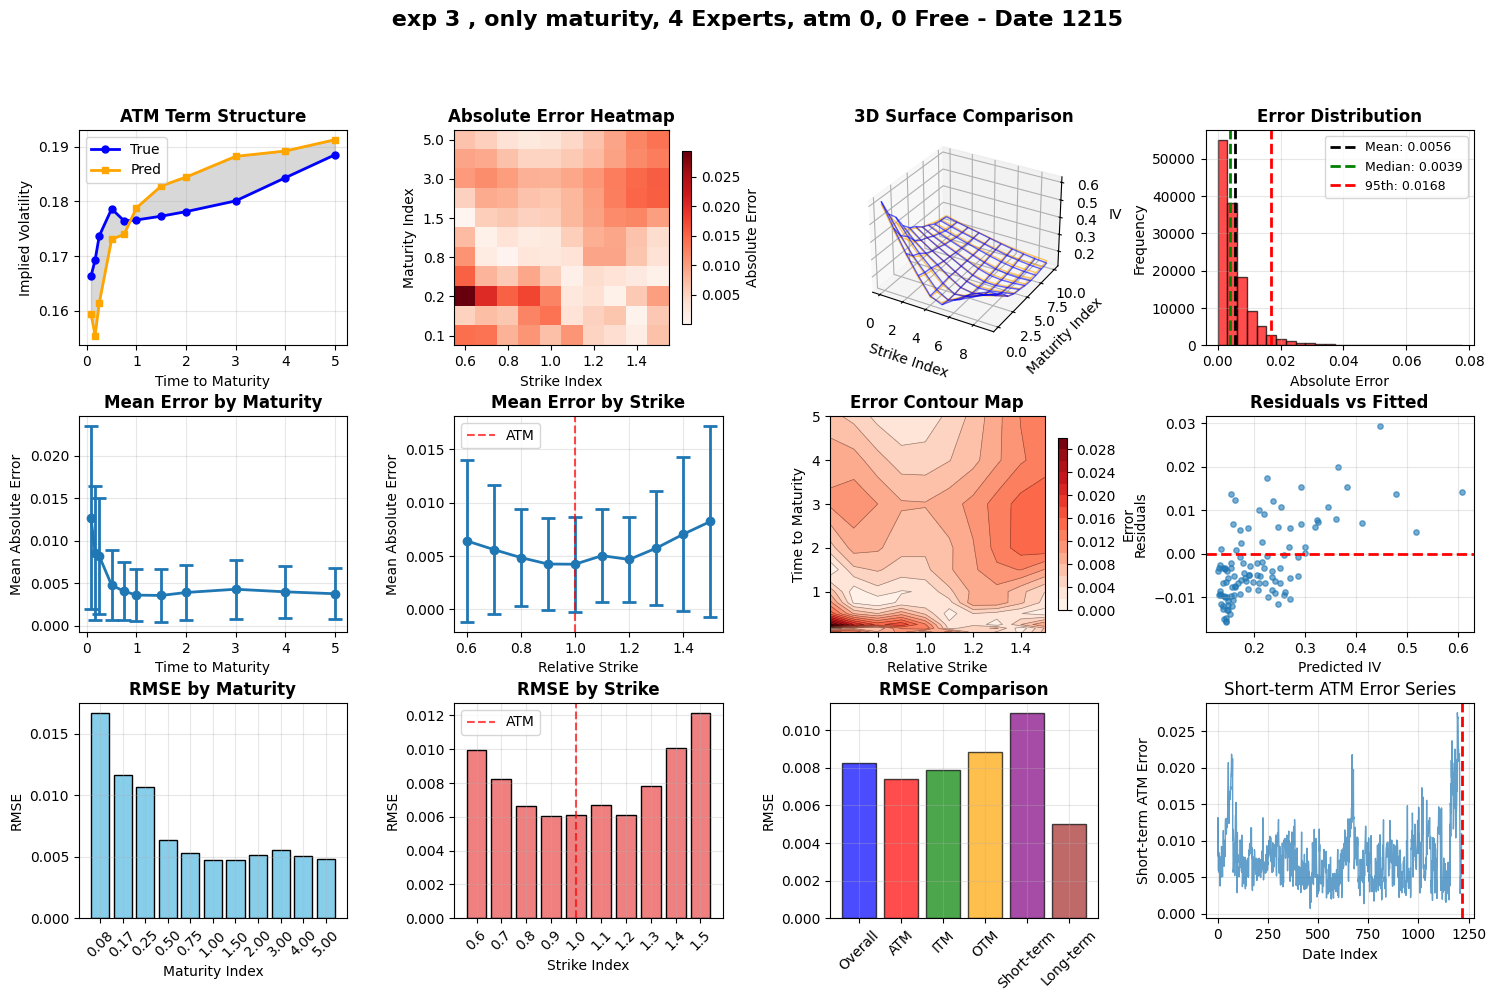

Overall Performance Category Performance  \
RMSE                           0.008229                  NaN   
MAE                            0.005606                  NaN   
Max Error                      0.077566                  NaN   
Mean Error                     0.005606                  NaN   
Median Error                   0.003904                  NaN   
95th Percentile                0.016796                  NaN   
ATM RMSE                            NaN             0.007382   
ITM RMSE                            NaN             0.007871   
OTM RMSE                            NaN             0.008852   
Short-term RMSE                     NaN             0.010903   
Long-term RMSE                      NaN             0.005008   
Short/Long Ratio                    NaN                2.177   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=1.00 (RMSE: 0.004744)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.016671)                       NaN  
Best Strike           K=0.9 (RMSE: 0.006045)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.012130)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.006130)                       NaN  
Overall Rank              ATM ranks #6 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.177)  
ATM Issues                               NaN   NO (ATM/Overall: 0.90x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.000981)  
High Error Variance                      NaN       YES (std: 0.006025)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [ ]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike-tau grid
m_grid, tau_grid = np.meshgrid(
   ops.convert_to_numpy(tensors["strike_tensor"]),
   ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
   decoder_pw_mod_3.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match predictions
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run comprehensive analysis
metrics = analyze_decoder_comprehensive(
   Y_true=Y_full,              # ground truth surfaces reshaped
   Y_pred=Y_hat,               # predicted surfaces from piecewise decoder
   taus=ops.convert_to_numpy(tensors["taus"]),
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   date_idx=-1,                # last date
   dates=None,                 # optional: pass date list for labeling
   title=name
)

In [ ]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe_3 = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name=name,
   model=decoder_pw_mod_3
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
   summary_pw_moe_2,
   summary_pw_moe_3
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0  ex 2: Piecewise Decoder with BS Loss (MoE) 7 E...     1     0.008090   
1  Piecewise Decoder with BS Loss (MoE) 7 Experts...     2     0.008229   
2  Piecewise Decoder with BS Loss (MoE) 7 Experts...     3     0.008608   
3                     Piecewise Decoder with BS Loss     4     0.009986   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.005506  0.007543  0.004998  0.007248  0.008804         2.117567   
1    0.005606  0.006130  0.004229  0.007871  0.008852         2.176984   
2    0.005989  0.006421  0.004646  0.007601  0.009681         2.239612   
3    0.006955  0.009976  0.006823  0.009298  0.010506         2.365514   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.112518             True       False     EXCELLENT             False  
1  0.077566             True       False     EXCELLENT             False  
2  0.111818             True       False     EXCELLENT             False  
3  0.077199             True       False     EXCELLENT             False

### Experiment 4 

Training MoE Modular Decoder
Expert allocation: ATM=0, Maturity=3, Free=2, Total=5
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 93s 32ms/step - loss: 3.3866 - val_loss: 0.7845 - learning_rate: 5.0000e-05
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 92s 31ms/step - loss: 0.6170 - val_loss: 0.3346 - learning_rate: 5.0000e-05
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 94s 32ms/step - loss: 0.2824 - val_loss: 0.2171 - learning_rate: 5.0000e-05
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 95s 32ms/step - loss: 0.1854 - val_loss: 0.1570 - learning_rate: 5.0000e-05
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 96s 33ms/step - loss: 0.1376 - val_loss: 0.1345 - learning_rate: 5.0000e-05
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 94s 32ms/step - loss: 0.1053 - val_loss: 0.1049 - learning_rate: 5.0000e-05
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 93s 32ms/step - loss: 0.0843 - val_loss: 0.0825 - learning_rate: 5.0000e-05
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 98s 33ms/step - loss: 0.0703 - val_loss: 

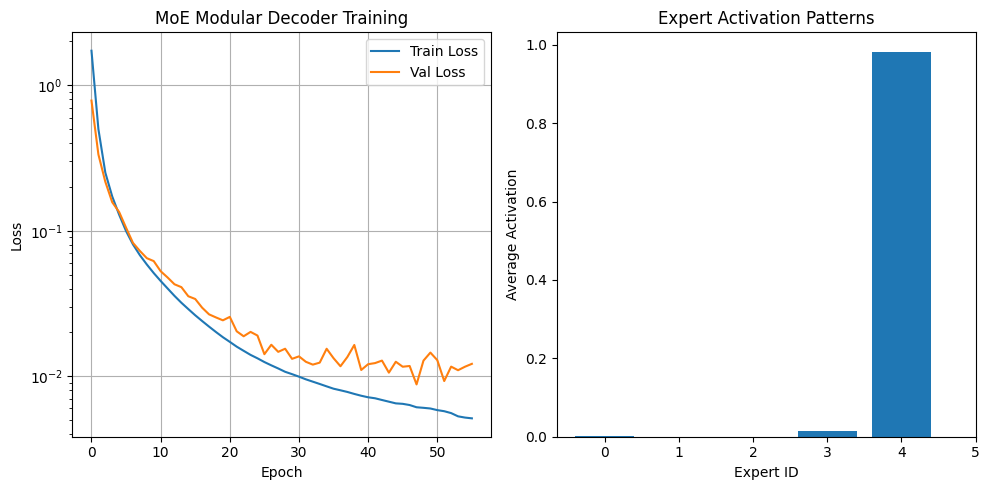

In [ ]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import torch

# choose moe or standard
USE_MOE = True

print(f"training {'moe' if USE_MOE else 'standard'} modular decoder")

# instantiate decoder
decoder_pw_mod_4 = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M, K=K, taus=taus,
   feature_dim=F_aligned.shape[1],
   activation="gelu",
   use_moe=True,
   num_experts=3,
   
   # ultra short-term focus
   maturity_experts=0,
   free_experts=3,
   maturity_specialization=True,
   
   # disable atm bias
   atm_specialization=False,
   atm_loss_weight=1.0,
   
   # higher diversity
   lambda_diversity=0.5,
)

decoder_pw_mod_4.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), loss=hybrid_loss_fn)

# training callbacks
model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/ae/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
   ModelCheckpoint(f"saved_models/ae/piecewise_surface_mod_{model_suffix}_4/decoder.keras", save_best_only=True, verbose=0)
]

# fit model - fixed: should be decoder_pw_mod_4
history = decoder_pw_mod_4.fit(
   X_train, y_train,
   validation_data=(X_val, y_val),
   batch_size=BATCH_SIZE,
   epochs=150,
   callbacks=callbacks,
   verbose=1
)

print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

# plot training
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title(f"{'moe' if USE_MOE else 'standard'} modular decoder training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
   plt.subplot(1, 2, 2)
   # analyze gating - fixed: should be decoder_pw_mod_4
   analysis = decoder_pw_mod_4.analyze_gating(X_val)
   if analysis is not None:
       plt.bar(range(decoder_pw_mod_4.num_experts), analysis['expert_activations'])
       plt.title("expert activation patterns")
       plt.xlabel("expert id")
       plt.ylabel("average activation")
       plt.xticks(range(decoder_pw_mod_4.num_experts))
       
       print(f"\nexpert analysis:")
       print(f"  expert activations: {analysis['expert_activations']}")
       print(f"  average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

Y_hat shape: (1216, 11, 10)
Y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
Piecewise Decoder with BS Loss RMSE_σ: 0.0068
RMSE by maturity (mean ± std): 0.0070 ± 0.0035
RMSE by strike    (mean ± std): 0.0076 ± 0.0020
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


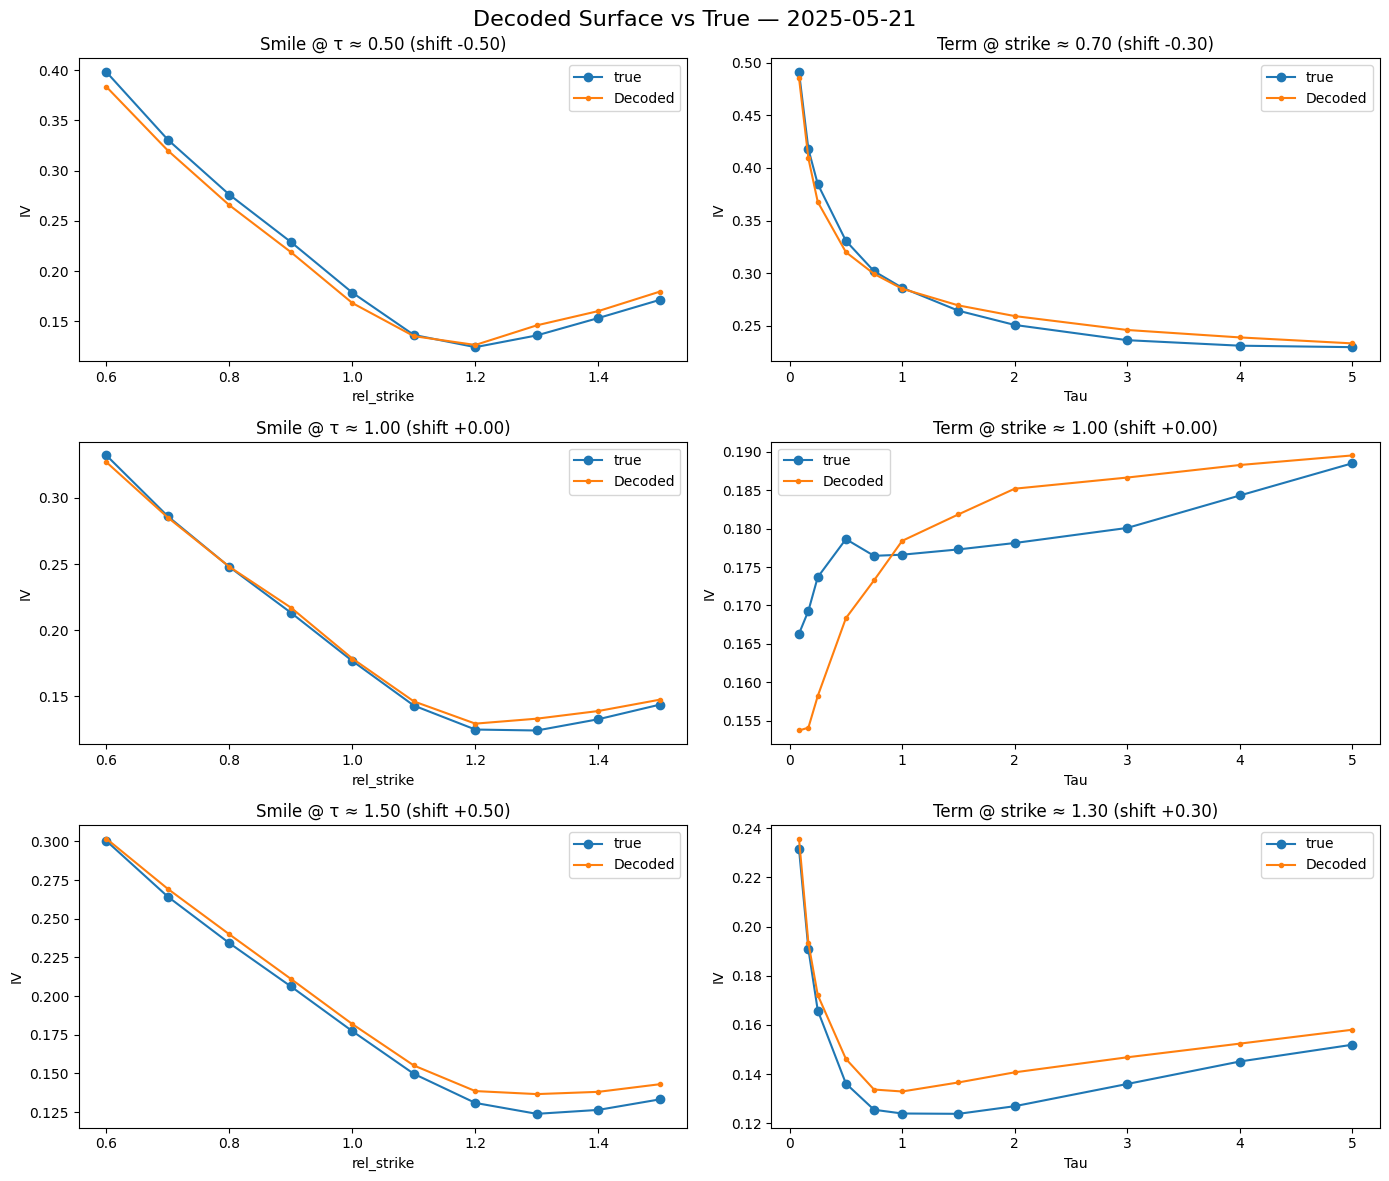

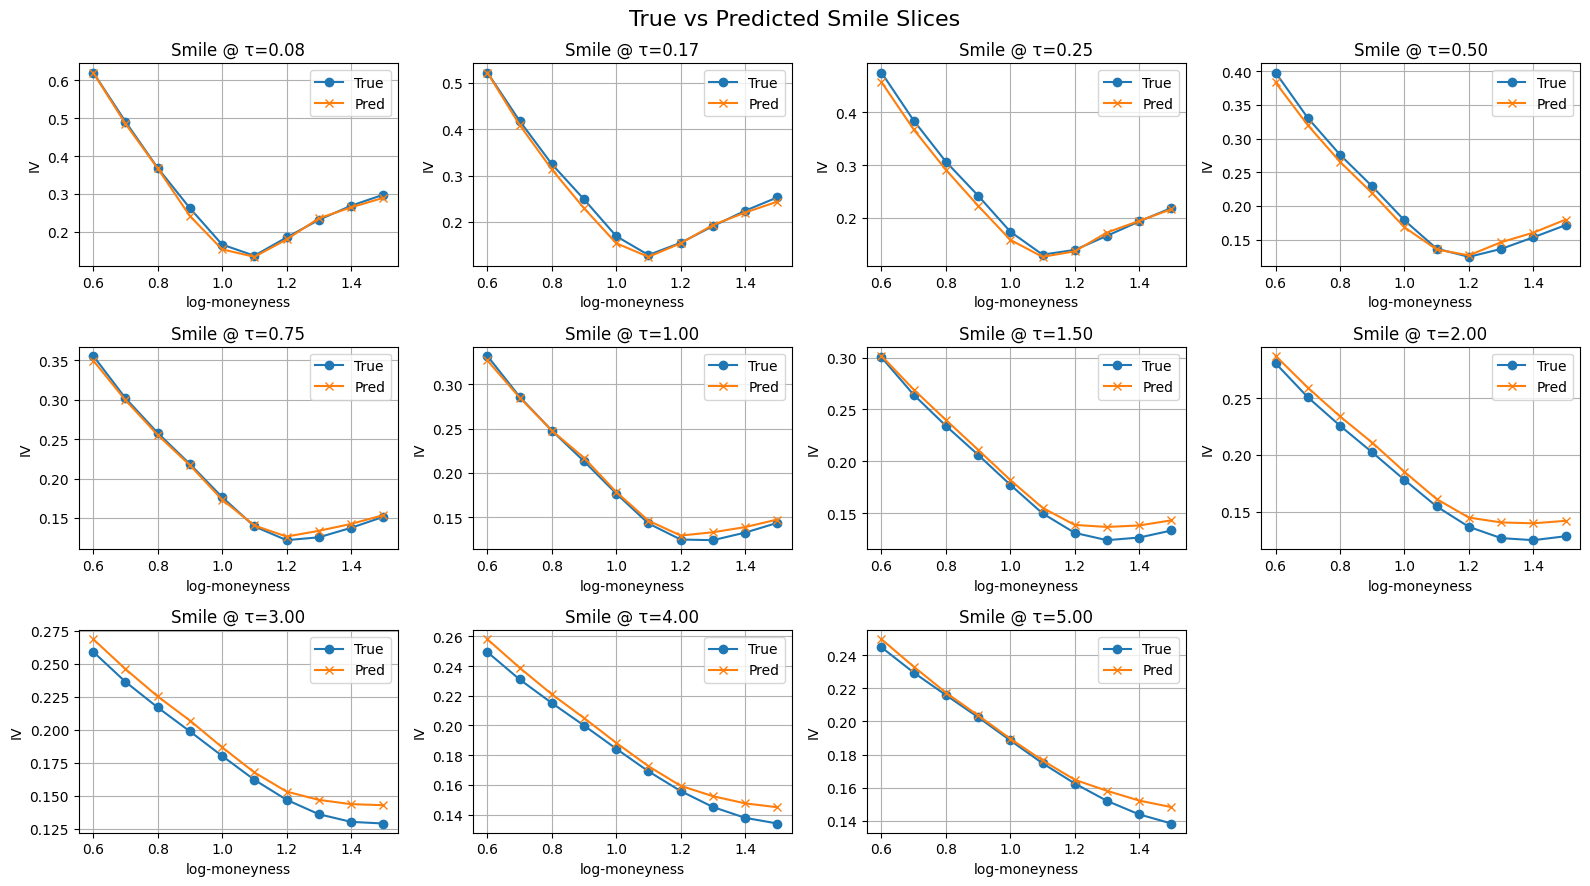

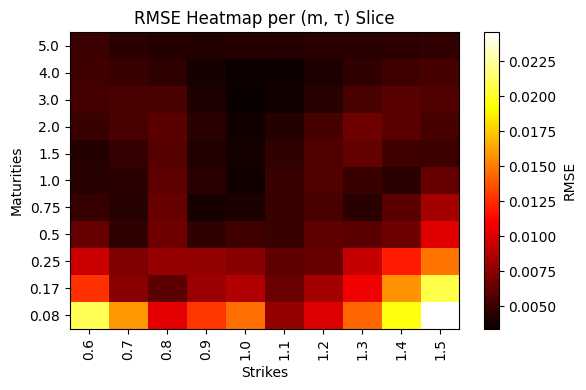

🔍 MoE Training Analysis
📊 Experts: 5
🎯 ATM Specialization: False
⚖️ Diversity λ: 0.35
💪 ATM Expert Bias: 2.0
--------------------------------------------------


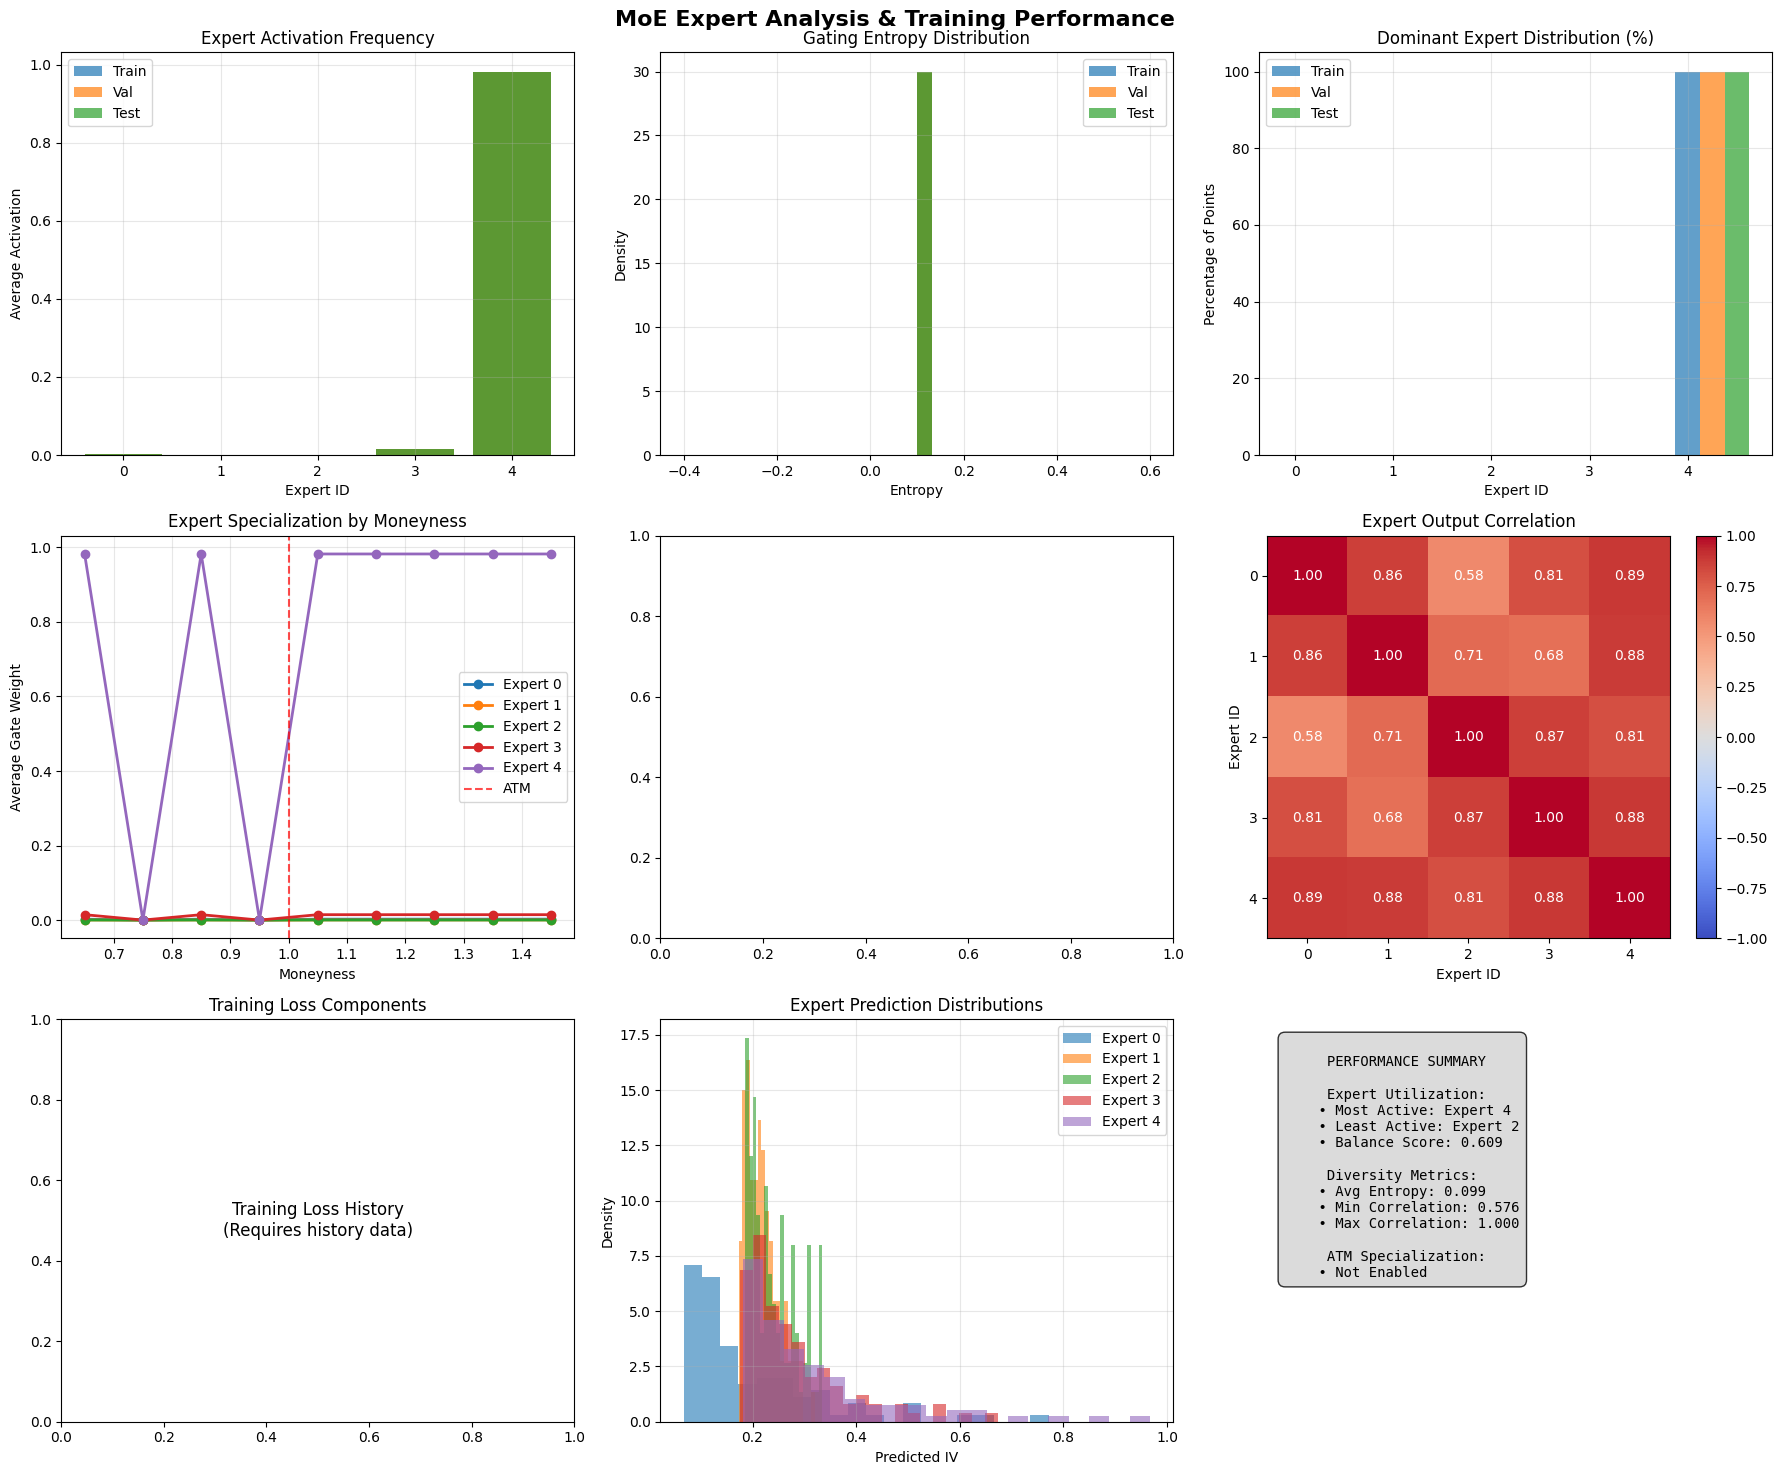


📊 DETAILED ANALYSIS:
Expert Activations: [2.5137919e-03 4.3870791e-04 2.5700821e-04 1.4491233e-02 9.8228168e-01]
Average Entropy: 0.0995
Expert Balance (1-std): 0.6088


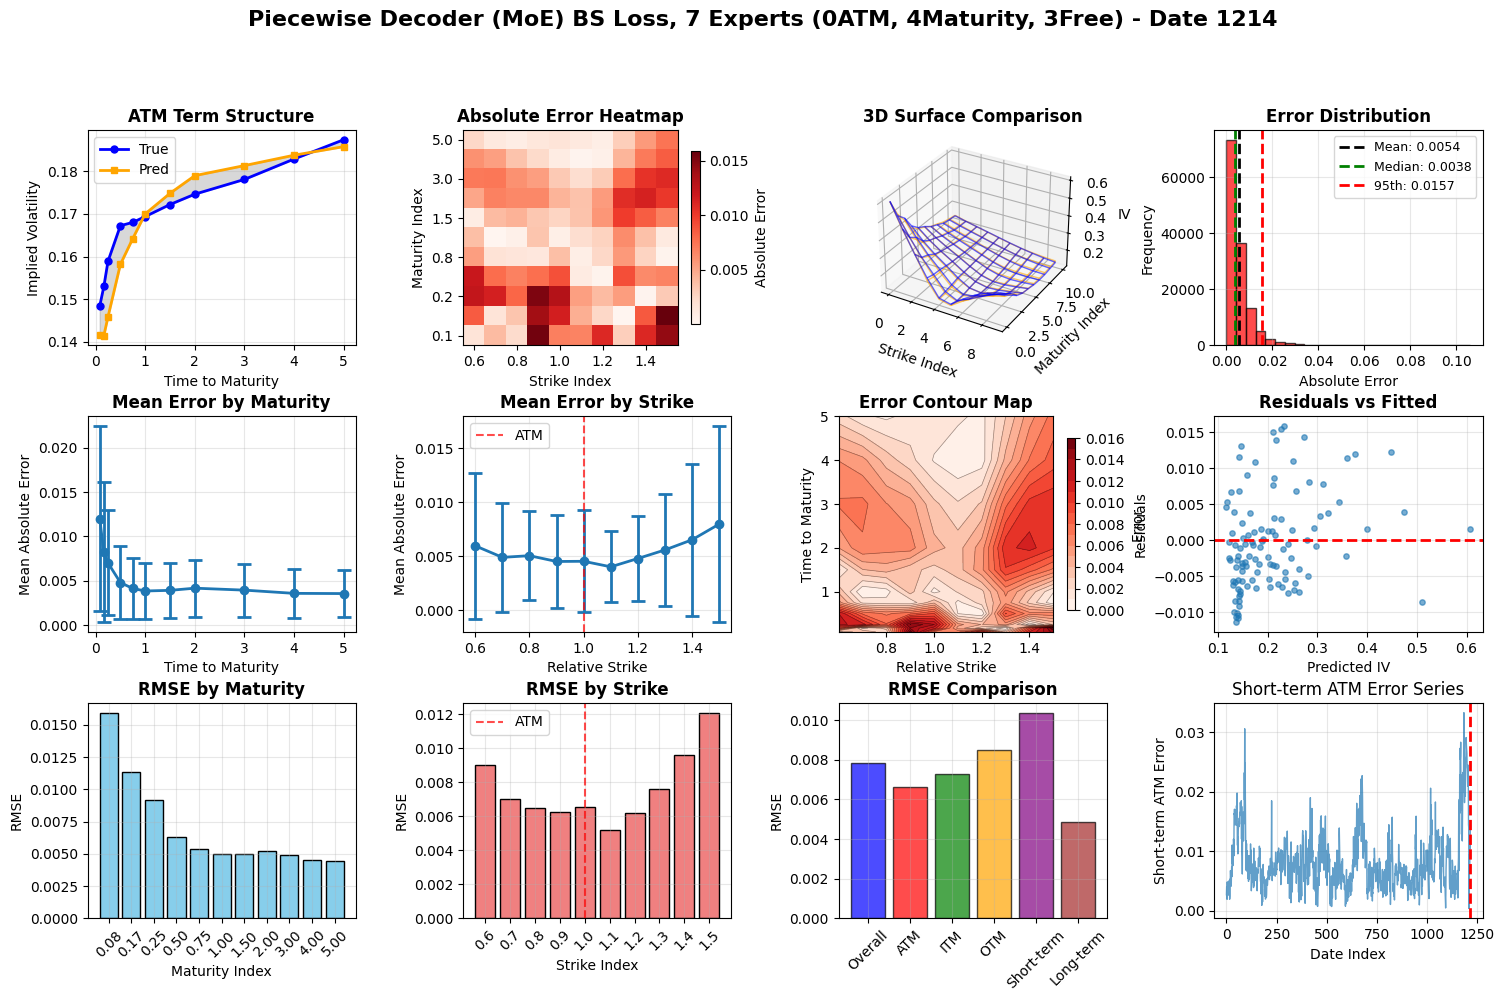

Overall Performance Category Performance  \
RMSE                           0.007850                  NaN   
MAE                            0.005371                  NaN   
Max Error                      0.106214                  NaN   
Mean Error                     0.005371                  NaN   
Median Error                   0.003810                  NaN   
95th Percentile                0.015657                  NaN   
ATM RMSE                            NaN             0.006649   
ITM RMSE                            NaN             0.007282   
OTM RMSE                            NaN             0.008503   
Short-term RMSE                     NaN             0.010353   
Long-term RMSE                      NaN             0.004865   
Short/Long Ratio                    NaN                2.128   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.004455)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.015905)                       NaN  
Best Strike           K=1.1 (RMSE: 0.005190)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.012068)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.006533)                       NaN  
Overall Rank              ATM ranks #5 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.128)  
ATM Issues                               NaN   NO (ATM/Overall: 0.85x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.001221)  
High Error Variance                      NaN       YES (std: 0.005726)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [ ]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prep strike-tau grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_4.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

print(f"y_hat shape: {Y_hat.shape}")
print(f"y_full shape: {Y_full.shape}")

# evaluate
evaluate_decoder_output_v2(
   Y_pred=Y_hat,
   Y_true=Y_full,
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=decoder_pw_mod_4,
   title="Piecewise Decoder with BS Loss, Moe 3 Experts (0ATM, 0Maturity, 3Free)"
)

import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance

# analyze moe performance
results = analyze_moe_training_performance(
   decoder_pw_mod_4,
   X_train,
   X_val,
   X_test,
   y_train,
   y_val,
   y_test
)

import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config again
Z_eval = Z_decoder
F_eval = F_aligned
Y_full = Y_decoder

# prep grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_4.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,
  Y_pred=Y_hat,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title="Piecewise Decoder (MoE) BS Loss, 3 Experts (0ATM, 0Maturity, 3Free)"
)

In [ ]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe_4 = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name="Piecewise Decoder with BS Loss (MoE) 3 Experts, atm 0, 0 Maturity, 3 Free",
   model=decoder_pw_mod_4  
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
   summary_pw_moe_2,
   summary_pw_moe_3,
   summary_pw_moe_4 
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0        ex 4 , 7 Experts, atm 1, 2 Free, 4 Maturity     1     0.007953   
1  ex 2: Piecewise Decoder with BS Loss (MoE) 7 E...     2     0.008090   
2  Piecewise Decoder with BS Loss (MoE) 7 Experts...     3     0.008229   
3  Piecewise Decoder with BS Loss (MoE) 7 Experts...     4     0.008608   
4                     Piecewise Decoder with BS Loss     5     0.009986   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.005499  0.008910  0.005772  0.007073  0.008403         2.010765   
1    0.005506  0.007543  0.004998  0.007248  0.008804         2.117567   
2    0.005606  0.006130  0.004229  0.007871  0.008852         2.176984   
3    0.005989  0.006421  0.004646  0.007601  0.009681         2.239612   
4    0.006955  0.009976  0.006823  0.009298  0.010506         2.365514   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.102920             True       False     EXCELLENT             False  
1  0.112518             True       False     EXCELLENT             False  
2  0.077566             True       False     EXCELLENT             False  
3  0.111818             True       False     EXCELLENT             False  
4  0.077199             True       False     EXCELLENT             False

---
---

## SHALLOW DECODER

---
---

---
---

## Residual correction to address post specific bias from full decoder

---
---

In [ ]:
print(f"dimension checks:")
print(f"M*K = {M*K}")
print(f"Z_train shape: {Z_train.shape}")
print(f"F_train shape: {F_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

# need vae baseline predictions first
vae_train_pred = decoder.predict(Z_train, verbose=0)[0][:, :M*K]  # surface only
vae_val_pred = decoder.predict(Z_val, verbose=0)[0][:, :M*K]
vae_test_pred = decoder.predict(Z_test, verbose=0)[0][:, :M*K]

print(f"vae predictions shape: {vae_train_pred.shape}")

# convert vae baseline to pointwise format
[_, _, _], vae_train_pointwise = decoder_pw.build_training_data_from_surfaces(
   Z_train, vae_train_pred, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_train
)
[_, _, _], vae_val_pointwise = decoder_pw.build_training_data_from_surfaces(
   Z_val, vae_val_pred, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_val
)
[_, _, _], vae_test_pointwise = decoder_pw.build_training_data_from_surfaces(
   Z_test, vae_test_pred, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_test
)

print(f"vae pointwise shape: {vae_train_pointwise.shape}")

# compute residual targets (y_true - vae_baseline)
Y_residual_train = y_train - vae_train_pointwise
Y_residual_val = y_val - vae_val_pointwise
Y_residual_test = y_test - vae_test_pointwise

print(f"\nresidual statistics:")
print(f"train residuals - mean: {Y_residual_train.mean():.6f}, std: {Y_residual_train.std():.6f}")
print(f"train residuals - range: [{Y_residual_train.min():.6f}, {Y_residual_train.max():.6f}]")
print(f"val residuals - mean: {Y_residual_val.mean():.6f}, std: {Y_residual_val.std():.6f}")
print(f"val residuals - range: [{Y_residual_val.min():.6f}, {Y_residual_val.max():.6f}]")
print(f"test residuals - mean: {Y_residual_test.mean():.6f}, std: {Y_residual_test.std():.6f}")
print(f"test residuals - range: [{Y_residual_test.min():.6f}, {Y_residual_test.max():.6f}]")

# setup single experiment - mlp residual correction with features
Y_rl_train = Y_residual_train
Y_rl_val = Y_residual_val
Y_rl_test = Y_residual_test
X_rl_train = X_train  # [z+f, grid] with features
X_rl_val = X_val
X_rl_test = X_test

print(f"\nexperiment setup:")
print(f"mlp residual correction with features:")
print(f"input x: {len(X_rl_train)} arrays, shapes: {[x.shape for x in X_rl_train]}")
print(f"target y: {Y_rl_train.shape}")


=== DIMENSION CHECKS ===
M*K = 110
Z_train shape: (851, 12)
F_train shape: (851, 136)
Y_train shape: (851, 110)
VAE predictions shape: (851, 110)
VAE pointwise shape: (93610, 1)

=== RESIDUAL STATISTICS ===
Train residuals - mean: -0.001353, std: 0.021421
Train residuals - range: [-0.116248, 0.144860]
Val residuals - mean: -0.022173, std: 0.021814
Val residuals - range: [-0.105327, 0.268821]
Test residuals - mean: -0.015394, std: 0.027520
Test residuals - range: [-0.093771, 0.335419]

=== EXPERIMENT SETUP ===
MLP residual correction with features:
Input X: 3 arrays, shapes: [(93610, 148), (93610, 1), (93610, 1)]
Target Y: (93610, 1)
Question: Can MLP learn VAE residual corrections using [latents + features + grid]?


In [ ]:
import models.rl_decoder
import importlib    
importlib.reload(models.rl_decoder)

from models.rl_decoder import PointwiseRLDecoder
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam



# Setup model
# With Black-Scholes loss but need to change the signature
rl_model = PointwiseRLDecoder(
    use_delta=False,
    normalize_delta=False,
    correction_scale=1.0,
    use_bs_loss=True,
    taus=ops.convert_to_numpy(tensors["taus"]),
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    M=M,
    K=K
)
rl_model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0))

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-6),
    ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
    ModelCheckpoint("saved_models/rl_decoder/pointwise_rl_residual.keras", save_best_only=True, verbose=0)
]

# Train
history = rl_model.fit(
    x=X_rl_train,
    y=Y_rl_train,
    validation_data=(X_rl_val, Y_rl_val),
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

print(f"Final train loss: {history.history['loss'][-1]:.6f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.6f}")

Vega weight range: 0.000 to 3.197
Gamma weight range: 0.000 to 18.349
Weight analysis by maturity:
tau_grid.shape: (11, 10)
First row (mat 0): [0.08333333 0.08333333 0.08333333]
First col (strike 0): [0.08333333 0.16666667 0.25      ]
Maturity 0: τ=0.083 -> Avg Vega=0.06, Avg Gamma=2.68
Maturity 1: τ=0.167 -> Avg Vega=0.12, Avg Gamma=1.90
Maturity 2: τ=0.250 -> Avg Vega=0.18, Avg Gamma=1.56
Maturity 3: τ=0.500 -> Avg Vega=0.37, Avg Gamma=1.12
Maturity 4: τ=0.750 -> Avg Vega=0.55, Avg Gamma=0.91
Epoch 1/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.0507 - val_loss: 0.2068 - learning_rate: 1.0000e-04
Epoch 2/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.1437 - val_loss: 0.1459 - learning_rate: 1.0000e-04
Epoch 3/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.1570 - val_loss: 0.2575 - learning_rate: 1.0000e-04
Epoch 4/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0886 - val_loss: 0.3570 - learning_rate: 1.0000e-04
Epoch 5/100
2926/2926 ━━━━━━

Y_vae_baseline shape: (1216, 110)
Y_residual_corrections shape: (1216, 110)
Y_hat (final) shape: (1216, 11, 10)
Evaluation dimensions: N=1216, M=11, K=10
VAE + MLP Residual Corrections (No Features) RMSE_σ: 0.0307
RMSE by maturity (mean ± std): 0.0308 ± 0.0061
RMSE by strike    (mean ± std): 0.0314 ± 0.0015
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


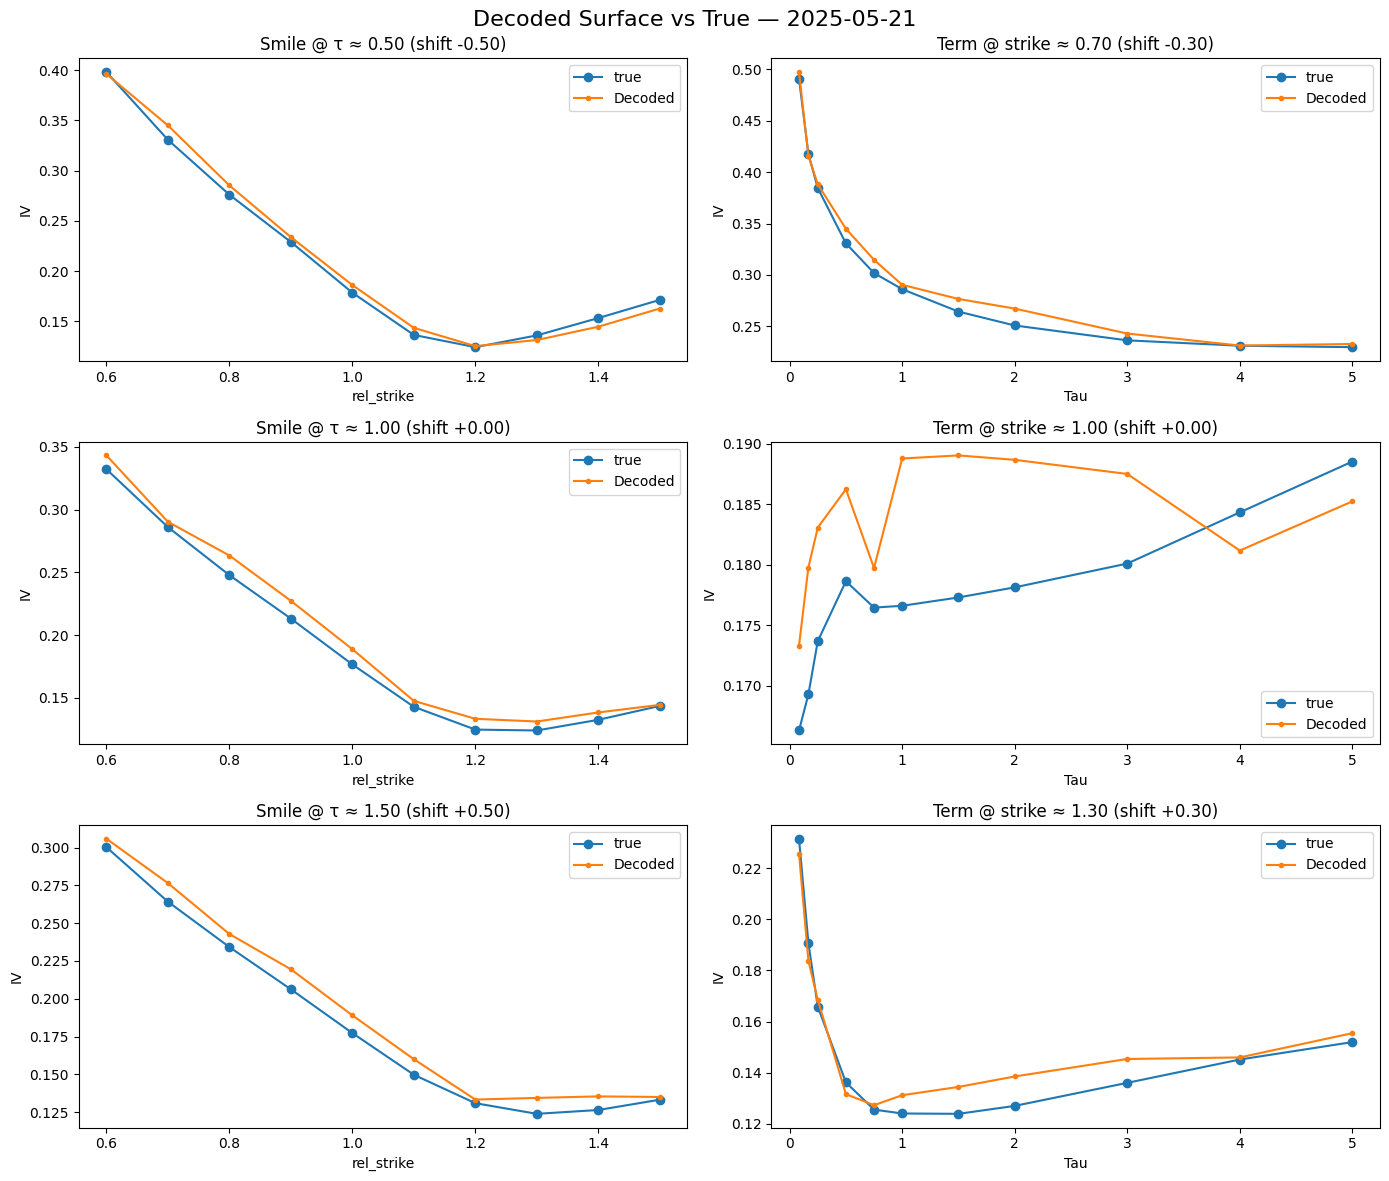

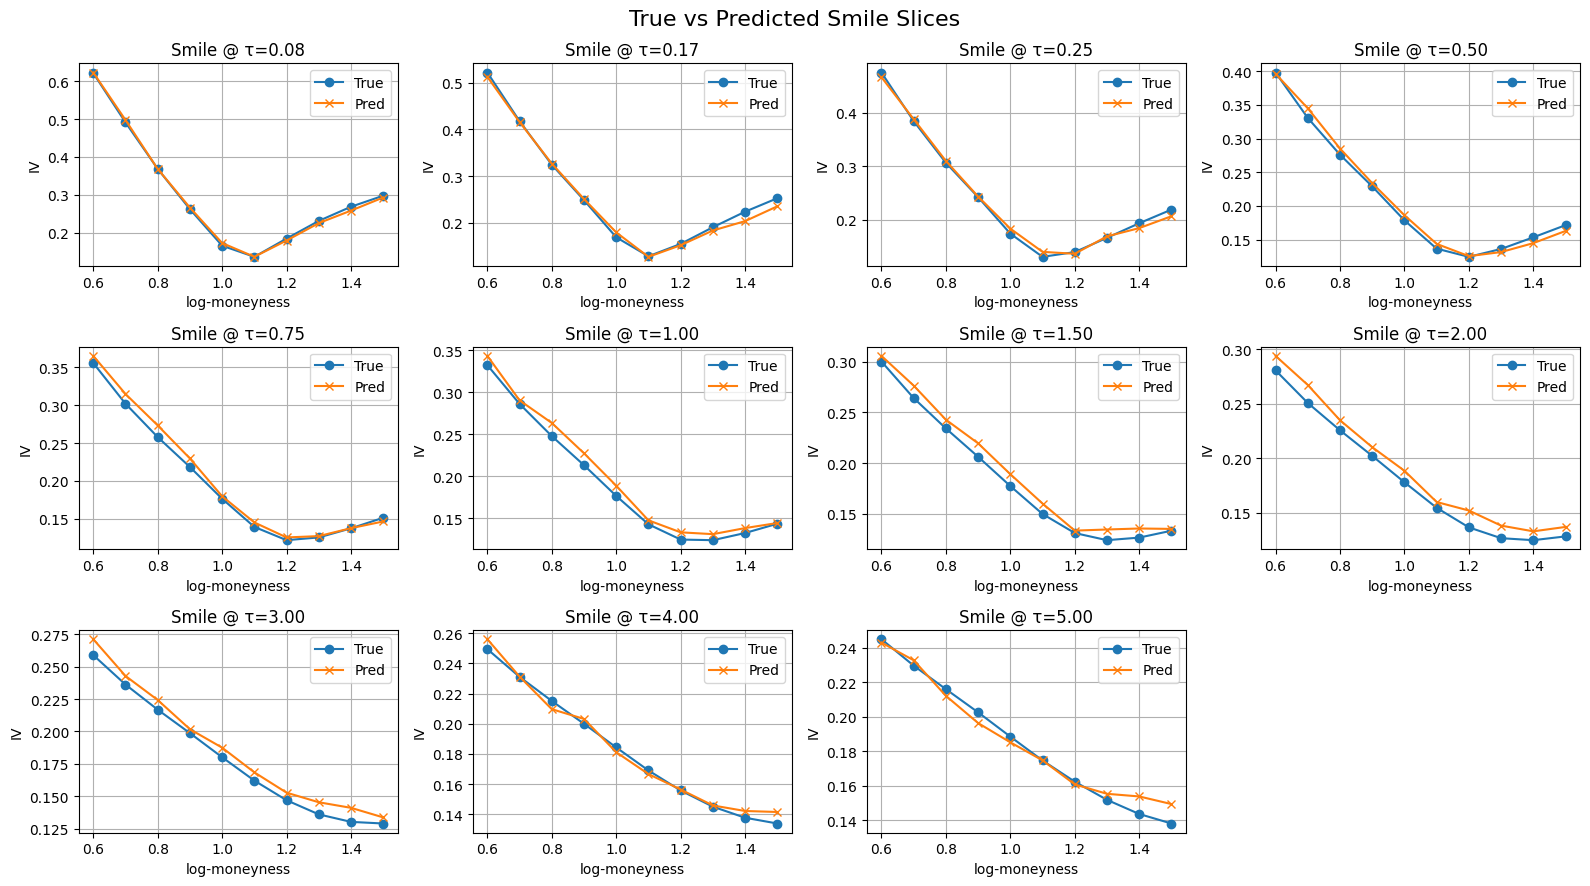

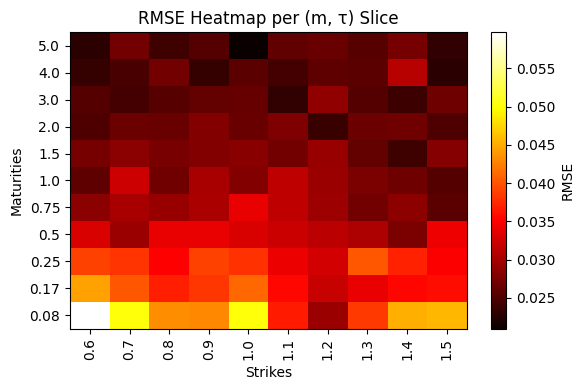

{'rmse_overall': 0.030709503,
 'rmse_by_maturity': array([0.04492612, 0.0375476 , 0.03685958, 0.0319453 , 0.02955566,
        0.0284707 , 0.02749583, 0.02631833, 0.02562782, 0.02555802,
        0.02496208], dtype=float32),
 'rmse_by_strike': array([0.03400141, 0.032865  , 0.03108049, 0.03198723, 0.0330155 ,
        0.03033323, 0.02902273, 0.03017305, 0.03100617, 0.03057942],
       dtype=float32)}

In [ ]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# get vae baseline surfaces
Y_vae_baseline = decoder.predict(Z_eval, verbose=0)[0][:, :M*K]  # (N, M*K)

# prepare strike-tau grid
m_grid, tau_grid = np.meshgrid(
   ops.convert_to_numpy(tensors["strike_tensor"]),
   ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate mlp residual corrections
Y_residual_corrections = np.stack([
   rl_model.predict_surface(z, f, m_flat, tau_flat)  # pass features f, not none
   for z, f in zip(Z_eval, F_eval)
])

# combine: final prediction = vae baseline + mlp corrections
Y_hat = Y_vae_baseline.reshape(-1, M, K) + Y_residual_corrections.reshape(-1, M, K)

print(f"Y_vae_baseline shape: {Y_vae_baseline.shape}")
print(f"Y_residual_corrections shape: {Y_residual_corrections.shape}")
print(f"Y_hat (final) shape: {Y_hat.shape}")

# evaluate combined model
evaluate_decoder_output_v2(
    Y_pred=Y_hat,                          # vae + mlp corrections
    Y_true=Y_full,                         # ground truth
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=rl_model,                      # mlp decoder for penalty calc
    title="VAE + MLP Residual Corrections (No Features)"
)

Generated 2 residual-sensitive regions
Region keys: ['short_term_d0', 'long_term_d0']


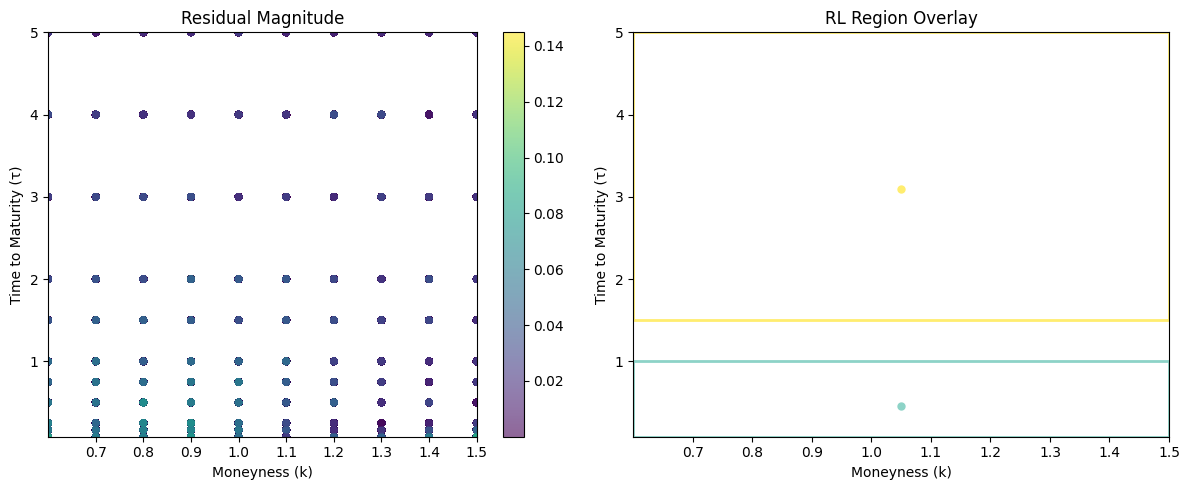

Vega weight range: 0.000 to 3.197
Gamma weight range: 0.000 to 18.349
Weight analysis by maturity:
tau_grid.shape: (11, 10)
First row (mat 0): [0.08333333 0.08333333 0.08333333]
First col (strike 0): [0.08333333 0.16666667 0.25      ]
Maturity 0: τ=0.083 -> Avg Vega=0.06, Avg Gamma=2.68
Maturity 1: τ=0.167 -> Avg Vega=0.12, Avg Gamma=1.90
Maturity 2: τ=0.250 -> Avg Vega=0.18, Avg Gamma=1.56
Maturity 3: τ=0.500 -> Avg Vega=0.37, Avg Gamma=1.12
Maturity 4: τ=0.750 -> Avg Vega=0.55, Avg Gamma=0.91
Vega weight range: 0.000 to 3.197
Gamma weight range: 0.000 to 18.349
Weight analysis by maturity:
tau_grid.shape: (11, 10)
First row (mat 0): [0.08333333 0.08333333 0.08333333]
First col (strike 0): [0.08333333 0.16666667 0.25      ]
Maturity 0: τ=0.083 -> Avg Vega=0.06, Avg Gamma=2.68
Maturity 1: τ=0.167 -> Avg Vega=0.12, Avg Gamma=1.90
Maturity 2: τ=0.250 -> Avg Vega=0.18, Avg Gamma=1.56
Maturity 3: τ=0.500 -> Avg Vega=0.37, Avg Gamma=1.12
Maturity 4: τ=0.750 -> Avg Vega=0.55, Avg Gamma=0.91


In [ ]:
import importlib
import models.rl_decoder
import utils.pointwise_router

importlib.reload(models.rl_decoder)
importlib.reload(utils.pointwise_router)

from models.rl_decoder import PointwiseRLDecoder
from utils.pointwise_router import PointwiseCorrectionRouter
from utils.pointwise_router import generate_residual_masks, visualize_residual_regions

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt

# extract coordinates from correct training data (vae residuals)
k_vals = X_rl_train[1].flatten()      # strike coordinates from [z+f, strikes, taus]
tau_vals = X_rl_train[2].flatten()    # tau coordinates 
residuals = Y_rl_train.flatten()      # vae residuals we computed earlier

region_config = {
 "method": "hierarchical", 
 "bins_k": 4,                
 "bins_tau": 4,              
 "quantile_thresholds": (0, 1),  
 "n_clusters": 12,
 "max_depth": 3,
 "min_samples": 100,
 "improvement_threshold": 0.001,
 "error_threshold": 0.02,
 "atm_lower": 0.9,
 "atm_upper": 1.10,
 "tau_short": 0.12,
 "tau_mid": 3, 
}

region_masks, region_centers, aux_info, _ = generate_residual_masks(
 k_vals=k_vals,
 tau_vals=tau_vals,
 residuals=residuals,
 **region_config
)

print(f"generated {len(region_masks)} residual-sensitive regions")
print("region keys:", list(region_masks.keys()))

if region_config["method"] == "grid":
 visualize_residual_regions(k_vals, tau_vals, residuals, aux_info, region_masks)
else:
 visualize_residual_regions(k_vals, tau_vals, residuals, region_masks=region_masks)

# instantiate rl router using vae residual-based masks
router = PointwiseCorrectionRouter(
 region_masks=region_masks,
 region_centers=region_centers,
 model_cls=PointwiseRLDecoder,
 model_kwargs={"use_delta": False, "normalize_delta": False, "correction_scale": 1.0, "use_bs_loss": True, 
               "taus": ops.convert_to_numpy(tensors["taus"]), "rel_strikes": ops.convert_to_numpy(tensors["strike_tensor"]), 
               "M": M, "K": K},
)

# use vae residuals as targets
router.true_targets = Y_rl_train  # vae residuals from our recent computation
router.global_residuals = Y_rl_train.flatten()  # same vae residuals

router.region_rmse = {}
for name, mask in region_masks.items():
 if np.any(mask):
     router.region_rmse[name] = np.sqrt(np.mean(Y_rl_train[mask]**2))
     print(f"[{name}] region rmse: {router.region_rmse[name]:.4f}")

# compile and train on vae residuals
router.compile_all(optimizer_fn=lambda: Adam(learning_rate=1e-4, clipnorm=1.0))
callbacks = [
 EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
 ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, min_lr=1e-7)
]

router.fit_all(
  X_rl_train,     # [z+f, strikes, taus] inputs
  Y_rl_train,     # vae residuals targets
  batch_size=BATCH_SIZE,
  epochs=100,
  validation_data=(X_rl_val, Y_rl_val),  # vae residuals validation
  callbacks=callbacks,
  verbose=0
)

# save all region-specific decoders
os.makedirs("saved_models/rl_decoder", exist_ok=True)
router.save_all("saved_models/rl_decoder/pointwise_rl_{name}.keras")

[short_term_d0] mask count: 10980
[long_term_d0] mask count: 9150
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


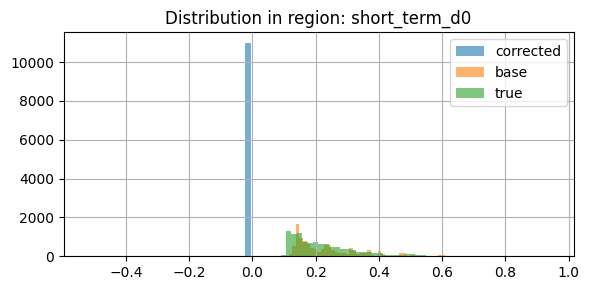

[short_term_d0] RMSE (base): 0.15965793
[short_term_d0] RMSE (corrected): 0.28190908
X_mask length: 3 shapes: [(10980, 148), (10980, 1), (10980, 1)]
delta_mask stats: -0.023626186 -0.023626186 -0.023626184
base_mask stats: 0.11506499 0.67758864
Y_true_mask stats: 0.089179985 0.94233185 0.23233618
Input X_rl_test length: 3
Number of trained models: 2


In [ ]:
# recreate region masks for test data
k_vals_test = X_m_test.flatten()
tau_vals_test = X_tau_test.flatten()
residuals_test = Y_rl_test.flatten()
region_config["method"] = "hierarchical"  # update method
region_masks_test, region_centers_test, aux_info_test, _ = generate_residual_masks(
    k_vals=k_vals_test,
    tau_vals=tau_vals_test,
    residuals=residuals_test,
    **region_config
)

for name, mask in region_masks_test.items():
   print(f"[{name}] mask count: {np.sum(mask)}")

region_name = "short_term_d0"
mask = region_masks_test[region_name]
model = router.models[region_name]

y_test_flat = y_test.flatten()  # fix: define y_test_flat
X_mask = [x[mask] for x in X_rl_test]
Y_true_mask = y_test_flat[mask]
base_mask = vae_test_pointwise[mask]

delta_mask = model.predict(X_mask, batch_size=BATCH_SIZE)

use_delta = getattr(model, "use_delta", True)
IV_corrected_mask = base_mask + delta_mask.flatten() if use_delta else delta_mask.flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.hist(IV_corrected_mask, bins=50, alpha=0.6, label="corrected")
plt.hist(base_mask, bins=50, alpha=0.6, label="base")
plt.hist(Y_true_mask, bins=50, alpha=0.6, label="true")
plt.title(f"distribution in region: {region_name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rmse = lambda x, y: np.sqrt(np.mean((x - y) ** 2))
print(f"[{region_name}] rmse (base):", rmse(base_mask, Y_true_mask))
print(f"[{region_name}] rmse (corrected):", rmse(IV_corrected_mask, Y_true_mask))

print("X_mask length:", len(X_mask), "shapes:", [x.shape for x in X_mask])
print("delta_mask stats:", delta_mask.min(), delta_mask.max(), delta_mask.mean())
print("base_mask stats:", base_mask.min(), base_mask.max())
print("Y_true_mask stats:", Y_true_mask.min(), Y_true_mask.max(), Y_true_mask.mean())

print(f"input X_rl_test length: {len(X_rl_test)}")
print(f"number of trained models: {len(router.trained_models)}")

In [ ]:
import importlib
import utils.pointwise_router
importlib.reload(utils.pointwise_router)

from utils.pointwise_router import visualize_residual_regions

# use consistent baseline predictions
IV_pred_flat = vae_test_pointwise.reshape(-1, 1)  # should be vae_test_pointwise not deep_test_pred

use_soft_blend = True

# update router with test region centers
router.region_centers = region_centers_test
router.masks = region_masks_test

if use_soft_blend:
   # try original concatenated format for router
   X_rl_concat = np.concatenate([X_m_test, X_tau_test, vae_test_pointwise.reshape(-1, 1)], axis=1)
   X_coord = np.column_stack([k_vals_test, tau_vals_test])
   
   try:
       IV_corrected_flat = router.predict(
           X_full=X_rl_concat,
           X_coord=X_coord,
           base=IV_pred_flat
       )
   except:
       print("soft blend failed, falling back to manual correction")
       use_soft_blend = False

if not use_soft_blend:
   # manual region-by-region correction
   IV_corrected_flat = IV_pred_flat.copy()
   
   for name in router.trained_models:
       mask = region_masks_test[name]
       model = router.models[name]
       
       X_mask = [x[mask] for x in X_rl_test]
       base_mask = IV_pred_flat[mask]
       
       delta_mask = model.predict(X_mask, batch_size=BATCH_SIZE)
       
       if getattr(model, "use_delta", True):
           corrected = base_mask + delta_mask
       else:
           corrected = delta_mask
           
       IV_corrected_flat[mask] = corrected.reshape(-1, 1)

X_pred_rl = IV_corrected_flat.reshape(Z_test.shape[0], M, K)

evaluate_decoder_output(
   decoder=decoder_pw,
   Z_forecast=Z_test,
   X_grid=Y_test.reshape(-1, M, K),
   X_true_idx=None,
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoded_surfaces_override=X_pred_rl,
   title="decoder + rl correction (soft blend)" if use_soft_blend else "decoder + rl correction (manual)"
)

In [ ]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output

# --- Config
SMOOTH_ALL = False
N_surfaces = 10

# --- Select latent forecasts, features, and true surfaces
Z_eval = Z_decoder if SMOOTH_ALL else Z_decoder[-N_surfaces:]
F_eval = F_aligned if SMOOTH_ALL else F_aligned[-N_surfaces:]
X_grid_eval = Y_decoder if SMOOTH_ALL else Y_decoder[-N_surfaces:]

# --- Predict surfaces from z ⊕ f
X_pred_mod = np.stack([
    decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_eval, F_eval)
])

# --- Apply surface refinement
X_pred_mod_smooth = np.stack([
    decoder_pw_mod.refine_surface(surf, lambda_cal=1.0, lambda_smile=1.0)
    for surf in X_pred_mod
])

# --- Evaluate decoded surfaces
evaluate_decoder_output(
    decoder=decoder_pw_mod,
    Z_forecast=Z_eval,
    X_grid=X_grid_eval,
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=rel_strikes,
    taus=taus,
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_mod_smooth,
    title="Smoothed VAE–GRU (Piecewise Modular)"
)
